In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

## Global COVID-19 Analysis

In [3]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases



Total number of cases (in countries with at least 100 cases) as of 4/4/20


4/4/20
Country/Region             
US                   308850
Spain                126168
Italy                124632
Germany               96092
France                90848
...                     ...
Kenya                   126
Cambodia                114
Guinea                  111
Trinidad and Tobago     103
Rwanda                  102

[116 rows x 1 columns]

## US State Measures

In [4]:
import requests

location_state_list = []
location_hashmap = dict()

def process_locations():
    r = requests.get("https://covid19.healthdata.org/api/metadata/location")
    j = r.json()
    
    for loc in j:
        if loc.get("location_name") == "United States of America":
            continue
        
        location_hashmap[loc.get("location_name")] = loc["location_id"]
        location_state_list.append(loc.get("location_name"))

process_locations()

measures_taken_per_state = dict()

def fetch_state_info(state):
    location_id = location_hashmap.get(state)
    
    intervention_url = 'https://covid19.healthdata.org/api/data/intervention?location='+str(location_id)

    r = requests.get(intervention_url)
    j = r.json()
    
    measures_taken_per_state[state] = []

    for intervention in j:
        date_format = "%Y-%m-%d %H:%M:%S"
        
        measures_taken_per_state[state].append(dict(
            measure=intervention["covid_intervention_measure_name"],
            reported=datetime.strptime(intervention["date_reported"], date_format)
        ))
    
    return measures_taken_per_state[state]

def populate_locations():
    for state in location_state_list:
        print("Processing state measures", state)
        fetch_state_info(state)
    
    no_measure_states = []
    one_measure_states = []
    two_measure_states = []
    
    for state in location_state_list:
        if len(measures_taken_per_state.get(state)) == 0:
            no_measure_states.append(state)
        if len(measures_taken_per_state.get(state)) == 1:
            one_measure_states.append(state)
        if len(measures_taken_per_state.get(state)) == 2:
            two_measure_states.append(state)
    
    states_without_stay_at_home = []
    
    for state in location_state_list:
        no_stay_at_home = True
        for measure in measures_taken_per_state.get(state):
            if measure["measure"] == "People instructed to stay at home":
                no_stay_at_home = False
        
        if no_stay_at_home:
            states_without_stay_at_home.append(state)
            
    states_without_closures = []
    
    for state in location_state_list:
        no_closures = True
        for measure in measures_taken_per_state.get(state):
            if measure["measure"] == "Non-essential services closed (i.e., bars/restaurants)":
                no_closures = False
        
        if no_closures:
            states_without_closures.append(state)
            
        
            
    print("0 measure States:")
    print(", ".join(no_measure_states))
    print("1 measure States:")
    print(", ".join(one_measure_states))
    print("2 measure States:")
    print(", ".join(two_measure_states))
    
    print("States without stay at home orders:")
    print(", ".join(states_without_stay_at_home))
    
    print("States without closures of non-essential services:")
    print(", ".join(states_without_closures))

populate_locations()

def get_state_measures(state):
    return measures_taken_per_state.get(state, None)


Processing state measures Alabama
Processing state measures Alaska
Processing state measures Arizona
Processing state measures Arkansas
Processing state measures California
Processing state measures Colorado
Processing state measures Connecticut
Processing state measures Delaware
Processing state measures District of Columbia
Processing state measures Florida
Processing state measures Georgia
Processing state measures Hawaii
Processing state measures Idaho
Processing state measures Illinois
Processing state measures Indiana
Processing state measures Iowa
Processing state measures Kansas
Processing state measures Kentucky
Processing state measures Louisiana
Processing state measures Maine
Processing state measures Maryland
Processing state measures Massachusetts
Processing state measures Michigan
Processing state measures Minnesota
Processing state measures Mississippi
Processing state measures Missouri
Processing state measures Montana
Processing state measures Nebraska
Processing stat

## Curve Fitting Global COVID-19 Cases

In [18]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country, isDeaths=False):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    x_pred = np.arange(y.size+21) # 3 weeks into the future
    
    # Only predict based on figures above 10
    skip_days = 0
    
    for day in range(len(y)):
        cases = y[day]
        
        if cases > 10:
            skip_days = day
            break
    
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(20,10))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    # Draw our skip days line
    plt.axvline(x=skip_days,label="Fit after this")
    
    # Draw our date lines
    plt.axvline(x=y.size,label=mostrecentdate,color="pink")
    most_recent_date_as_index = y.size-1
    date_format = "%m/%d/%y"
    aus_date_format = "%d/%m/%y"
    most_recent_date_as_date = datetime.strptime(mostrecentdate, date_format)
    
    in_7_days_date = most_recent_date_as_date+timedelta(days=7)
    in_14_days_date = most_recent_date_as_date+timedelta(days=14)

    plt.axvline(x=most_recent_date_as_index+7,label=in_7_days_date.strftime(aus_date_format),color="orange")
    plt.axvline(x=most_recent_date_as_index+14,label=in_14_days_date.strftime(aus_date_format),color="purple")
    
    # Check if this state has had measures taken
    state_measures = get_state_measures(country)
    
    if not state_measures == None:
        for measure in state_measures:
            days_before_latest = (most_recent_date_as_date - measure["reported"]).days
            index_of_measure = most_recent_date_as_index - days_before_latest
            
            plt.axvline(x=index_of_measure,label=measure["measure"] + " on " +  measure["reported"].strftime(aus_date_format),color="green")
        
    try:
        lpopt, lpcov = curve_fit(logistic, x[skip_days:], y[skip_days:], maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x_pred, logistic(x_pred, lpopt[0], lpopt[1]-lerror[1], lpopt[2], lpopt[3]), 'b--', label="LgstcCrv Fit Low")
            plt.plot(x_pred, logistic(x_pred, lpopt[0], lpopt[1]+lerror[1], lpopt[2], lpopt[3]), 'b--', label="LgstcCrv Fit High")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tSkipping', skip_days, "days")
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x[skip_days:], y[skip_days:], bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x_pred, exponential(x_pred, epopt[0], epopt[1]-eerror[1], epopt[2]), 'r--', label="ExpCrv Fit Low")
            plt.plot(x_pred, exponential(x_pred, epopt[0], epopt[1]+eerror[1], epopt[2]), 'r--', label="ExpCrv Fit High")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tSkipping', skip_days, "days")
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            
            exponentialworked = True
            
    except:
        pass
    
    
    if isDeaths:
        plt.title(country + ' Cumulative COVID-19 Deaths. (Updated on '+mostrecentdate+')', fontsize="x-large")
        plt.ylabel('Total Deaths', fontsize="x-large")
    else:
        plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
        plt.ylabel('Total Cases', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.yscale('log')
    plt.ylim(bottom=1)
    
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 308850
	Confirmed cases on 3/28/20 	 121478
	Ratio: 2.54
	Weekly increase: 154.2 %
	Daily increase: 14.3 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Exponential Fit **

	R^2: 0.9918357141937582
	Skipping 12 days
	Doubling Time (represents overall growth):  4.39 (± 0.22 ) days


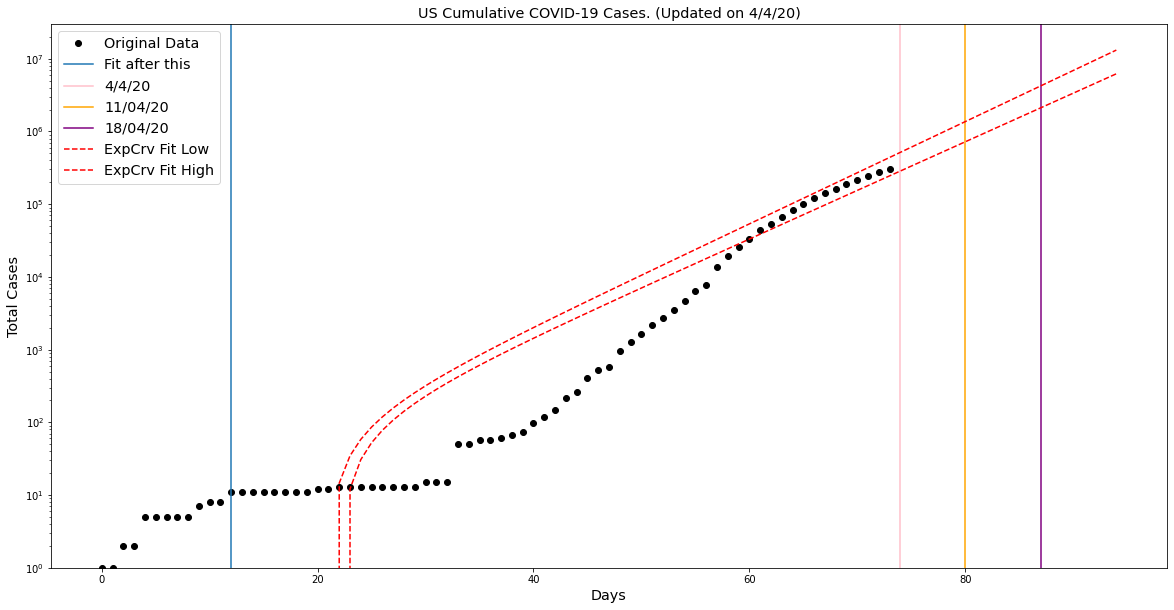



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 124632
	Confirmed cases on 3/28/20 	 92472
	Ratio: 1.35
	Weekly increase: 34.8 %
	Daily increase: 4.4 % per day
	Doubling Time (represents recent growth): 16.3 days

** Based on Logistic Fit**

	R^2: 0.9993321376937564
	Skipping 21 days
	Doubling Time (during middle of growth):  8.33 (± 0.29 ) days


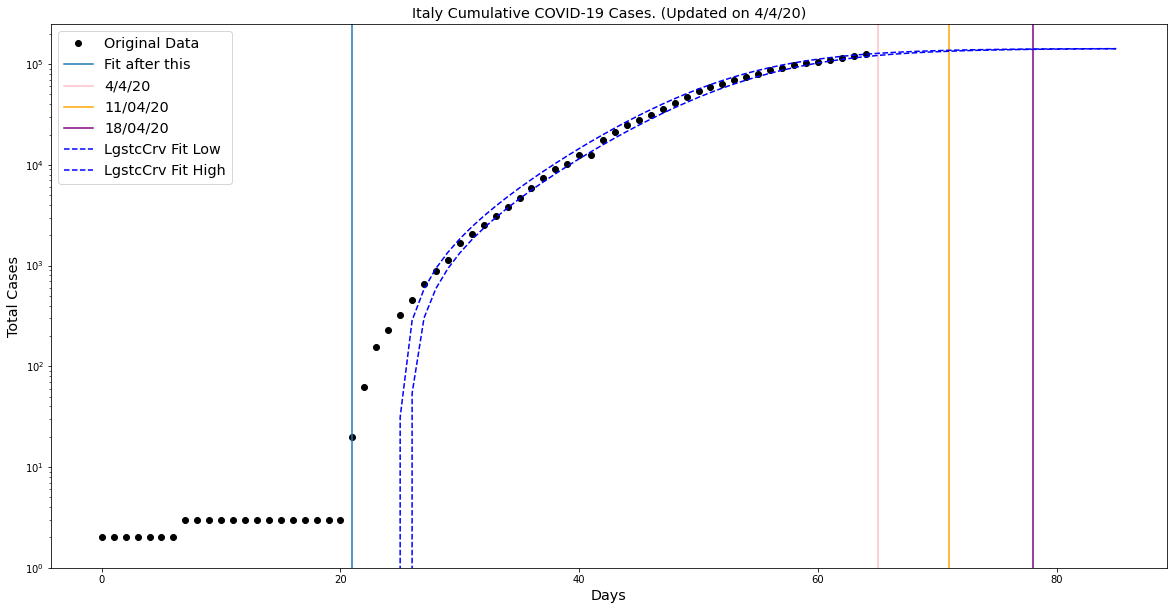



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 5550
	Confirmed cases on 3/28/20 	 3640
	Ratio: 1.52
	Weekly increase: 52.5 %
	Daily increase: 6.2 % per day
	Doubling Time (represents recent growth): 11.5 days

** Based on Exponential Fit **

	R^2: 0.971623237799449
	Skipping 6 days
	Doubling Time (represents overall growth):  6.48 (± 0.61 ) days


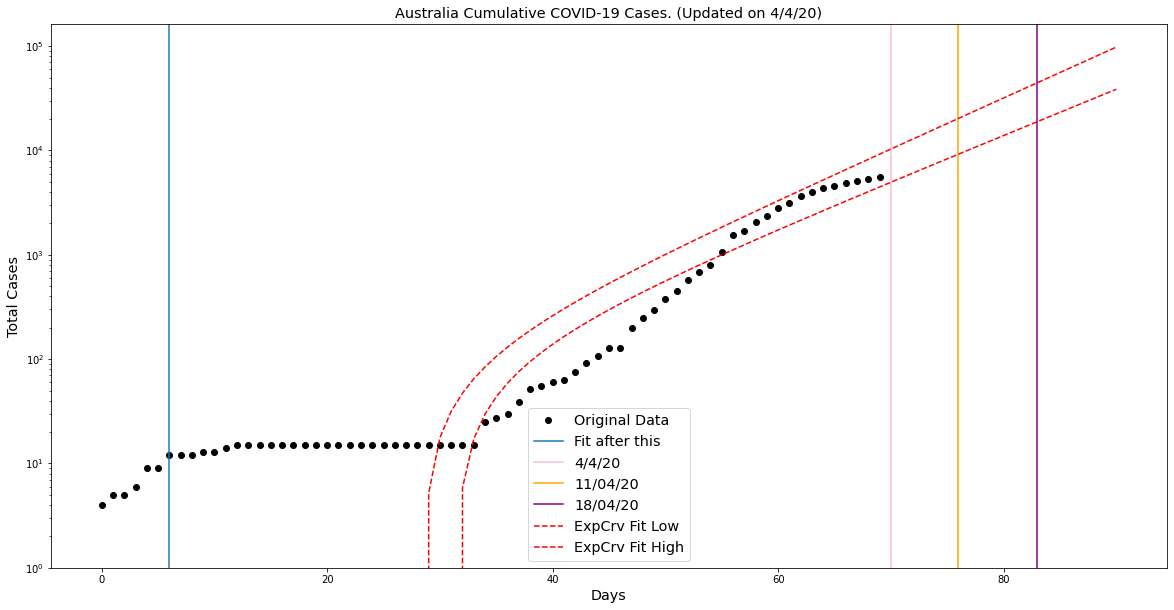

In [19]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    
    if c != "US" and c != "Australia" and c != "Italy":
        continue
    
    print(c)
        
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


   Inferred Doubling Time  95%CI  Recent Doubling Time
0                     4.4    0.2                   5.2
1                     8.3    0.3                  16.3
2                     6.5    0.6                  11.5




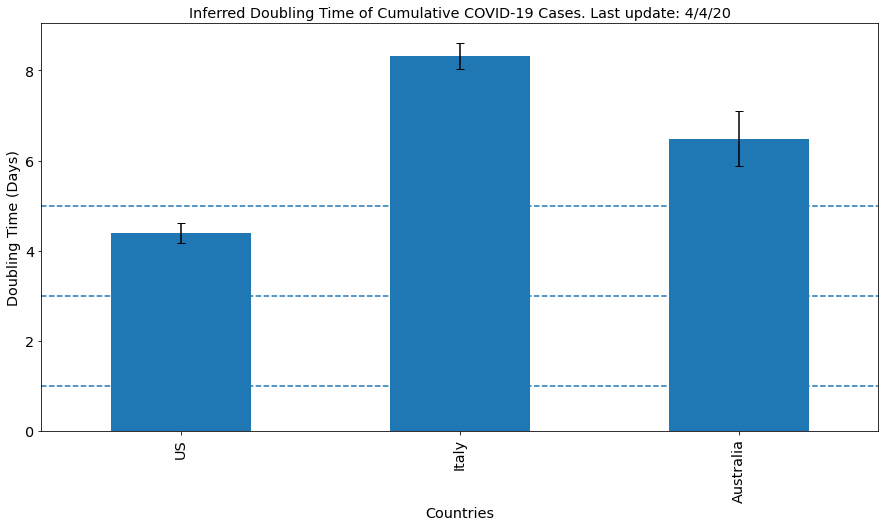

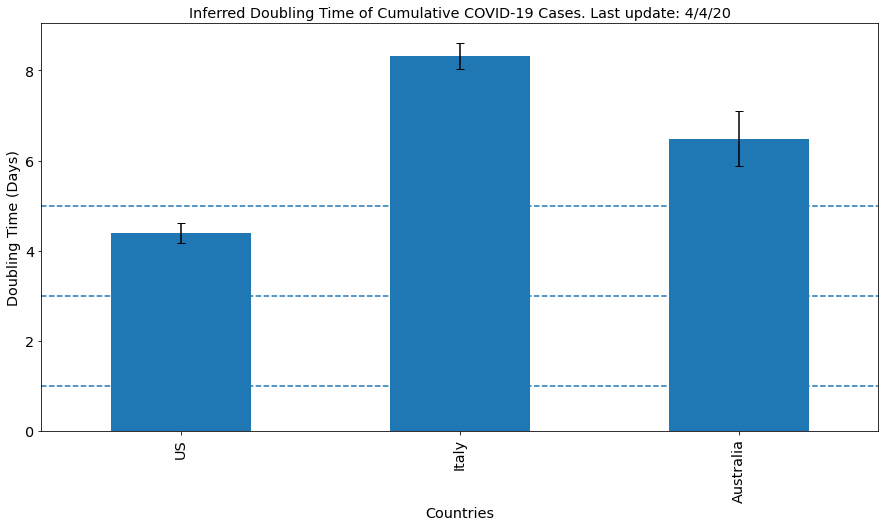

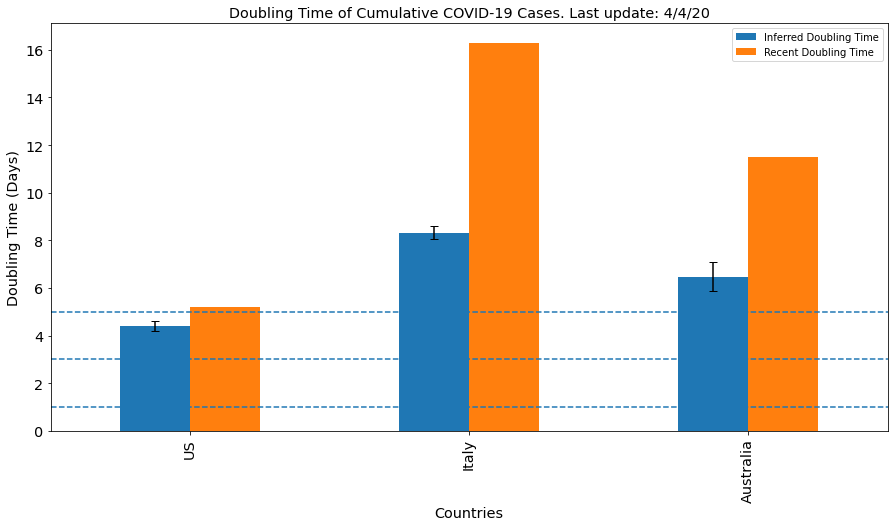

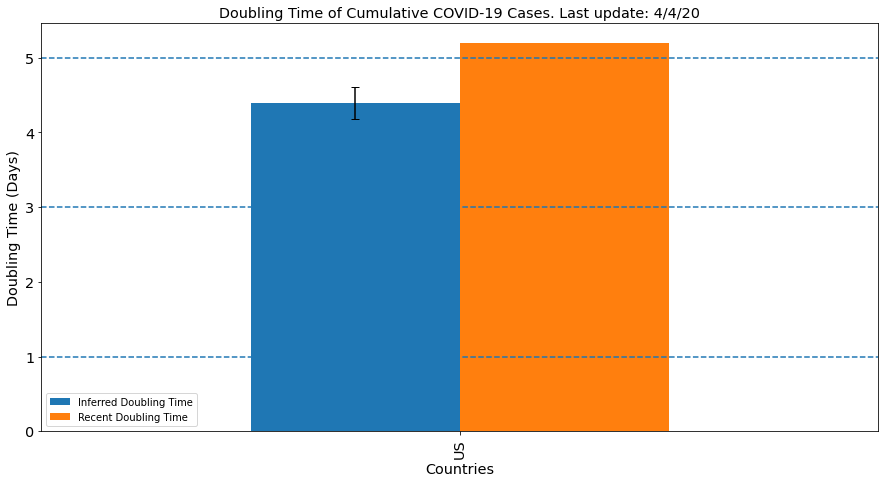

In [20]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [15]:
uscases = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')

# For some reason they change column names, change them back.
uscases.rename(columns={
    'Country_Region':'Country/Region',
    'Province_State':'Province/State',
    'Long_':'Long'
}, inplace=True)


# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

# global
# Province/State,Country/Region,Lat,Long,1/22/20

# US
# UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/2020

# Province/State  Country/Region      Lat     Long  1/22/20
uscases = uscases.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key'])

usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()

mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]



print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 4/4/20


4/4/20
Province/State                  
New York                  113833
New Jersey                 34124
Michigan                   14225
California                 12837
Louisiana                  12496
Massachusetts              11736
Florida                    11545
Pennsylvania               10444
Illinois                   10357
Washington                  7247
Texas                       6556
Georgia                     6160
Connecticut                 5276
Colorado                    4188
Indiana                     3953
Ohio                        3739
Tennessee                   3322
Maryland                    3125
North Carolina              2486
Virginia                    2407
Missouri                    2310
Arizona                     2187
Wisconsin                   2030
South Carolina              1917
Nevada                      1742
Alabama                     1614
Mississippi                 1455
Utah                        1432
Oklahoma                    1161
Idaho                       1022
Kentucky                     917
District of Columbia         902
Oregon                       899
Minnesota                    865
Rhode Island                 806
Iowa                         787
Arkansas                     743
Kansas                       698
Delaware                     593
New Hampshire                540
New Mexico                   534
Vermont                      461
Maine                        456
Puerto Rico                  452
Hawaii                       351
Nebraska                     321
West Virginia                282
Montana                      265
South Dakota                 212
Wyoming                      187
North Dakota                 186
Alaska                       171
Grand Princess               103
Guam                          93
Diamond Princess              49
Virgin Islands                40
Northern Mariana Islands       6

## US COVID-19 Deaths Analysis

In [16]:
usdeaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

# For some reason they change column names, change them back.
usdeaths.rename(columns={
    'Country_Region':'Country/Region',
    'Province_State':'Province/State',
    'Long_':'Long'
}, inplace=True)

# Province/State  Country/Region      Lat     Long  1/22/20
usdeaths = usdeaths.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key', 'Population'])

usdeathssummary = usdeaths.iloc[:,[0,-1]].groupby('Province/State').sum()

mostrecentdateusdeaths = usdeathssummary.columns[0]
usdeathssummary = usdeathssummary.sort_values(by = mostrecentdateusdeaths, ascending = False)
usdeathssummary = usdeathssummary[usdeathssummary[mostrecentdateusdeaths] > 0]



print('\nNumber of US COVID-19 deaths by state as of', mostrecentdateusdeaths)
usdeathssummary


Number of US COVID-19 deaths by state as of 4/4/20


4/4/20
Province/State                  
New York                    3565
New Jersey                   846
Michigan                     540
Louisiana                    409
Washington                   315
California                   289
Illinois                     244
Massachusetts                216
Georgia                      201
Florida                      195
Connecticut                  165
Pennsylvania                 136
Texas                        116
Indiana                      116
Colorado                     111
Ohio                         102
Maryland                      54
Wisconsin                     54
Virginia                      52
Arizona                       52
Tennessee                     50
Nevada                        46
Alabama                       44
Oklahoma                      42
Kentucky                      40
South Carolina                40
Mississippi                   35
North Carolina                34
Missouri                      33
Minnesota                     24
Oregon                        22
Kansas                        21
District of Columbia          21
Vermont                       20
Puerto Rico                   18
Rhode Island                  17
Arkansas                      14
Iowa                          14
Delaware                      14
Maine                         10
New Mexico                    10
Idaho                         10
Utah                           8
New Hampshire                  7
Montana                        6
Nebraska                       6
Alaska                         5
Guam                           4
Grand Princess                 3
Hawaii                         3
North Dakota                   3
South Dakota                   2
West Virginia                  2
Northern Mariana Islands       1

## Curve Fitting US COVID-19 Cases

                      4/4/20
Province/State              
New York              113833
New Jersey             34124
Michigan               14225
California             12837
Louisiana              12496
Massachusetts          11736
Florida                11545
Pennsylvania           10444
Illinois               10357
Washington              7247
Texas                   6556
Georgia                 6160
Connecticut             5276
Colorado                4188
Indiana                 3953
Ohio                    3739
Tennessee               3322
Maryland                3125
North Carolina          2486
Virginia                2407
Missouri                2310
Arizona                 2187
Wisconsin               2030
South Carolina          1917
Nevada                  1742
Alabama                 1614
Mississippi             1455
Utah                    1432
Oklahoma                1161
Idaho                   1022
Kentucky                 917
District of Columbia     902
Oregon        

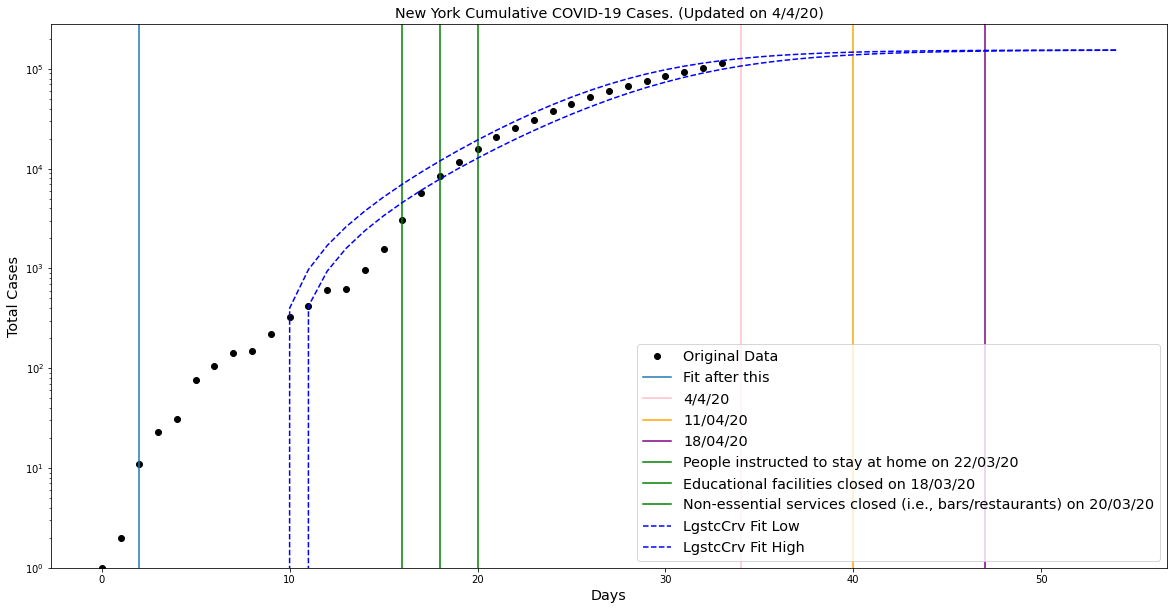

US state deaths:  New York

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 3565
	Confirmed cases on 3/28/20 	 728
	Ratio: 4.9
	Weekly increase: 389.7 %
	Daily increase: 25.5 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.9996945566617056
	Skipping 3 days
	Doubling Time (during middle of growth):  5.03 (± 0.31 ) days

** Based on Exponential Fit **

	R^2: 0.9982633610076482
	Skipping 3 days
	Doubling Time (represents overall growth):  3.25 (± 0.17 ) days


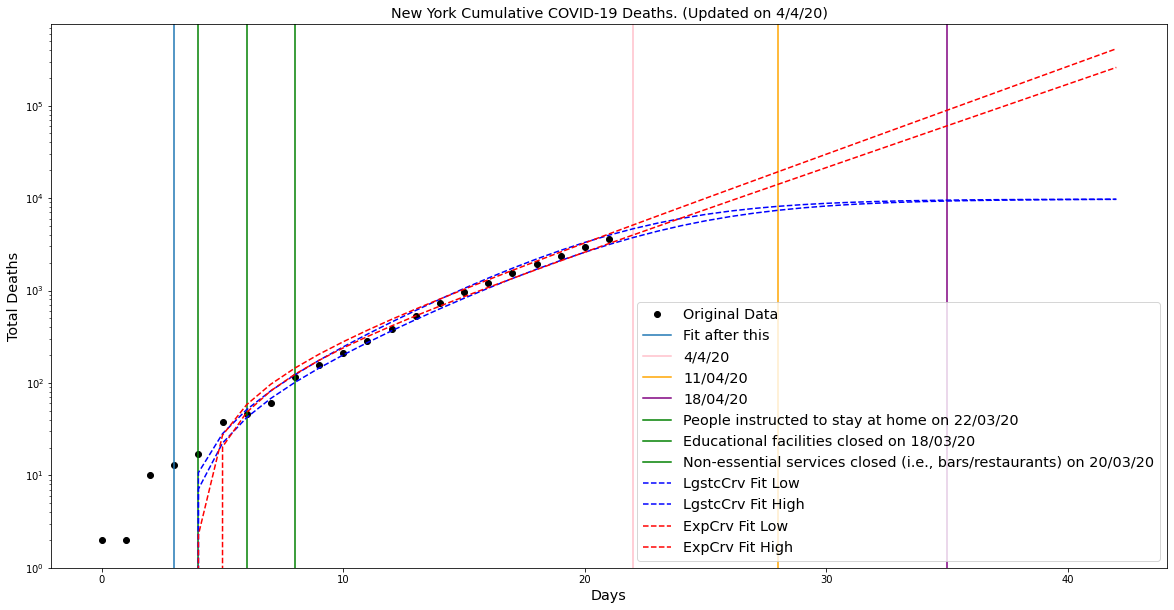



US state:  New Jersey

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 34124
	Confirmed cases on 3/28/20 	 11124
	Ratio: 3.07
	Weekly increase: 206.8 %
	Daily increase: 17.4 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.998583876156855
	Skipping 5 days
	Doubling Time (during middle of growth):  5.24 (± 0.48 ) days

** Based on Exponential Fit **

	R^2: 0.9862993601851715
	Skipping 5 days
	Doubling Time (represents overall growth):  3.51 (± 0.42 ) days


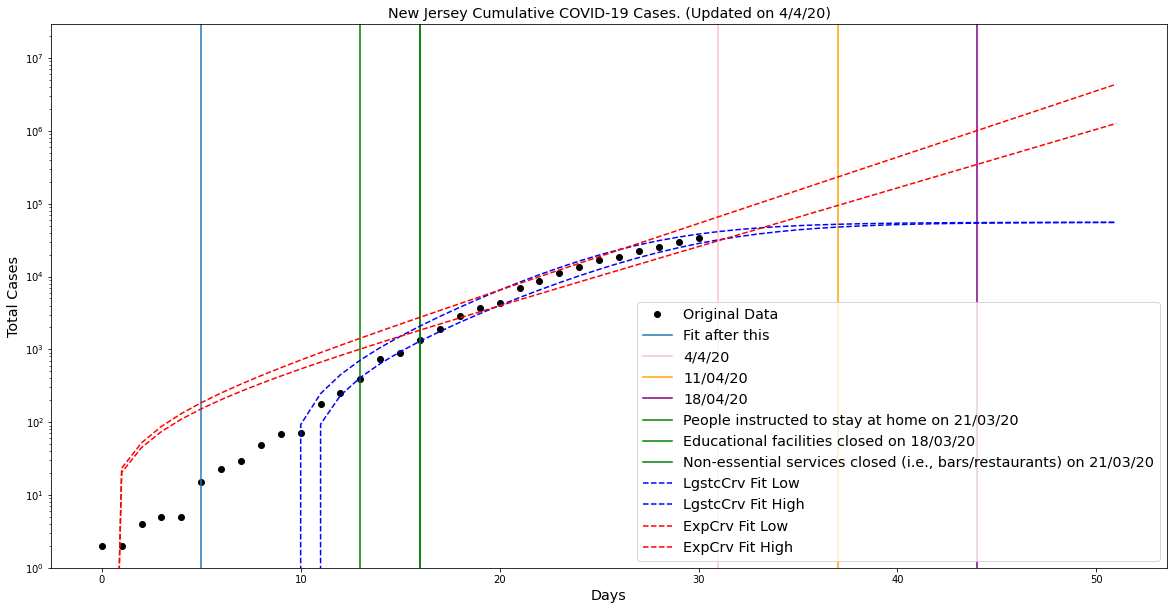

US state deaths:  New Jersey

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 846
	Confirmed cases on 3/28/20 	 140
	Ratio: 6.04
	Weekly increase: 504.3 %
	Daily increase: 29.3 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Exponential Fit **

	R^2: 0.9970492456842561
	Skipping 10 days
	Doubling Time (represents overall growth):  2.53 (± 0.22 ) days


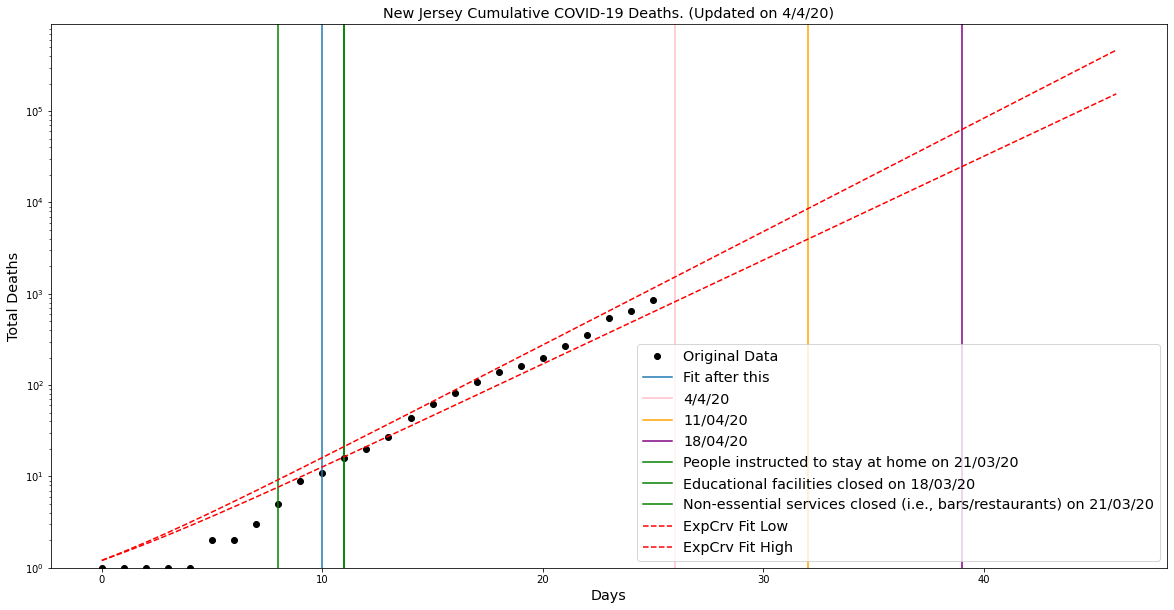



US state:  Michigan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 14225
	Confirmed cases on 3/28/20 	 4650
	Ratio: 3.06
	Weekly increase: 205.9 %
	Daily increase: 17.3 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.9991243190395531
	Skipping 2 days
	Doubling Time (during middle of growth):  5.99 (± 0.54 ) days

** Based on Exponential Fit **

	R^2: 0.981571423704538
	Skipping 2 days
	Doubling Time (represents overall growth):  3.29 (± 0.49 ) days


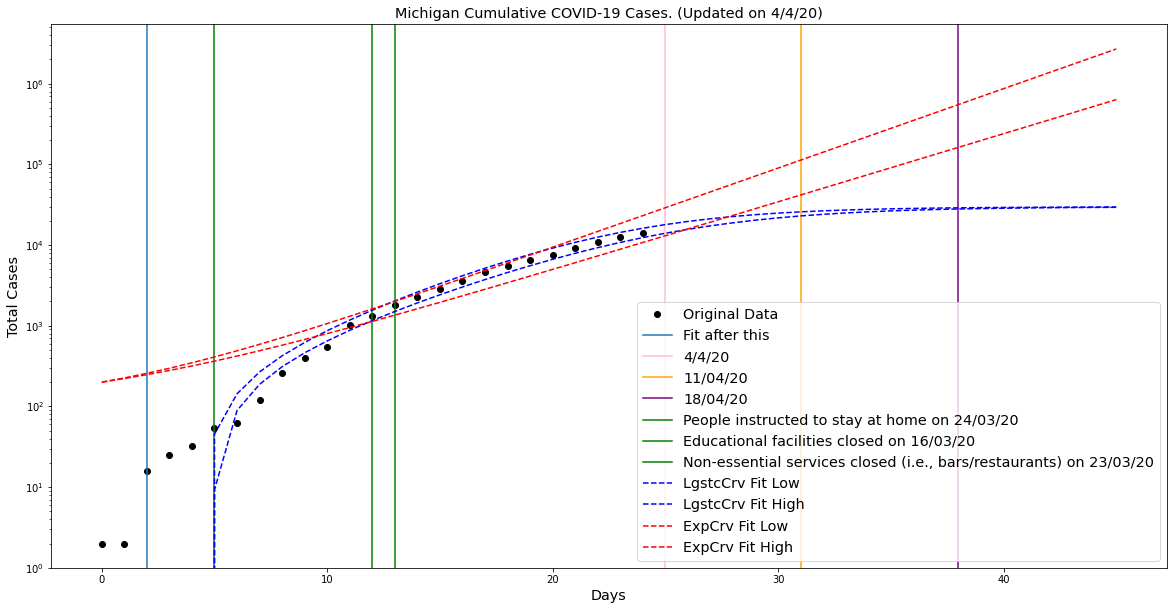

US state deaths:  Michigan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 540
	Confirmed cases on 3/28/20 	 111
	Ratio: 4.86
	Weekly increase: 386.5 %
	Daily increase: 25.4 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.9967923031148277
	Skipping 5 days
	Doubling Time (during middle of growth):  3.26 (± 0.67 ) days

** Based on Exponential Fit **

	R^2: 0.9802552353263738
	Skipping 5 days
	Doubling Time (represents overall growth):  4.38 (± 1.09 ) days


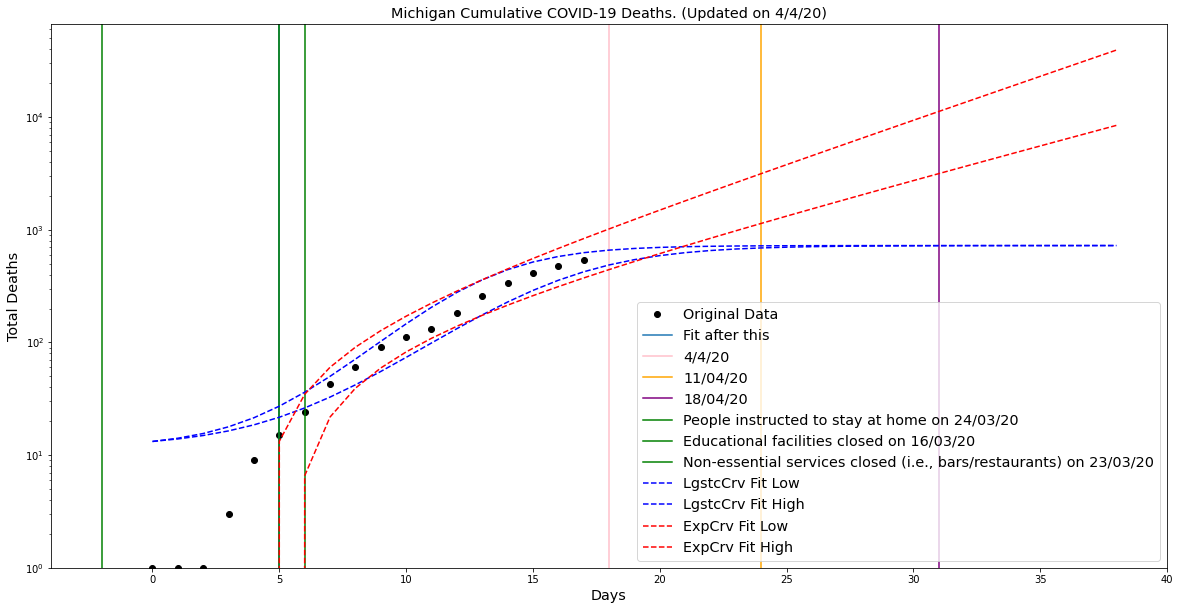



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 12837
	Confirmed cases on 3/28/20 	 5095
	Ratio: 2.52
	Weekly increase: 152.0 %
	Daily increase: 14.1 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Exponential Fit **

	R^2: 0.994604031944441
	Skipping 32 days
	Doubling Time (represents overall growth):  4.79 (± 0.29 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


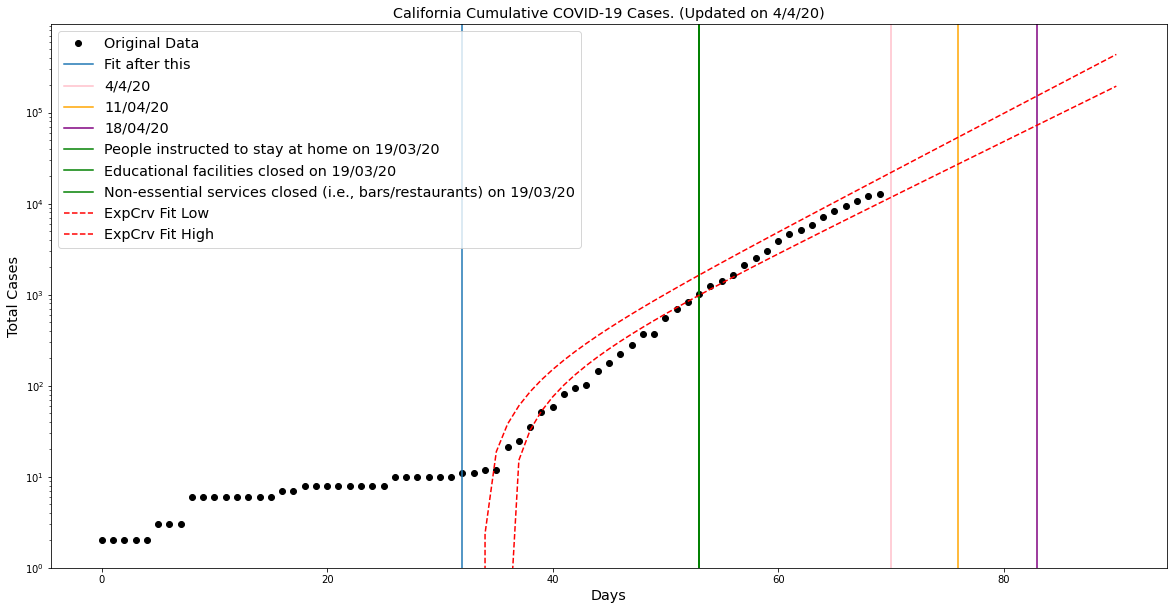

US state deaths:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 289
	Confirmed cases on 3/28/20 	 110
	Ratio: 2.63
	Weekly increase: 162.7 %
	Daily increase: 14.8 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Exponential Fit **

	R^2: 0.9829922545825086
	Skipping 13 days
	Doubling Time (represents overall growth):  5.58 (± 0.57 ) days


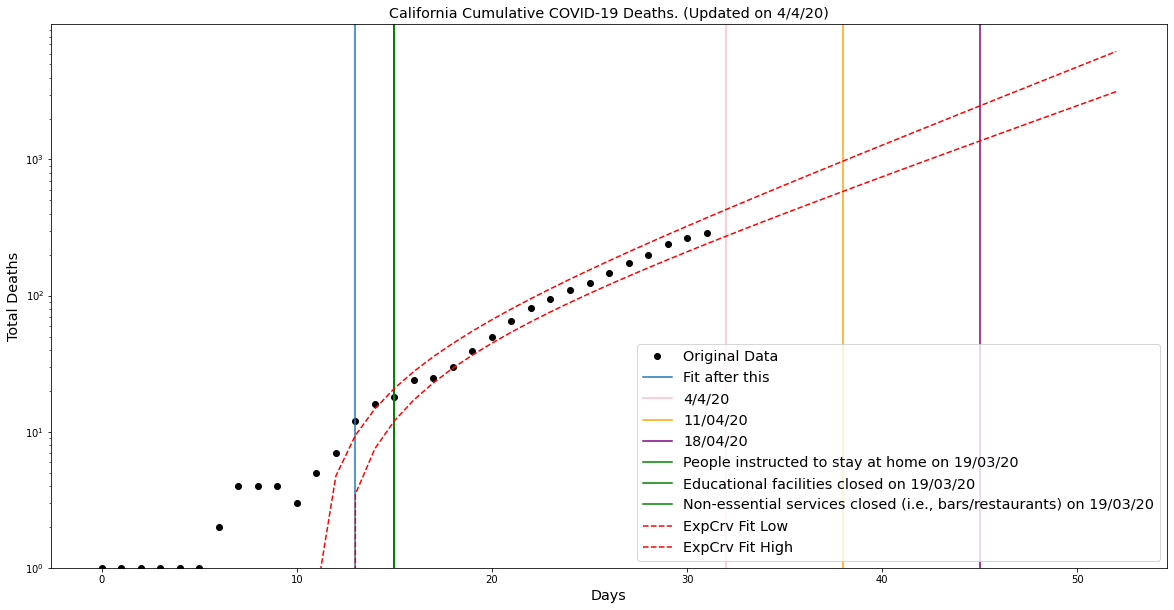



US state:  Louisiana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 12496
	Confirmed cases on 3/28/20 	 3315
	Ratio: 3.77
	Weekly increase: 277.0 %
	Daily increase: 20.9 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9947146575838335
	Skipping 1 days
	Doubling Time (during middle of growth):  6.92 (± 1.26 ) days

** Based on Exponential Fit **

	R^2: 0.9947043804789522
	Skipping 1 days
	Doubling Time (represents overall growth):  3.44 (± 0.26 ) days


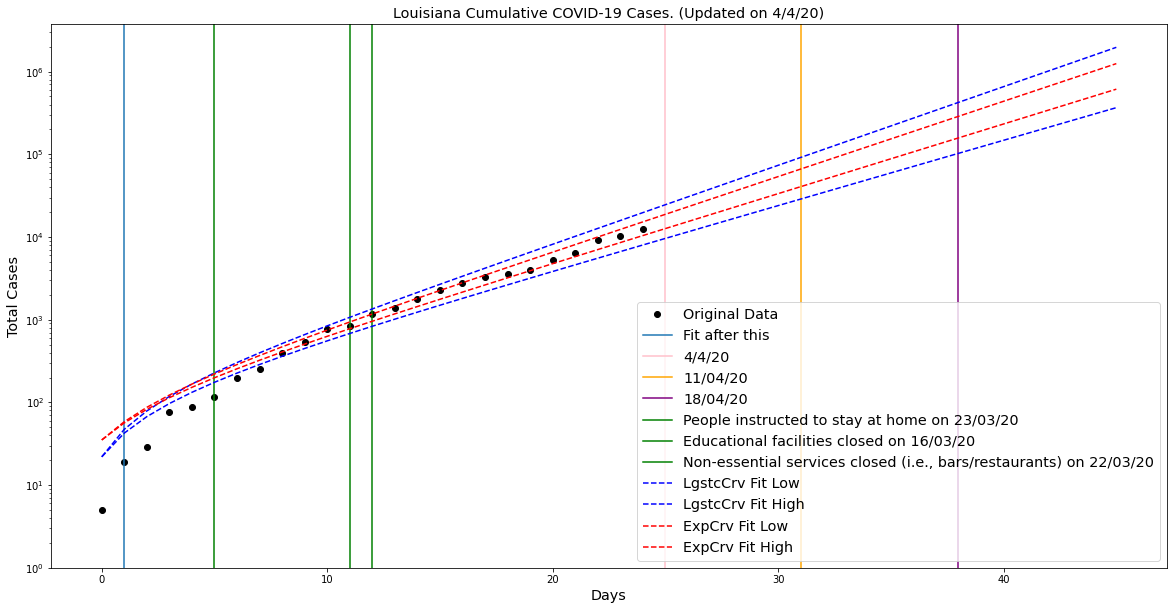

US state deaths:  Louisiana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 409
	Confirmed cases on 3/28/20 	 137
	Ratio: 2.99
	Weekly increase: 198.5 %
	Daily increase: 16.9 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Exponential Fit **

	R^2: 0.9847502281027932
	Skipping 6 days
	Doubling Time (represents overall growth):  5.6 (± 0.78 ) days


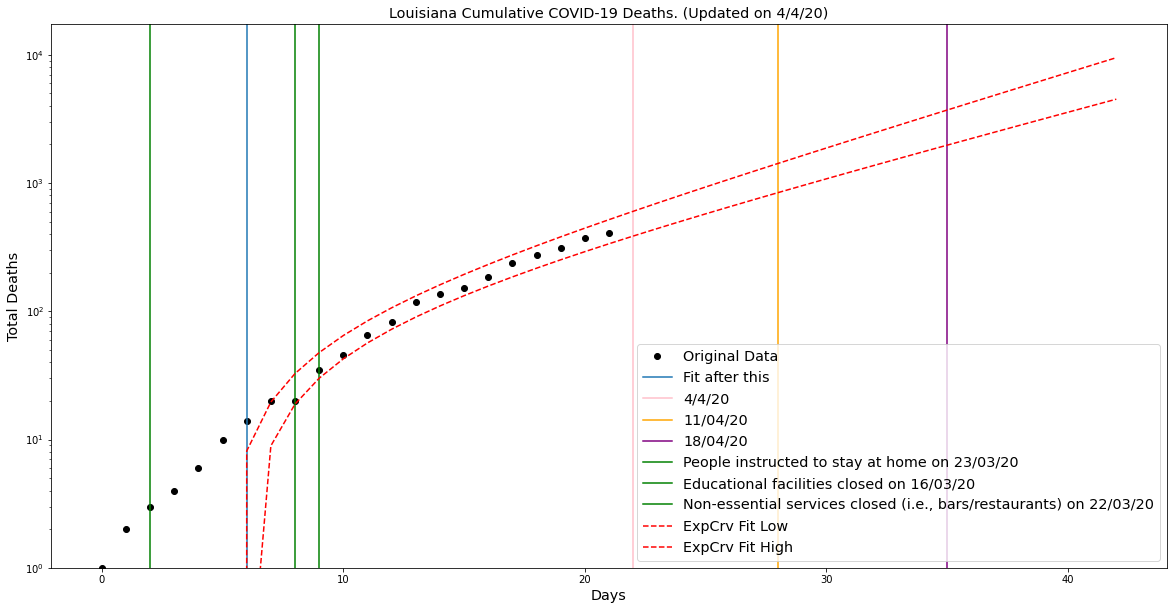



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 11736
	Confirmed cases on 3/28/20 	 4257
	Ratio: 2.76
	Weekly increase: 175.7 %
	Daily increase: 15.6 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Exponential Fit **

	R^2: 0.9902408868560522
	Skipping 36 days
	Doubling Time (represents overall growth):  4.01 (± 0.43 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


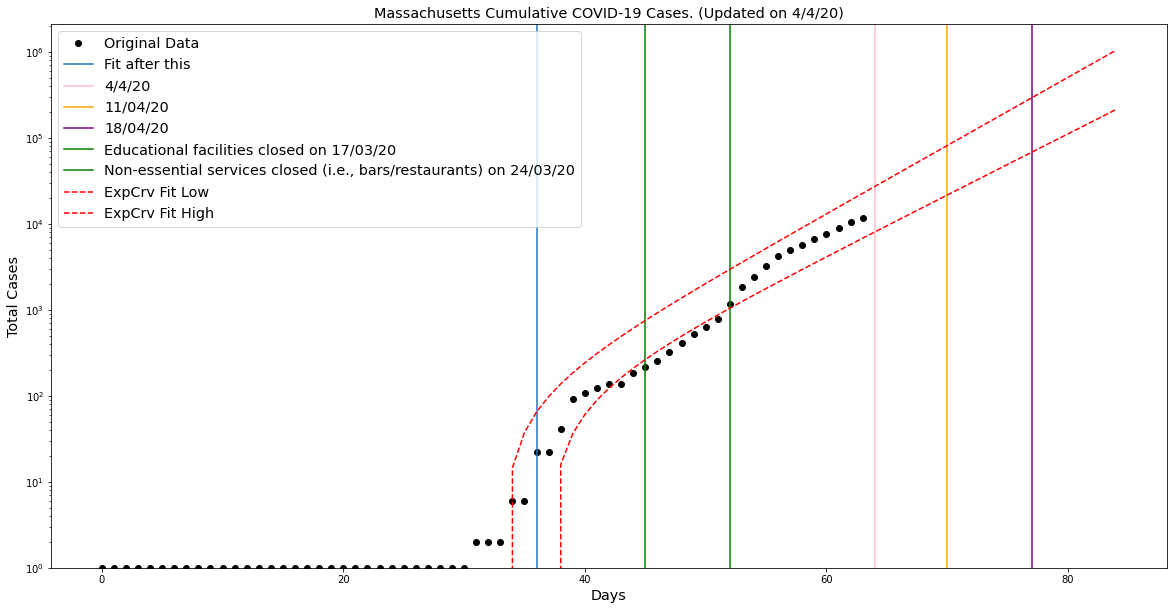

US state deaths:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 216
	Confirmed cases on 3/28/20 	 44
	Ratio: 4.91
	Weekly increase: 390.9 %
	Daily increase: 25.5 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.9891518636699711
	Skipping 4 days
	Doubling Time (during middle of growth):  2.83 (± 0.93 ) days

** Based on Exponential Fit **

	R^2: 0.9896444771116841
	Skipping 4 days
	Doubling Time (represents overall growth):  3.46 (± 0.92 ) days


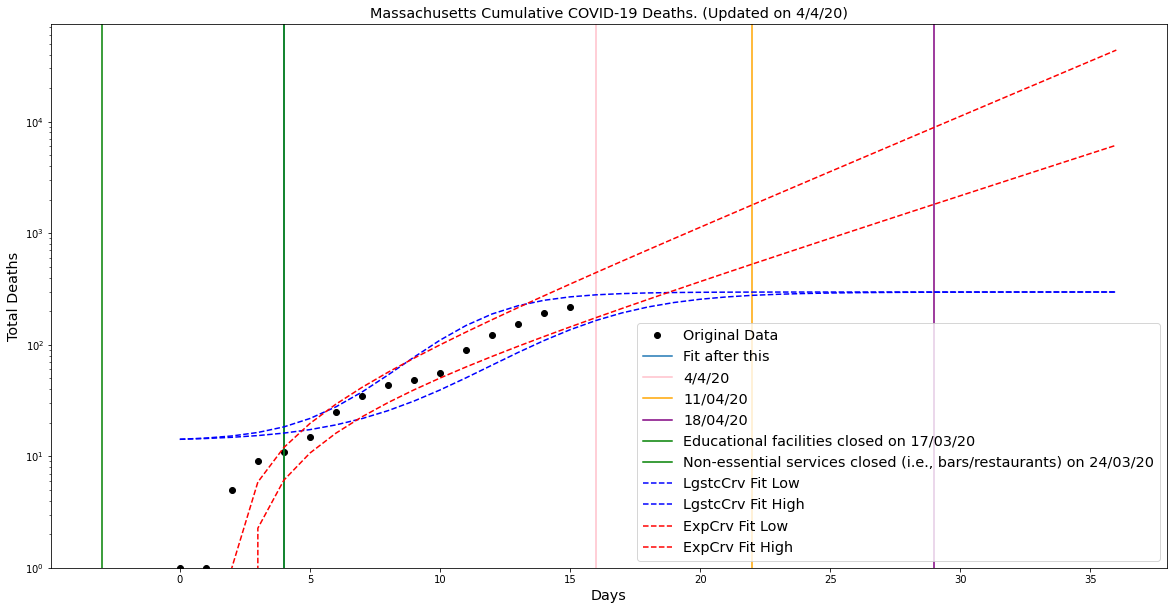



US state:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 11545
	Confirmed cases on 3/28/20 	 3763
	Ratio: 3.07
	Weekly increase: 206.8 %
	Daily increase: 17.4 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.9979682600437846
	Skipping 7 days
	Doubling Time (during middle of growth):  5.72 (± 0.7 ) days

** Based on Exponential Fit **

	R^2: 0.9935469191790329
	Skipping 7 days
	Doubling Time (represents overall growth):  3.95 (± 0.34 ) days


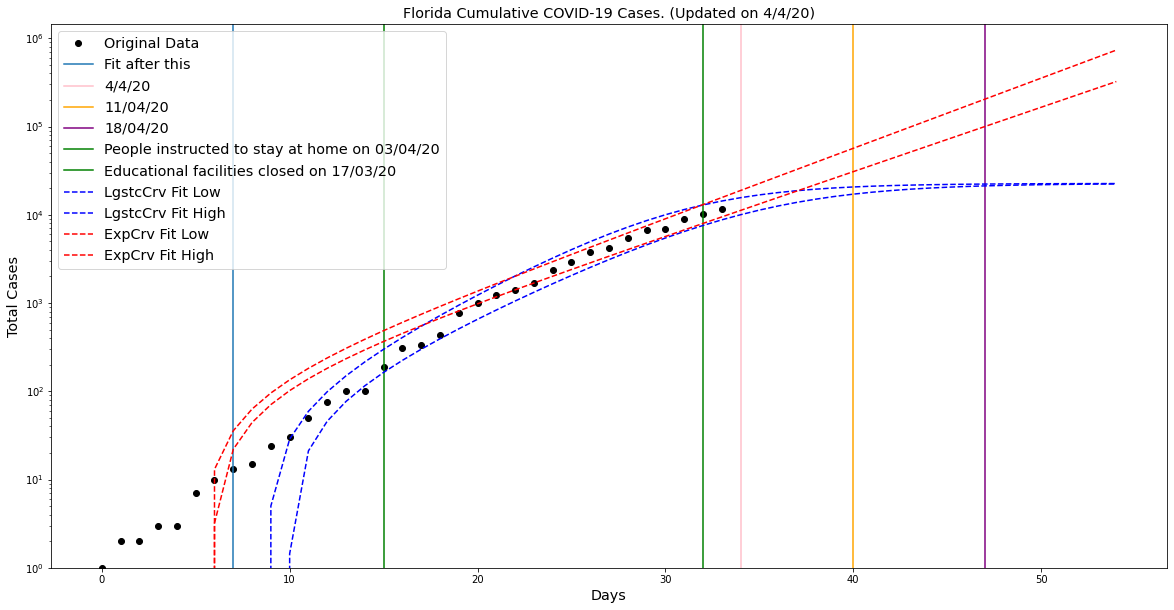

US state deaths:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 195
	Confirmed cases on 3/28/20 	 54
	Ratio: 3.61
	Weekly increase: 261.1 %
	Daily increase: 20.1 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Exponential Fit **

	R^2: 0.9798462606575723
	Skipping 12 days
	Doubling Time (represents overall growth):  3.22 (± 0.88 ) days


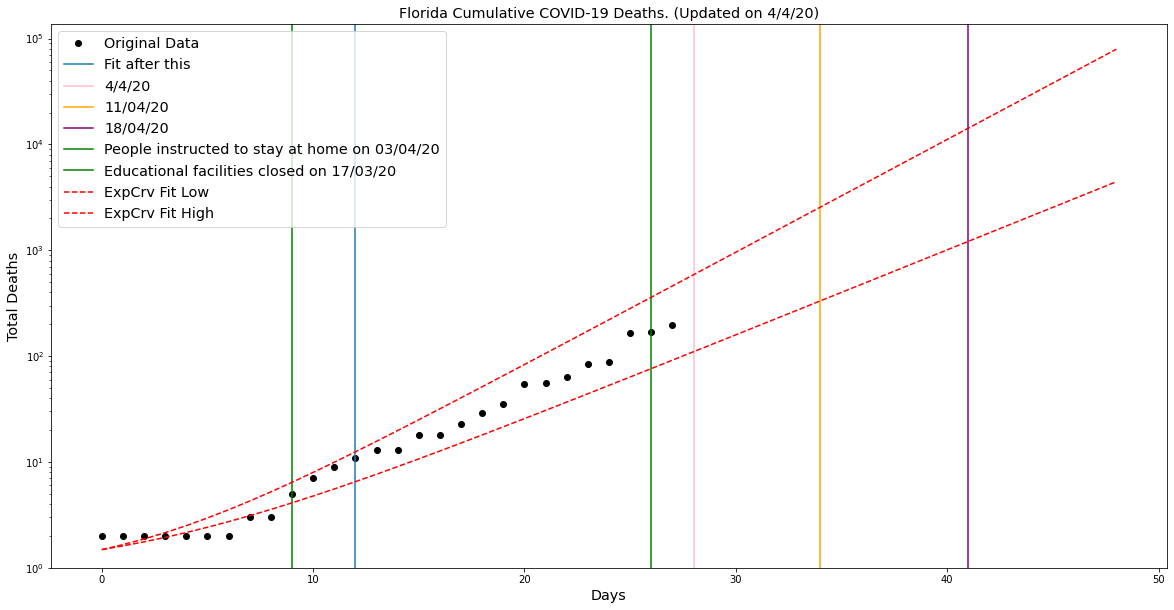



US state:  Pennsylvania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 10444
	Confirmed cases on 3/28/20 	 2845
	Ratio: 3.67
	Weekly increase: 267.1 %
	Daily increase: 20.4 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9988307934704364
	Skipping 4 days
	Doubling Time (during middle of growth):  6.11 (± 0.6 ) days

** Based on Exponential Fit **

	R^2: 0.9974679905372599
	Skipping 4 days
	Doubling Time (represents overall growth):  3.58 (± 0.18 ) days


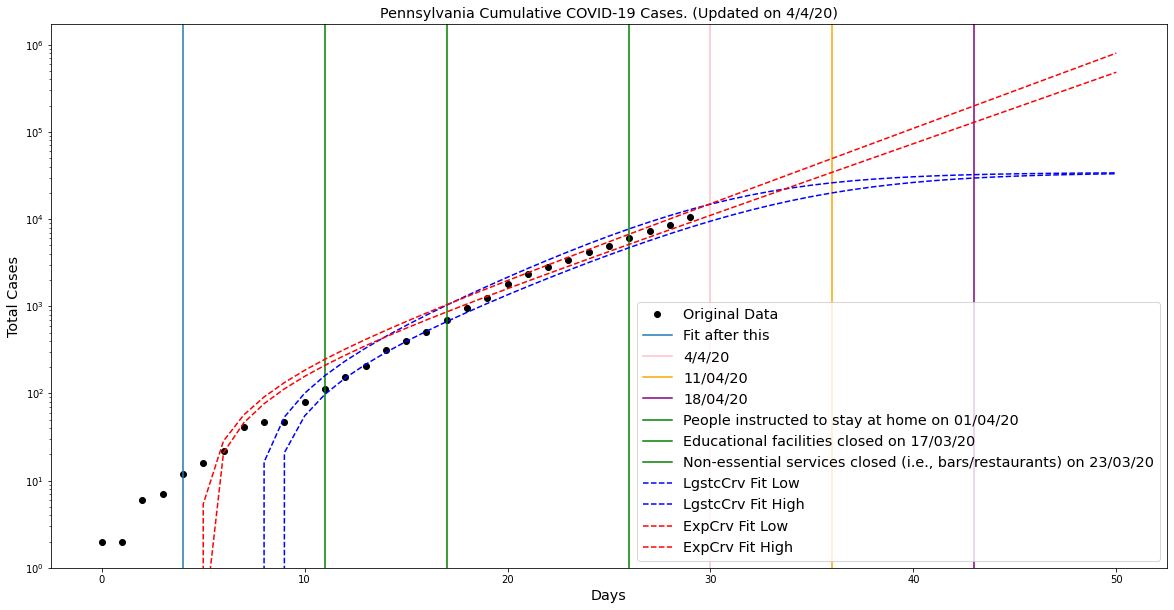

US state deaths:  Pennsylvania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 136
	Confirmed cases on 3/28/20 	 34
	Ratio: 4.0
	Weekly increase: 300.0 %
	Daily increase: 21.9 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Exponential Fit **

	R^2: 0.9954481773957262
	Skipping 7 days
	Doubling Time (represents overall growth):  4.02 (± 0.99 ) days


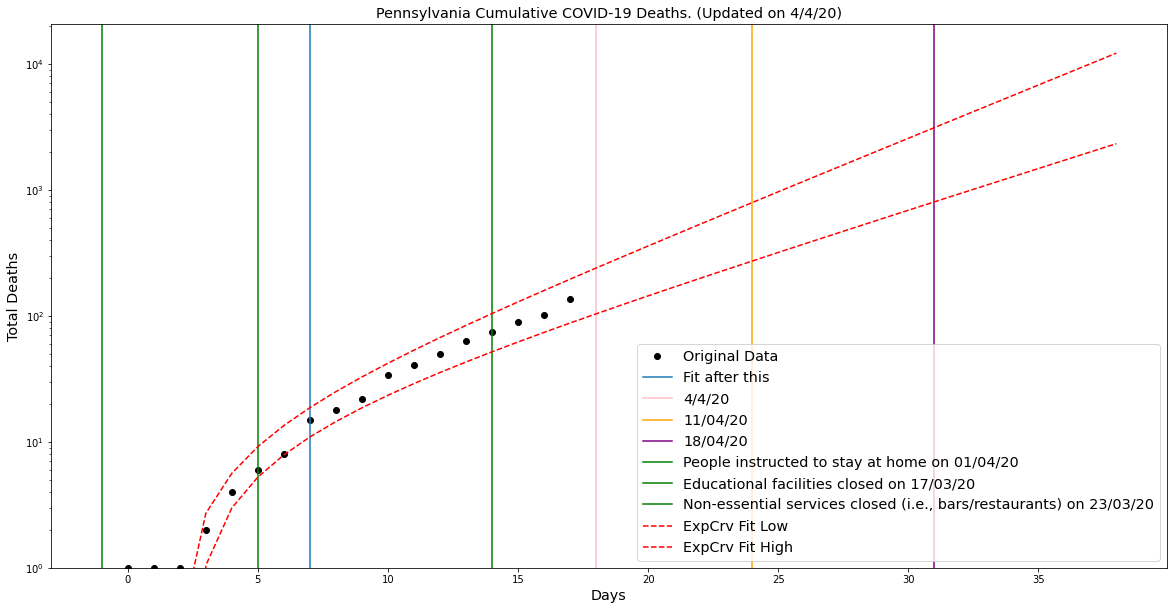



US state:  Illinois

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 10357
	Confirmed cases on 3/28/20 	 3491
	Ratio: 2.97
	Weekly increase: 196.7 %
	Daily increase: 16.8 % per day
	Doubling Time (represents recent growth): 4.5 days

** Based on Exponential Fit **

	R^2: 0.9936696482218367
	Skipping 46 days
	Doubling Time (represents overall growth):  4.29 (± 0.41 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


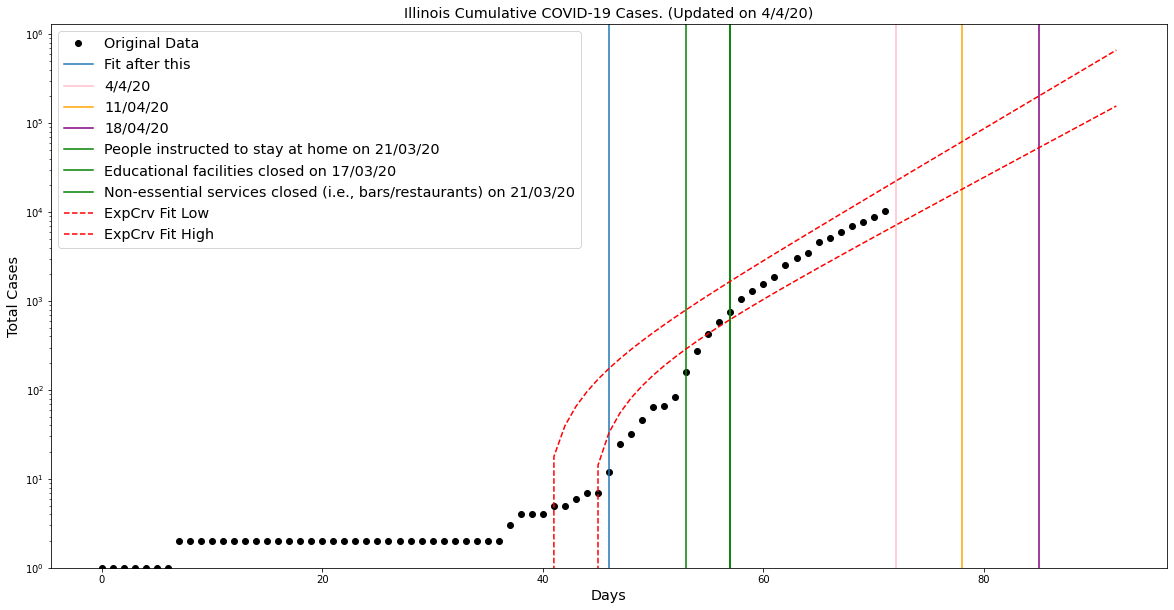

US state deaths:  Illinois

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 244
	Confirmed cases on 3/28/20 	 47
	Ratio: 5.19
	Weekly increase: 419.1 %
	Daily increase: 26.5 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.9924820252137129
	Skipping 6 days
	Doubling Time (represents overall growth):  3.45 (± 0.54 ) days


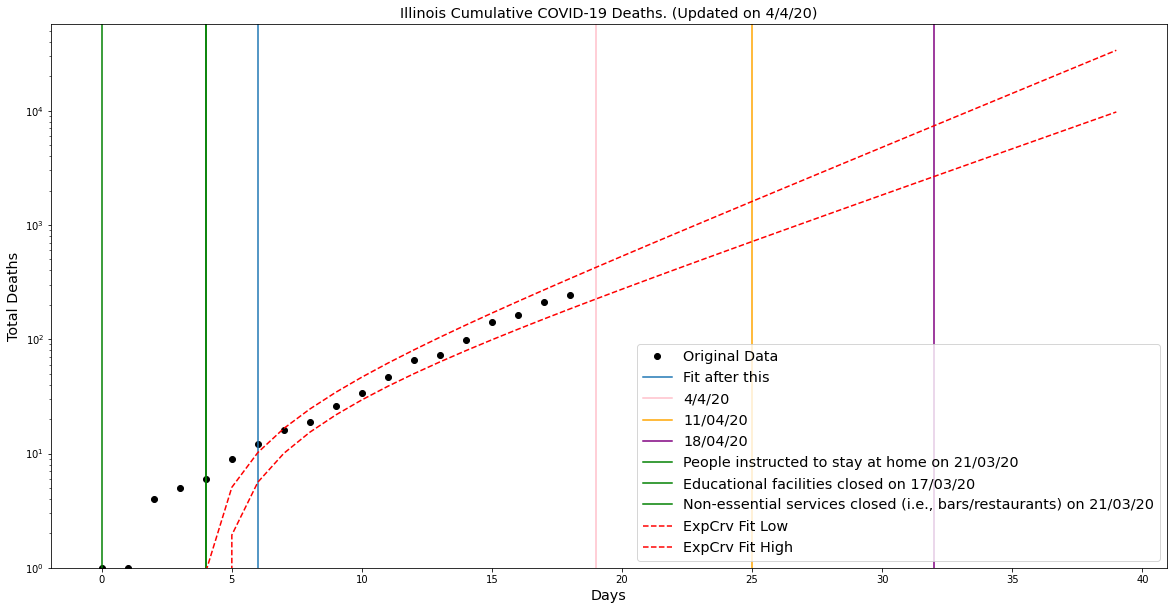



US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 7247
	Confirmed cases on 3/28/20 	 4030
	Ratio: 1.8
	Weekly increase: 79.8 %
	Daily increase: 8.7 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Exponential Fit **

	R^2: 0.9924525411606664
	Skipping 39 days
	Doubling Time (represents overall growth):  6.56 (± 0.64 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


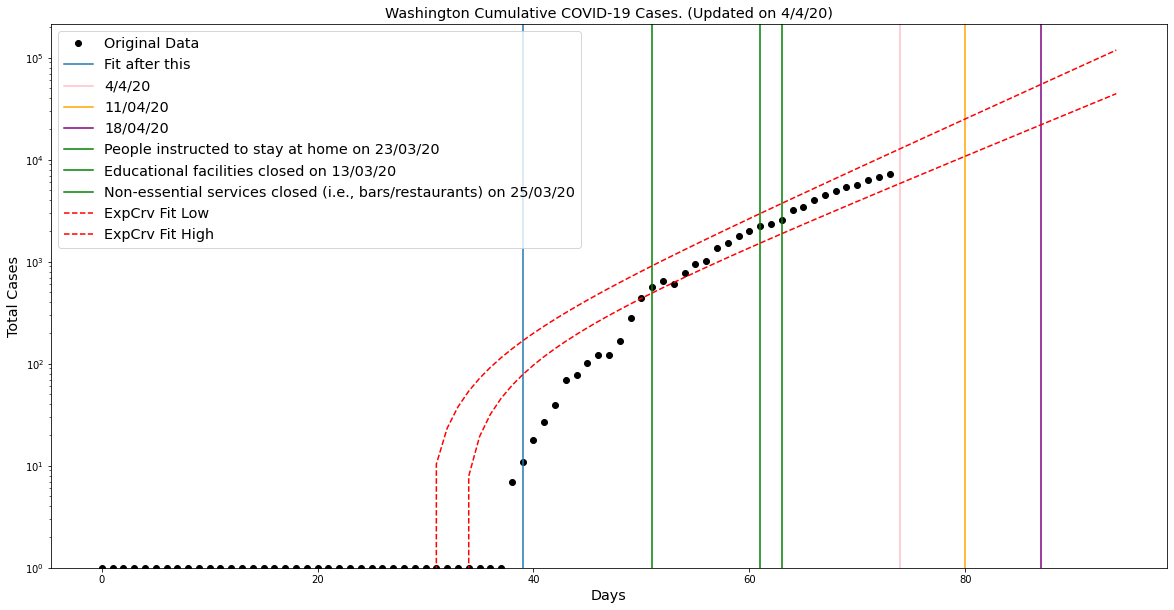

US state deaths:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 315
	Confirmed cases on 3/28/20 	 188
	Ratio: 1.68
	Weekly increase: 67.6 %
	Daily increase: 7.7 % per day
	Doubling Time (represents recent growth): 9.4 days

** Based on Exponential Fit **

	R^2: 0.997352471232424
	Skipping 5 days
	Doubling Time (represents overall growth):  9.1 (± 0.64 ) days


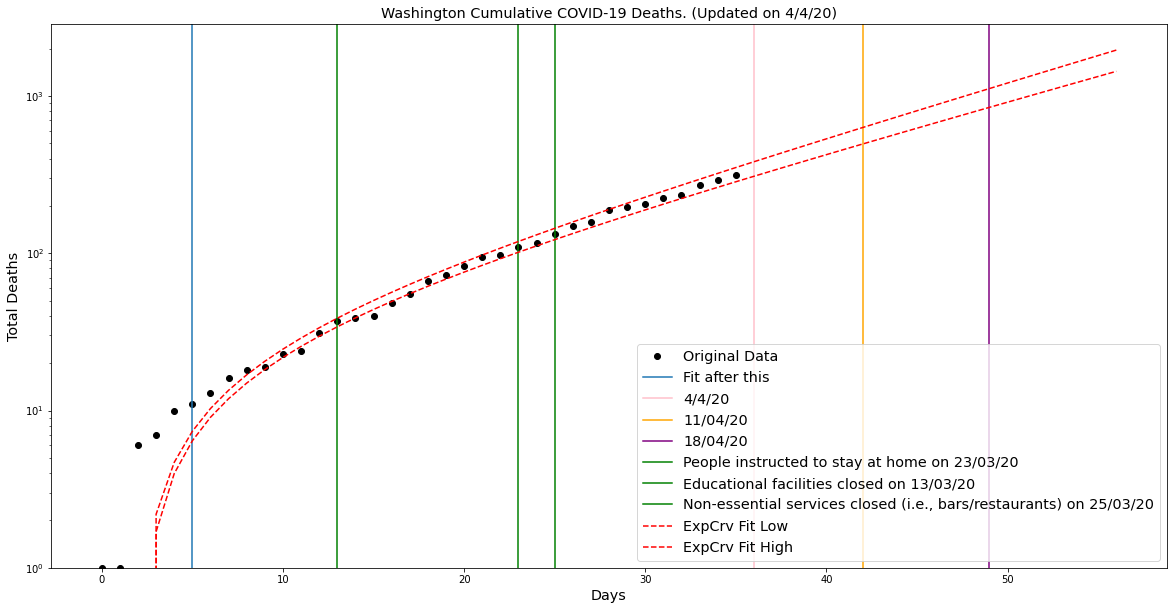



US state:  Texas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 6556
	Confirmed cases on 3/28/20 	 2455
	Ratio: 2.67
	Weekly increase: 167.0 %
	Daily increase: 15.1 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.9990945318792047
	Skipping 3 days
	Doubling Time (during middle of growth):  6.33 (± 0.49 ) days

** Based on Exponential Fit **

	R^2: 0.9947498119678551
	Skipping 3 days
	Doubling Time (represents overall growth):  4.37 (± 0.33 ) days


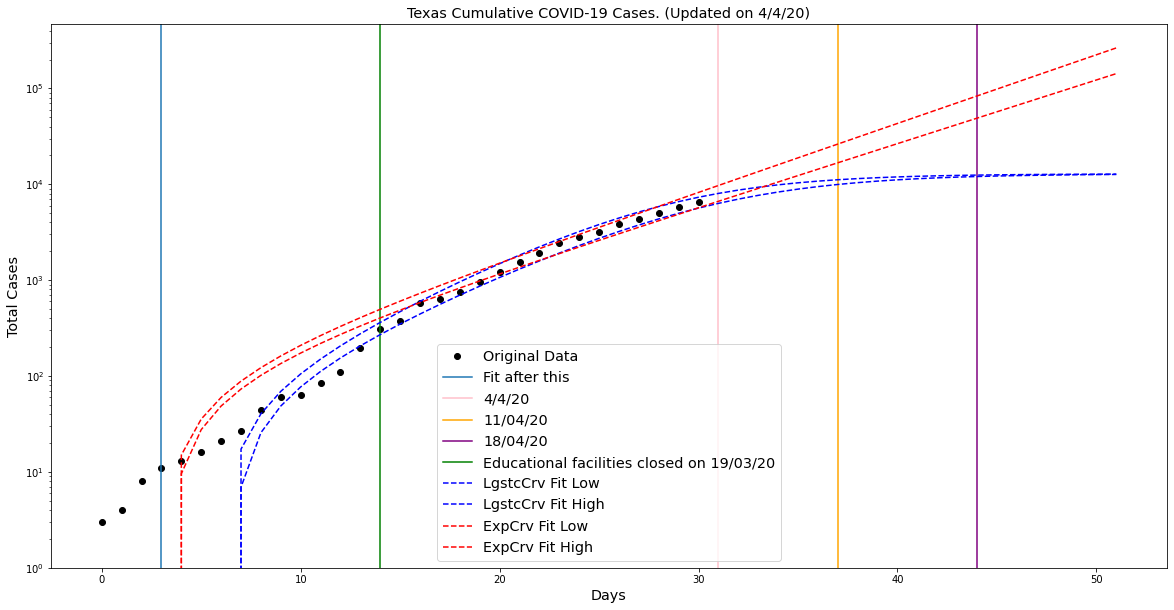

US state deaths:  Texas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 116
	Confirmed cases on 3/28/20 	 30
	Ratio: 3.87
	Weekly increase: 286.7 %
	Daily increase: 21.3 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Exponential Fit **

	R^2: 0.9984566828066642
	Skipping 7 days
	Doubling Time (represents overall growth):  3.78 (± 0.45 ) days


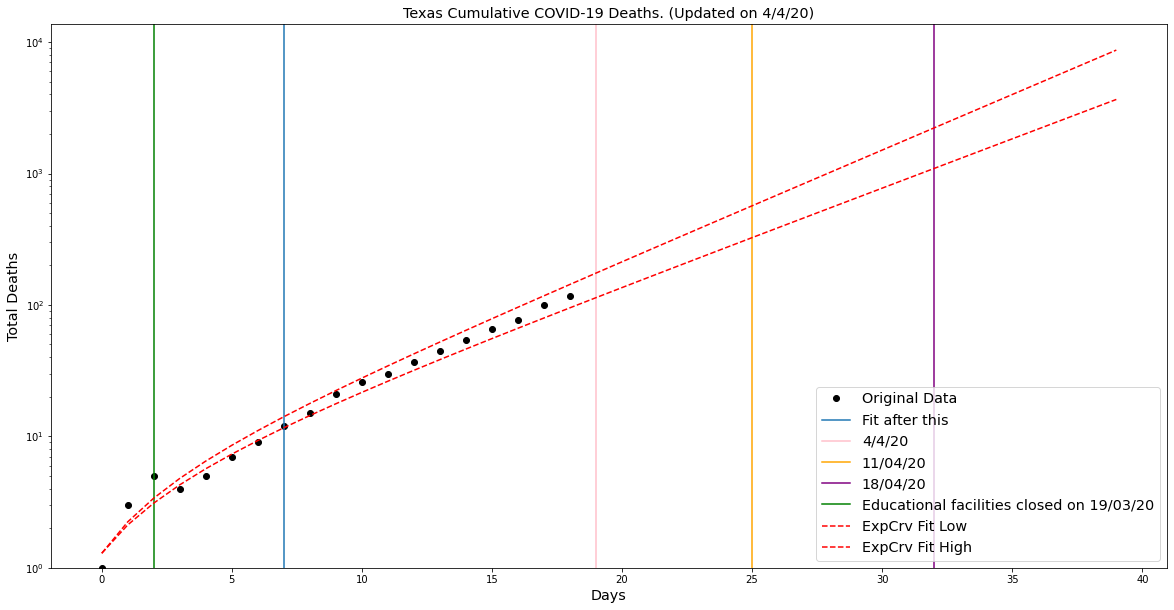



US state:  Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 6160
	Confirmed cases on 3/28/20 	 2366
	Ratio: 2.6
	Weekly increase: 160.4 %
	Daily increase: 14.6 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.9962901612632517
	Skipping 7 days
	Doubling Time (during middle of growth):  5.56 (± 0.94 ) days

** Based on Exponential Fit **

	R^2: 0.9890753932438836
	Skipping 7 days
	Doubling Time (represents overall growth):  4.43 (± 0.54 ) days


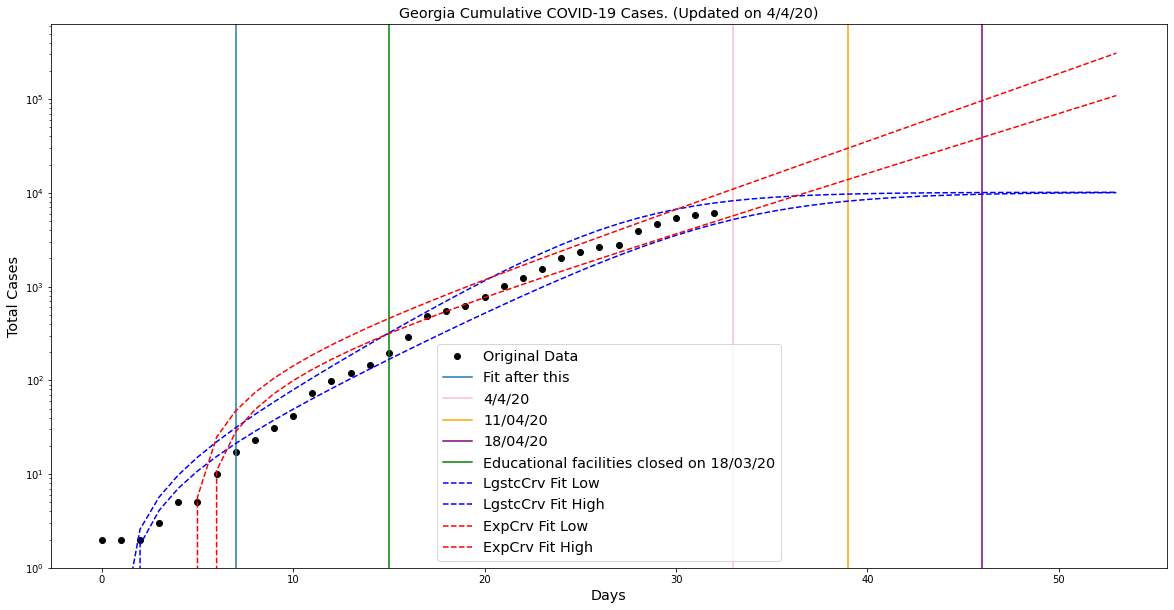

US state deaths:  Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 201
	Confirmed cases on 3/28/20 	 69
	Ratio: 2.91
	Weekly increase: 191.3 %
	Daily increase: 16.5 % per day
	Doubling Time (represents recent growth): 4.5 days

** Based on Exponential Fit **

	R^2: 0.9949937078664859
	Skipping 8 days
	Doubling Time (represents overall growth):  4.95 (± 0.84 ) days


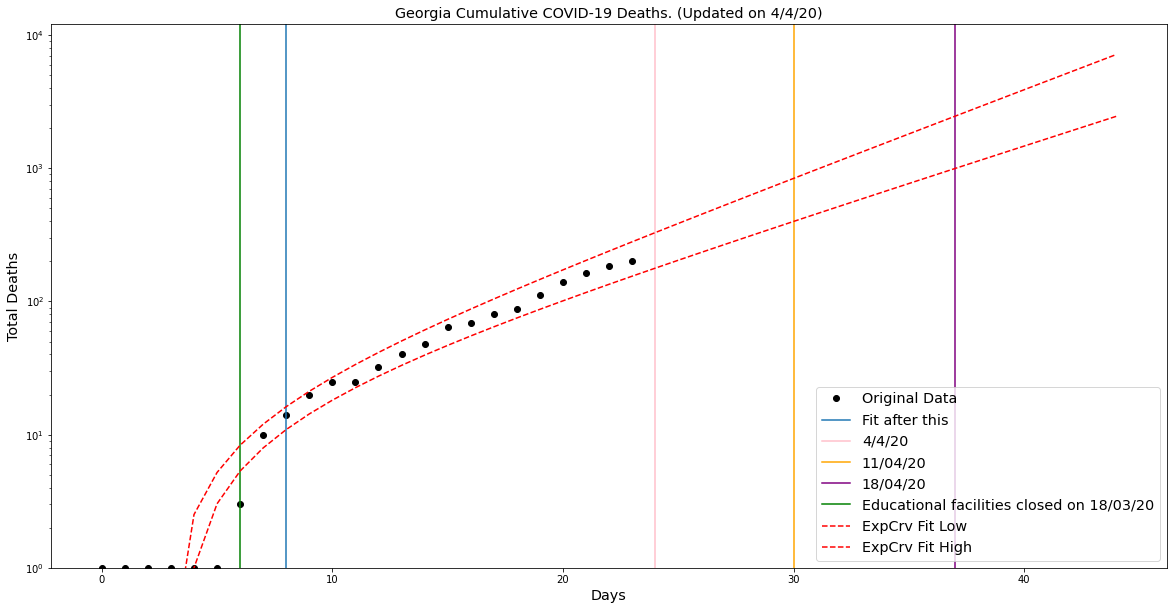



US state:  Connecticut

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 5276
	Confirmed cases on 3/28/20 	 1524
	Ratio: 3.46
	Weekly increase: 246.2 %
	Daily increase: 19.4 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.9971826318455613
	Skipping 3 days
	Doubling Time (during middle of growth):  5.1 (± 0.8 ) days

** Based on Exponential Fit **

	R^2: 0.9901593613913107
	Skipping 3 days
	Doubling Time (represents overall growth):  3.97 (± 0.49 ) days


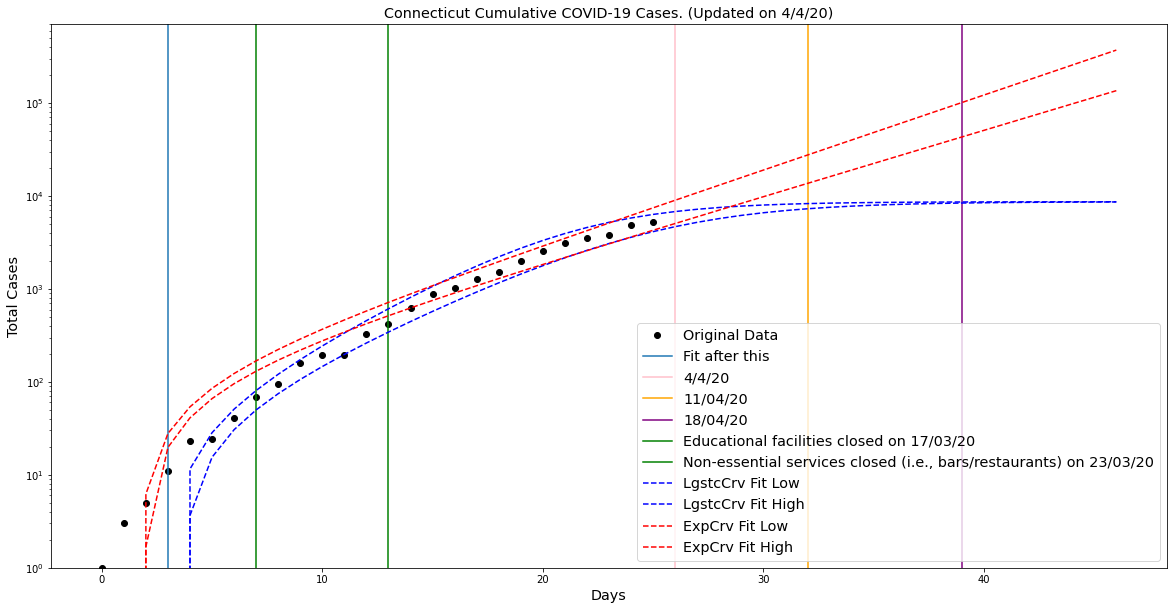

US state deaths:  Connecticut

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 165
	Confirmed cases on 3/28/20 	 33
	Ratio: 5.0
	Weekly increase: 400.0 %
	Daily increase: 25.8 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Exponential Fit **

	R^2: 0.9904428613846252
	Skipping 6 days
	Doubling Time (represents overall growth):  2.87 (± 0.71 ) days


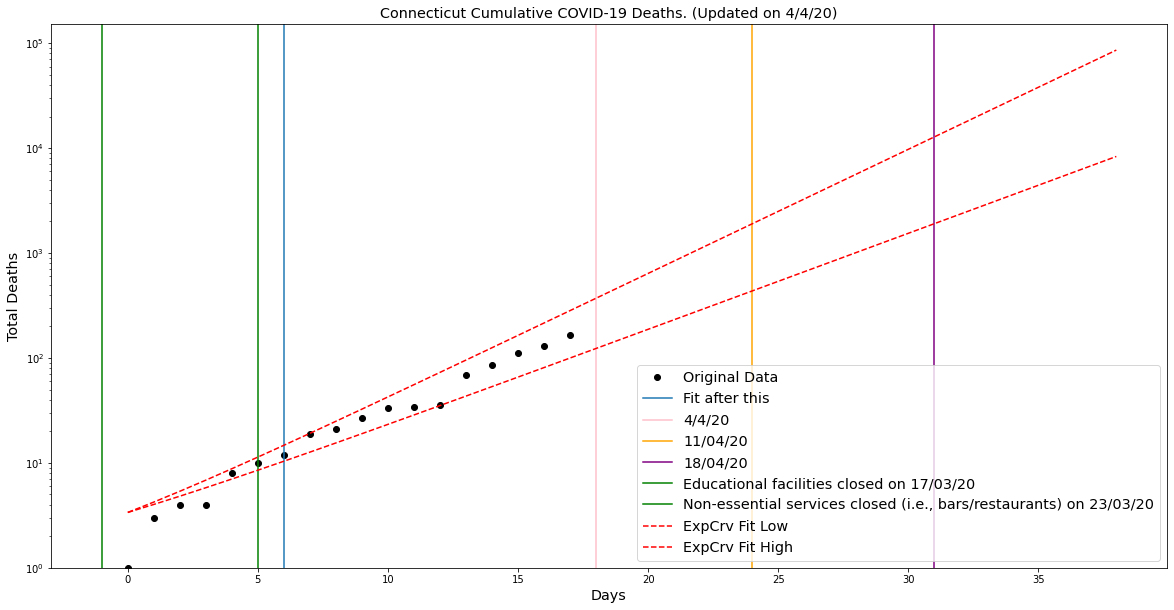



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 4188
	Confirmed cases on 3/28/20 	 1740
	Ratio: 2.41
	Weekly increase: 140.7 %
	Daily increase: 13.4 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9959520480360227
	Skipping 4 days
	Doubling Time (during middle of growth):  6.03 (± 1.07 ) days

** Based on Exponential Fit **

	R^2: 0.9864422455973707
	Skipping 4 days
	Doubling Time (represents overall growth):  5.13 (± 0.76 ) days


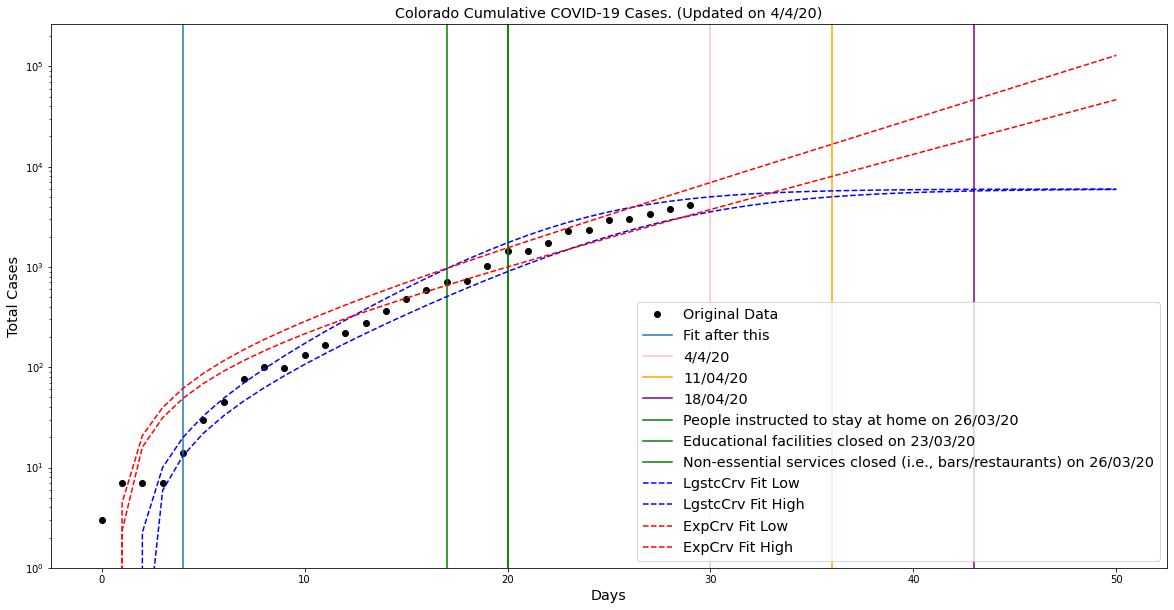

US state deaths:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 111
	Confirmed cases on 3/28/20 	 31
	Ratio: 3.58
	Weekly increase: 258.1 %
	Daily increase: 20.0 % per day
	Doubling Time (represents recent growth): 3.8 days


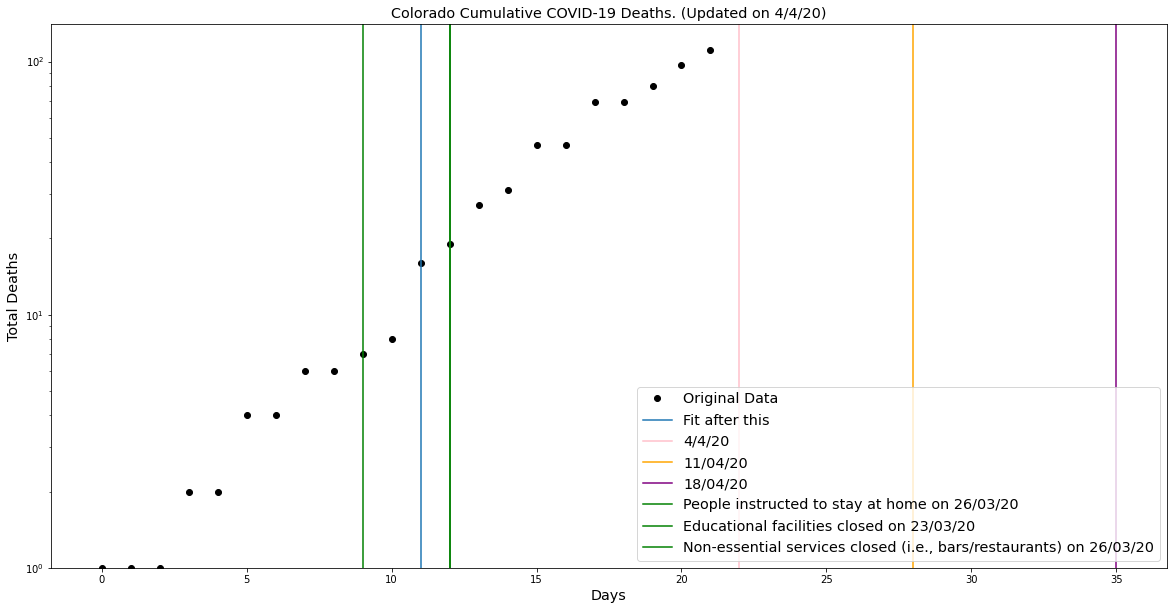



US state:  Indiana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 3953
	Confirmed cases on 3/28/20 	 1233
	Ratio: 3.21
	Weekly increase: 220.6 %
	Daily increase: 18.1 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Logistic Fit**

	R^2: 0.9989638087300361
	Skipping 5 days
	Doubling Time (during middle of growth):  4.81 (± 0.39 ) days

** Based on Exponential Fit **

	R^2: 0.991633644776853
	Skipping 5 days
	Doubling Time (represents overall growth):  3.92 (± 0.39 ) days


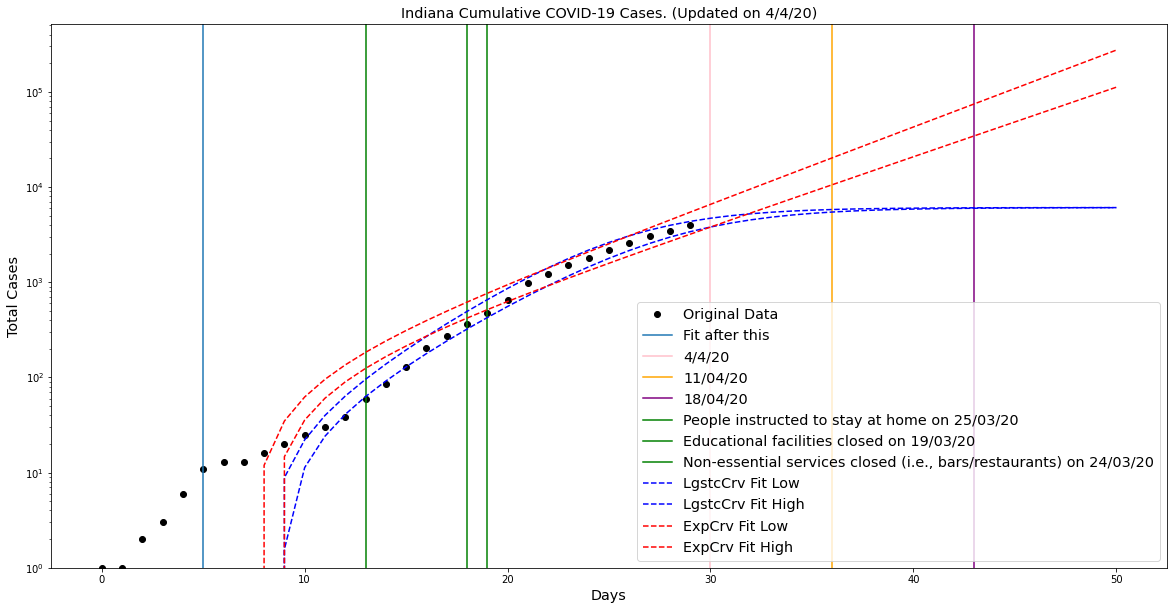

US state deaths:  Indiana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 116
	Confirmed cases on 3/28/20 	 31
	Ratio: 3.74
	Weekly increase: 274.2 %
	Daily increase: 20.7 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Exponential Fit **

	R^2: 0.993065360318541
	Skipping 8 days
	Doubling Time (represents overall growth):  3.21 (± 0.69 ) days


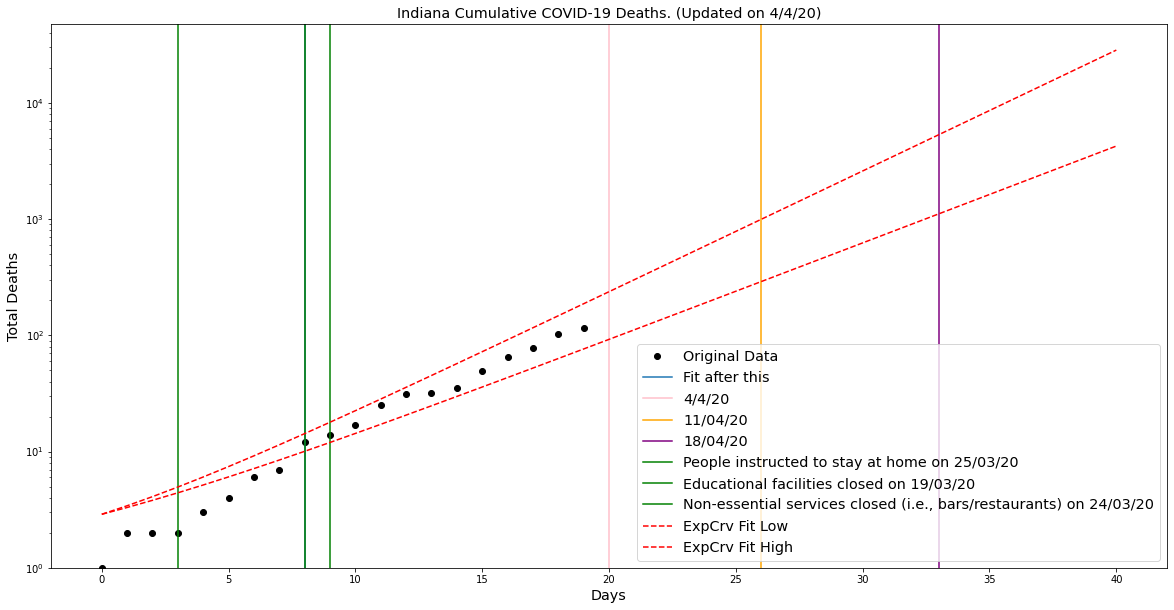



US state:  Ohio

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 3739
	Confirmed cases on 3/28/20 	 1406
	Ratio: 2.66
	Weekly increase: 165.9 %
	Daily increase: 15.0 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.9991526728457234
	Skipping 3 days
	Doubling Time (during middle of growth):  6.13 (± 0.54 ) days

** Based on Exponential Fit **

	R^2: 0.9927623524328422
	Skipping 3 days
	Doubling Time (represents overall growth):  4.51 (± 0.51 ) days


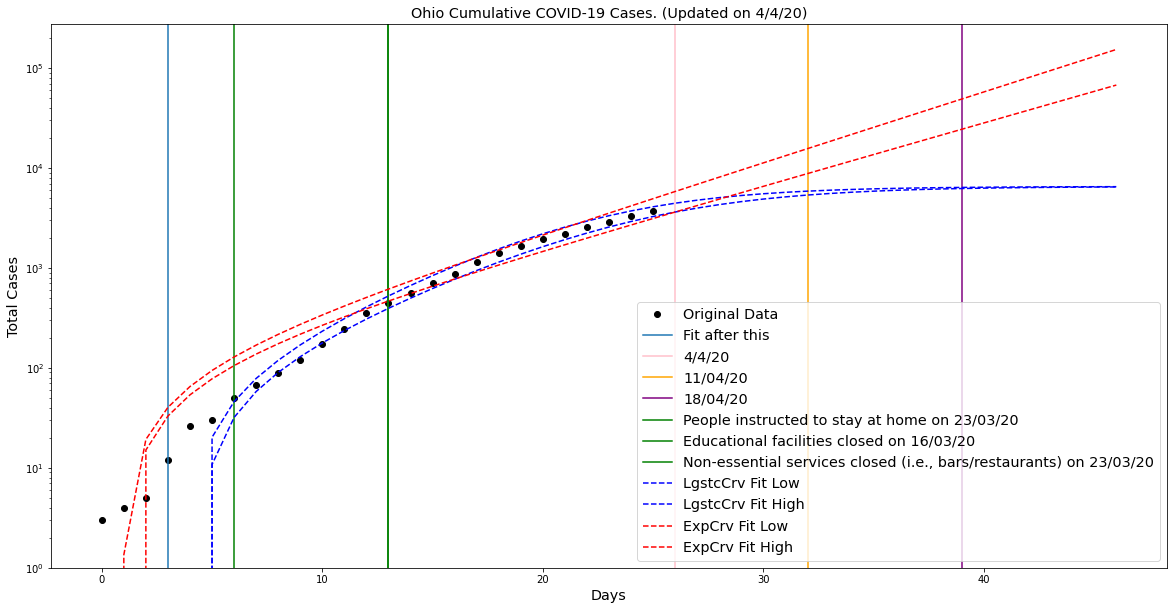

US state deaths:  Ohio

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 102
	Confirmed cases on 3/28/20 	 25
	Ratio: 4.08
	Weekly increase: 308.0 %
	Daily increase: 22.2 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.9927090147932284
	Skipping 5 days
	Doubling Time (during middle of growth):  2.99 (± 0.62 ) days

** Based on Exponential Fit **

	R^2: 0.9699673210501039
	Skipping 5 days
	Doubling Time (represents overall growth):  5.79 (± 2.39 ) days


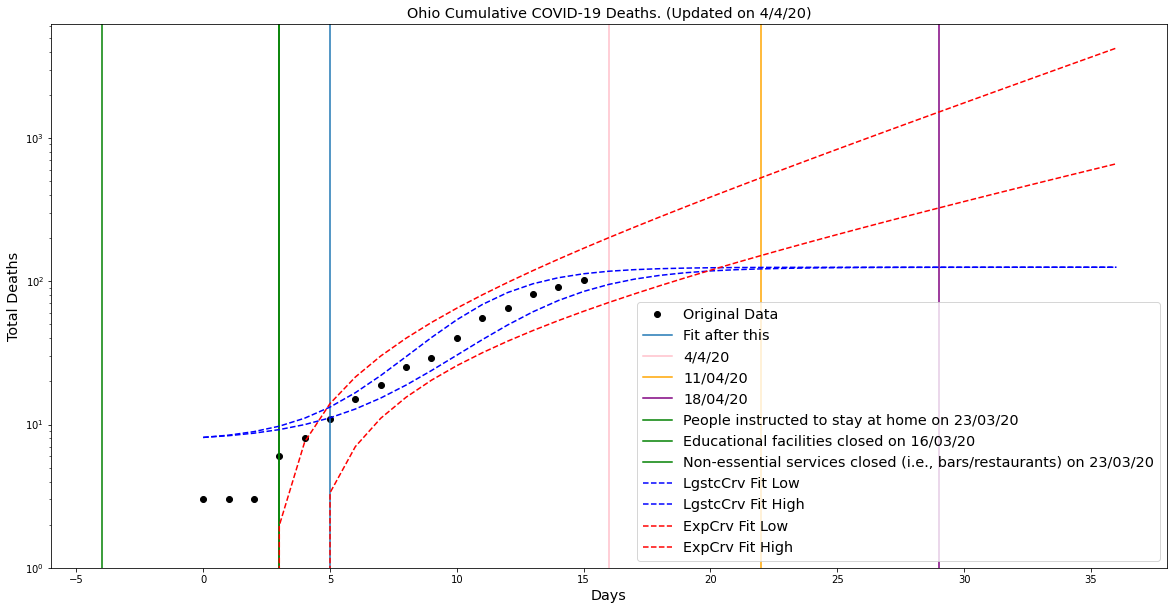



US state:  Tennessee

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 3322
	Confirmed cases on 3/28/20 	 1511
	Ratio: 2.2
	Weekly increase: 119.9 %
	Daily increase: 11.9 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.99538678607604
	Skipping 7 days
	Doubling Time (during middle of growth):  5.4 (± 1.03 ) days

** Based on Exponential Fit **

	R^2: 0.977547326274409
	Skipping 7 days
	Doubling Time (represents overall growth):  5.17 (± 1.15 ) days


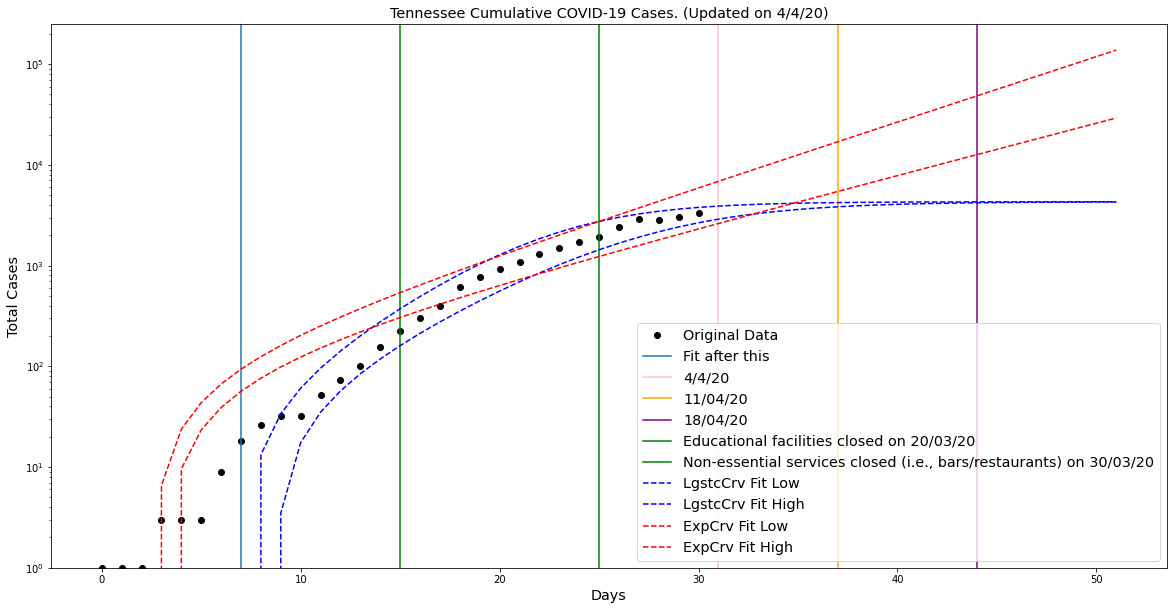

US state deaths:  Tennessee

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 50
	Confirmed cases on 3/28/20 	 7
	Ratio: 7.14
	Weekly increase: 614.3 %
	Daily increase: 32.4 % per day
	Doubling Time (represents recent growth): 2.5 days


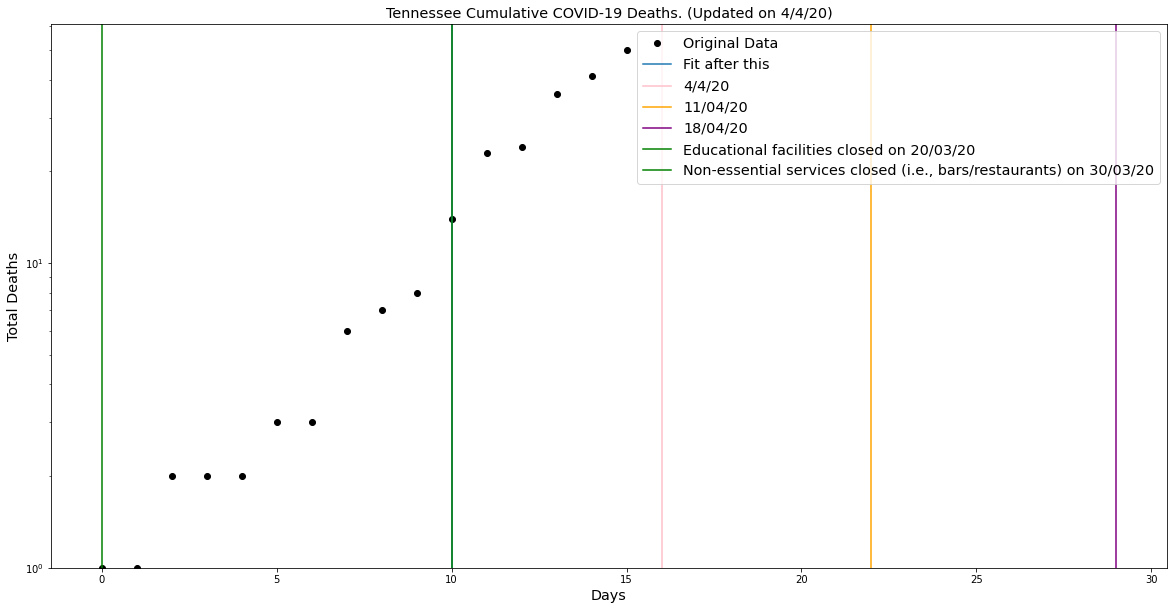



US state:  Maryland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 3125
	Confirmed cases on 3/28/20 	 995
	Ratio: 3.14
	Weekly increase: 214.1 %
	Daily increase: 17.8 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Logistic Fit**

	R^2: 0.999134765092607
	Skipping 6 days
	Doubling Time (during middle of growth):  5.72 (± 0.53 ) days

** Based on Exponential Fit **

	R^2: 0.9958417891101199
	Skipping 6 days
	Doubling Time (represents overall growth):  4.17 (± 0.28 ) days


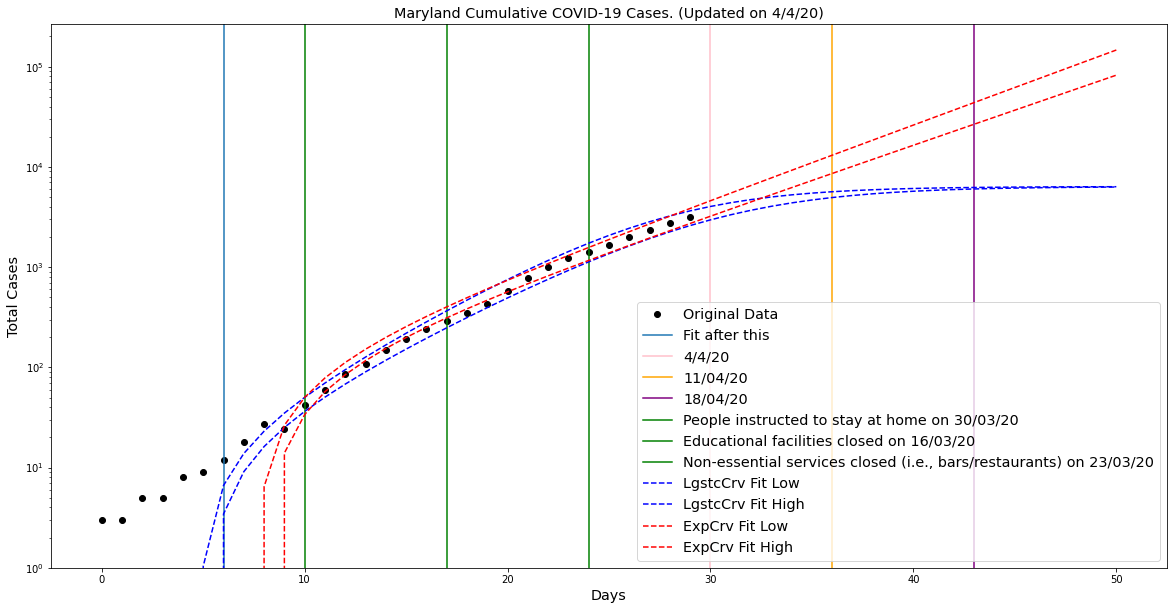

US state deaths:  Maryland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 54
	Confirmed cases on 3/28/20 	 5
	Ratio: 10.8
	Weekly increase: 980.0 %
	Daily increase: 40.5 % per day
	Doubling Time (represents recent growth): 2.0 days


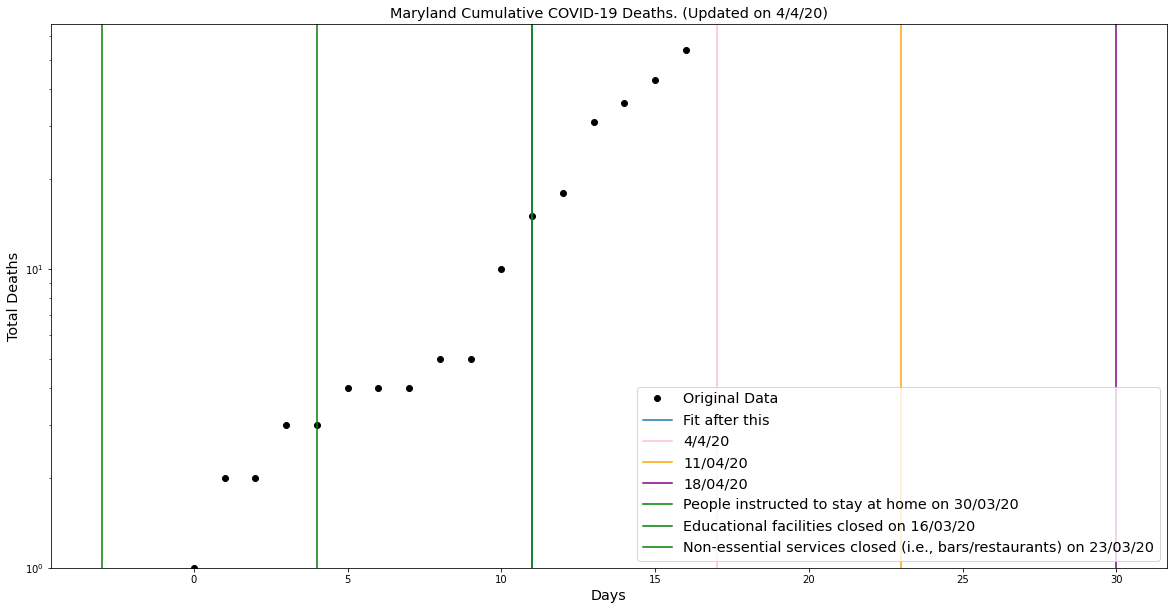



US state:  North Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 2486
	Confirmed cases on 3/28/20 	 1020
	Ratio: 2.44
	Weekly increase: 143.7 %
	Daily increase: 13.6 % per day
	Doubling Time (represents recent growth): 5.4 days

** Based on Exponential Fit **

	R^2: 0.9942541342204912
	Skipping 9 days
	Doubling Time (represents overall growth):  5.09 (± 0.51 ) days


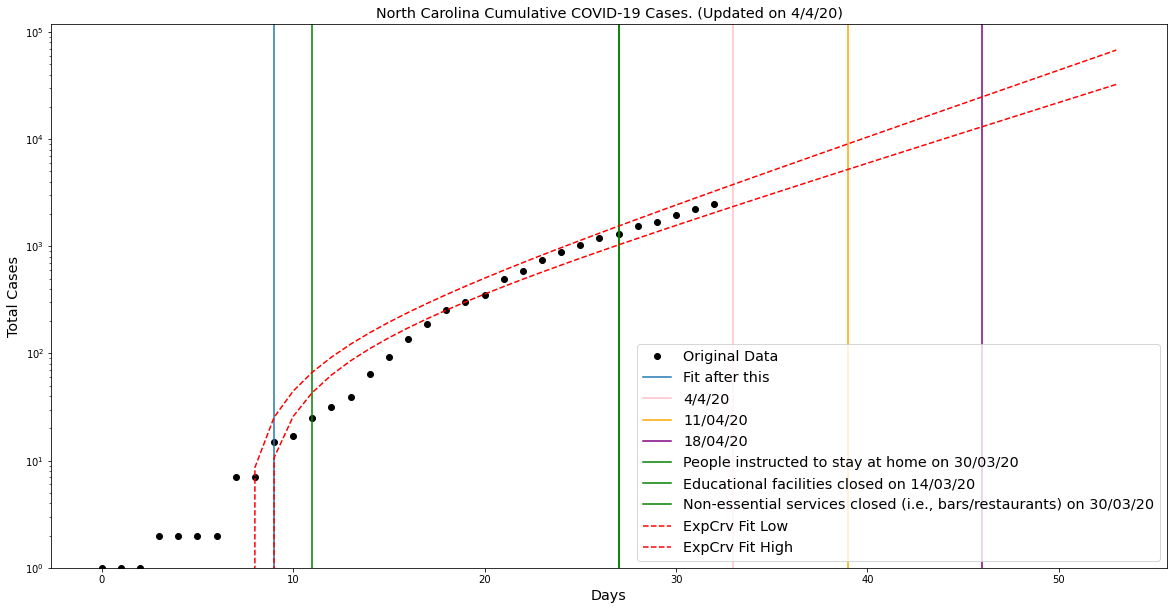

US state deaths:  North Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 34
	Confirmed cases on 3/28/20 	 5
	Ratio: 6.8
	Weekly increase: 580.0 %
	Daily increase: 31.5 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Exponential Fit **

	R^2: 0.9681184787980652
	Skipping 6 days
	Doubling Time (represents overall growth):  3.31 (± 3.62 ) days


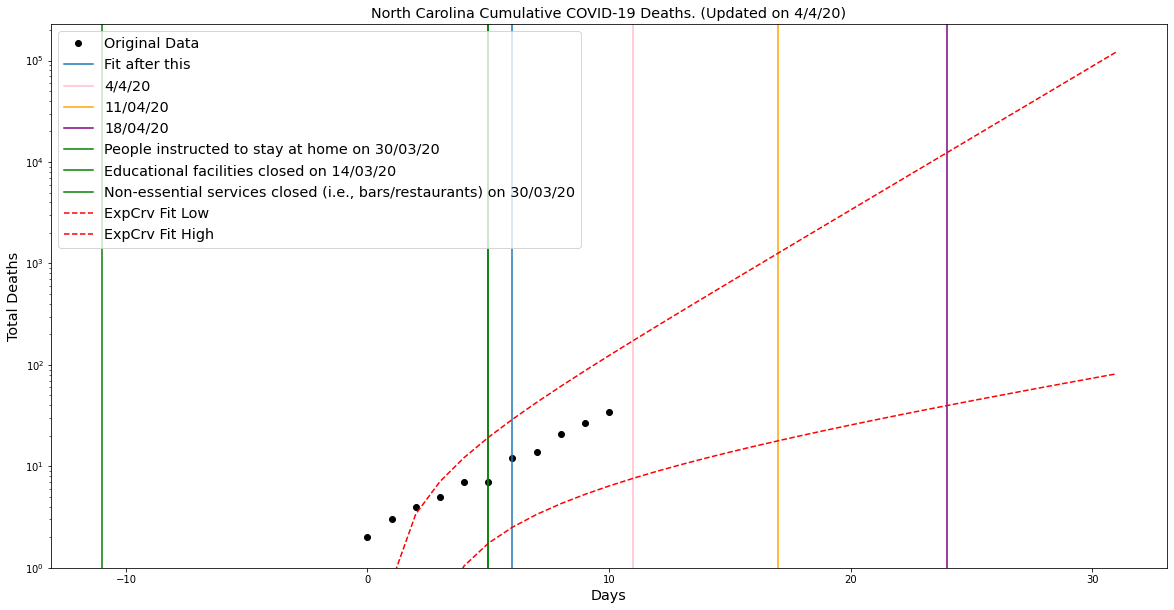



US state:  Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 2407
	Confirmed cases on 3/28/20 	 740
	Ratio: 3.25
	Weekly increase: 225.3 %
	Daily increase: 18.4 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.9994063823765114
	Skipping 4 days
	Doubling Time (during middle of growth):  6.96 (± 0.64 ) days

** Based on Exponential Fit **

	R^2: 0.9987019059338996
	Skipping 4 days
	Doubling Time (represents overall growth):  4.2 (± 0.16 ) days


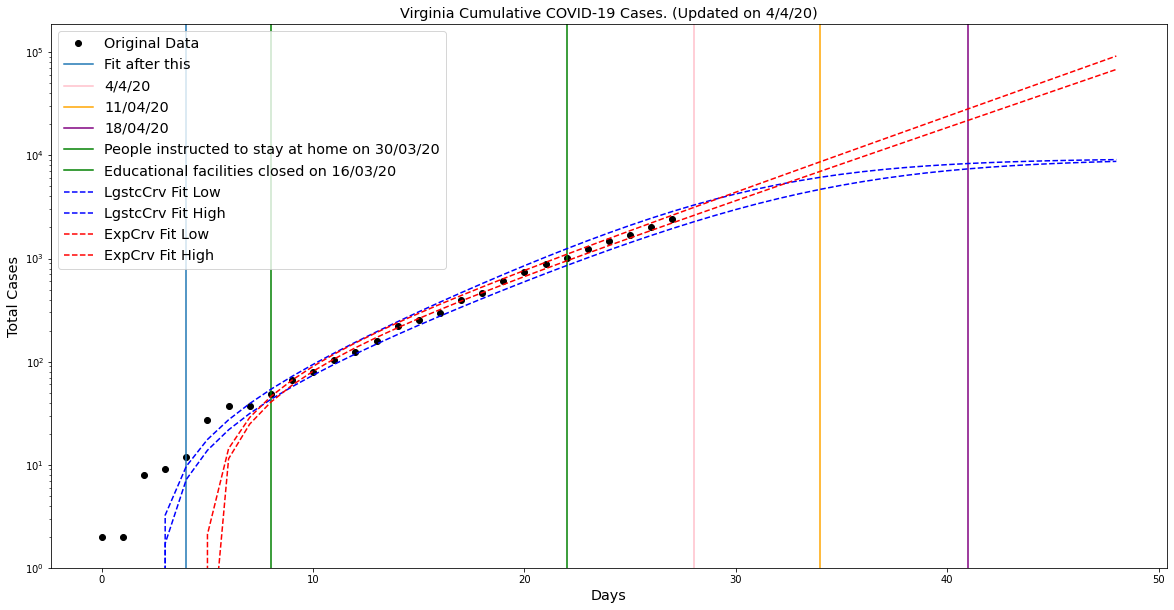

US state deaths:  Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 52
	Confirmed cases on 3/28/20 	 13
	Ratio: 4.0
	Weekly increase: 300.0 %
	Daily increase: 21.9 % per day
	Doubling Time (represents recent growth): 3.5 days


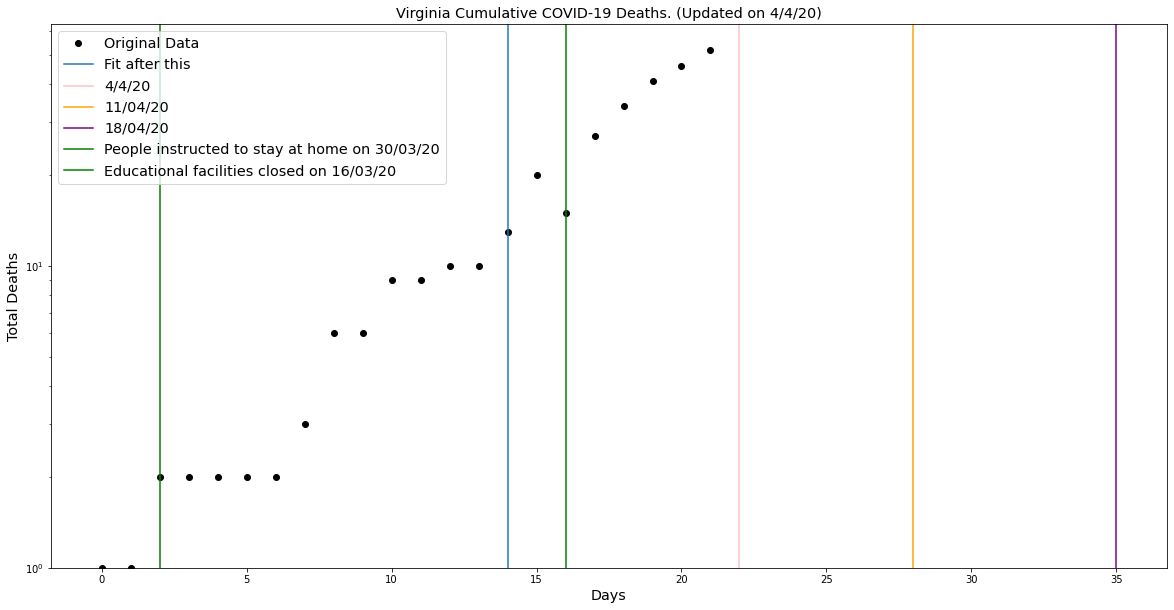



US state:  Missouri

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 2310
	Confirmed cases on 3/28/20 	 836
	Ratio: 2.76
	Weekly increase: 176.3 %
	Daily increase: 15.6 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Exponential Fit **

	R^2: 0.9859670642934868
	Skipping 9 days
	Doubling Time (represents overall growth):  4.4 (± 0.93 ) days


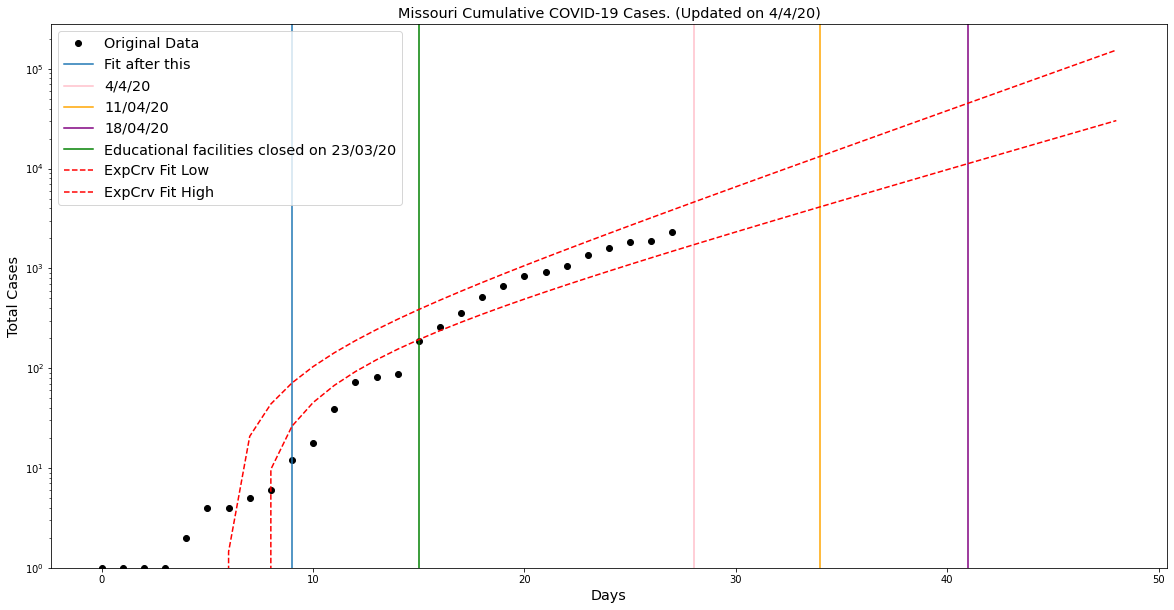

US state deaths:  Missouri

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 33
	Confirmed cases on 3/28/20 	 10
	Ratio: 3.3
	Weekly increase: 230.0 %
	Daily increase: 18.6 % per day
	Doubling Time (represents recent growth): 4.1 days


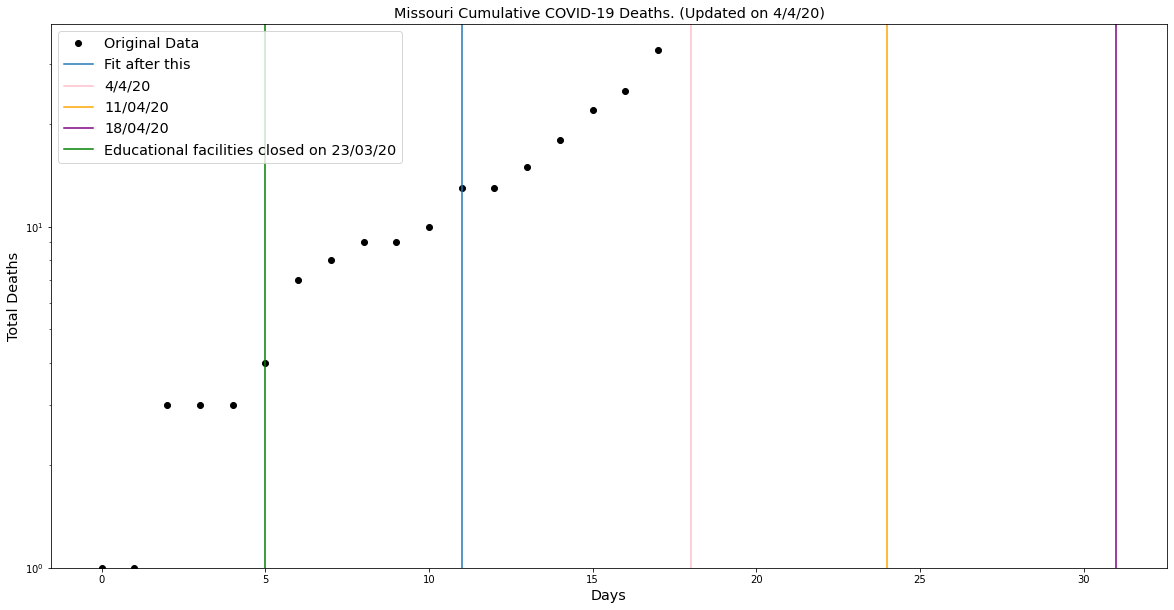



US state:  Arizona

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 2187
	Confirmed cases on 3/28/20 	 773
	Ratio: 2.83
	Weekly increase: 182.9 %
	Daily increase: 16.0 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Exponential Fit **

	R^2: 0.9703811576596361
	Skipping 48 days
	Doubling Time (represents overall growth):  4.59 (± 0.58 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


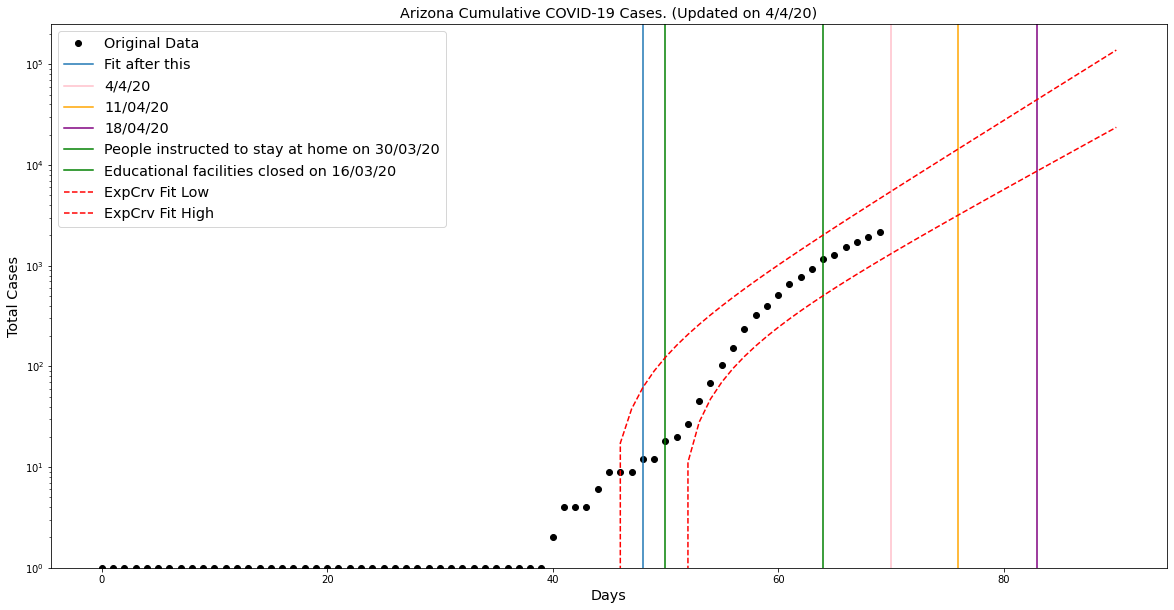

US state deaths:  Arizona

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 52
	Confirmed cases on 3/28/20 	 15
	Ratio: 3.47
	Weekly increase: 246.7 %
	Daily increase: 19.4 % per day
	Doubling Time (represents recent growth): 3.9 days


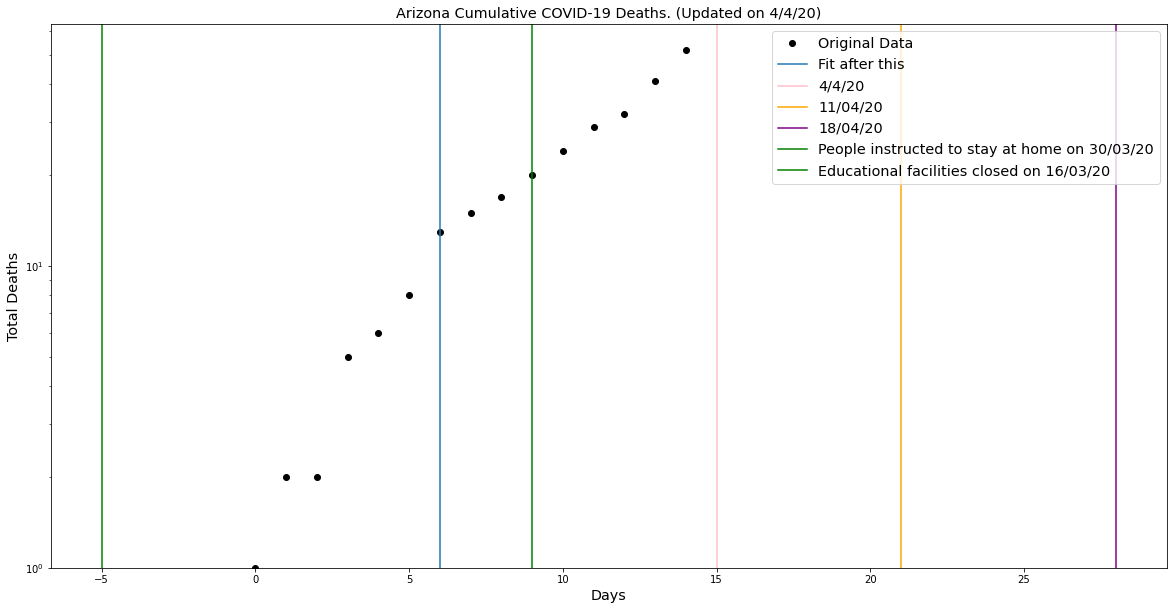



US state:  Wisconsin

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 2030
	Confirmed cases on 3/28/20 	 1055
	Ratio: 1.92
	Weekly increase: 92.4 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9967754977634535
	Skipping 3 days
	Doubling Time (during middle of growth):  7.4 (± 1.55 ) days

** Based on Exponential Fit **

	R^2: 0.9835324806243494
	Skipping 3 days
	Doubling Time (represents overall growth):  5.48 (± 1.07 ) days


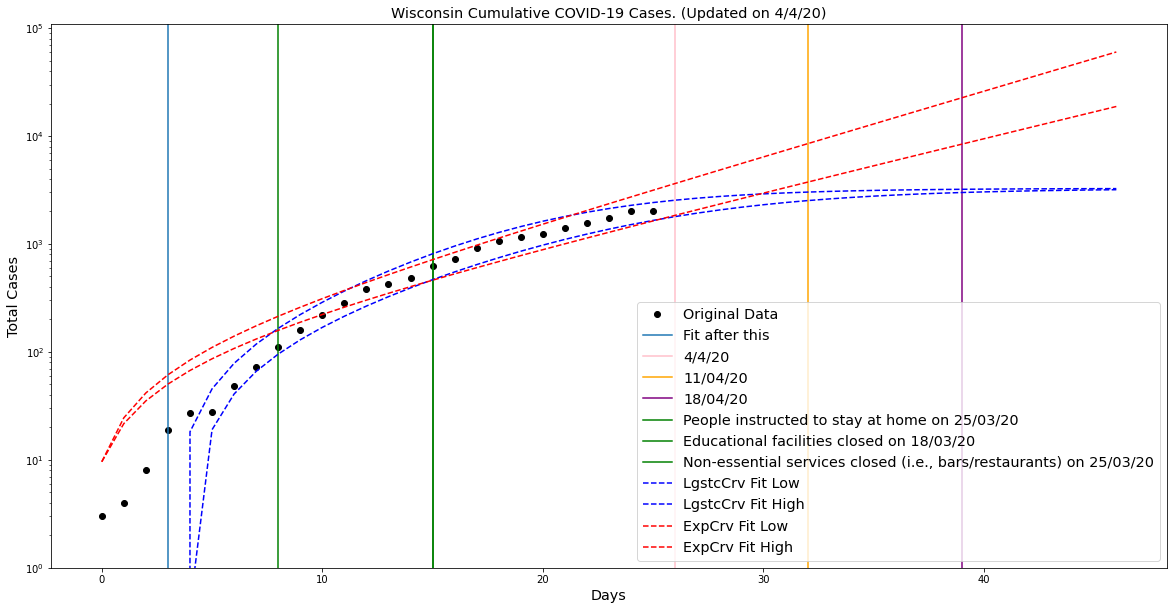

US state deaths:  Wisconsin

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 54
	Confirmed cases on 3/28/20 	 17
	Ratio: 3.18
	Weekly increase: 217.6 %
	Daily increase: 18.0 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Exponential Fit **

	R^2: 0.9524086181940601
	Skipping 8 days
	Doubling Time (represents overall growth):  2.77 (± 1.52 ) days


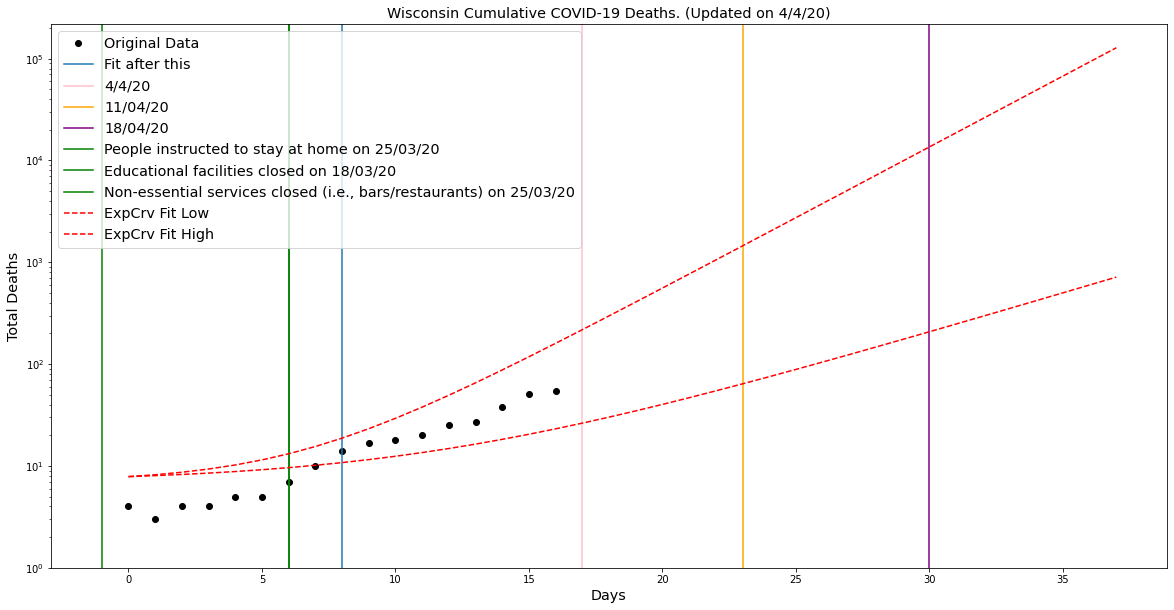



US state:  South Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 1917
	Confirmed cases on 3/28/20 	 660
	Ratio: 2.9
	Weekly increase: 190.5 %
	Daily increase: 16.5 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Exponential Fit **

	R^2: 0.9958887852527207
	Skipping 7 days
	Doubling Time (represents overall growth):  4.83 (± 0.36 ) days


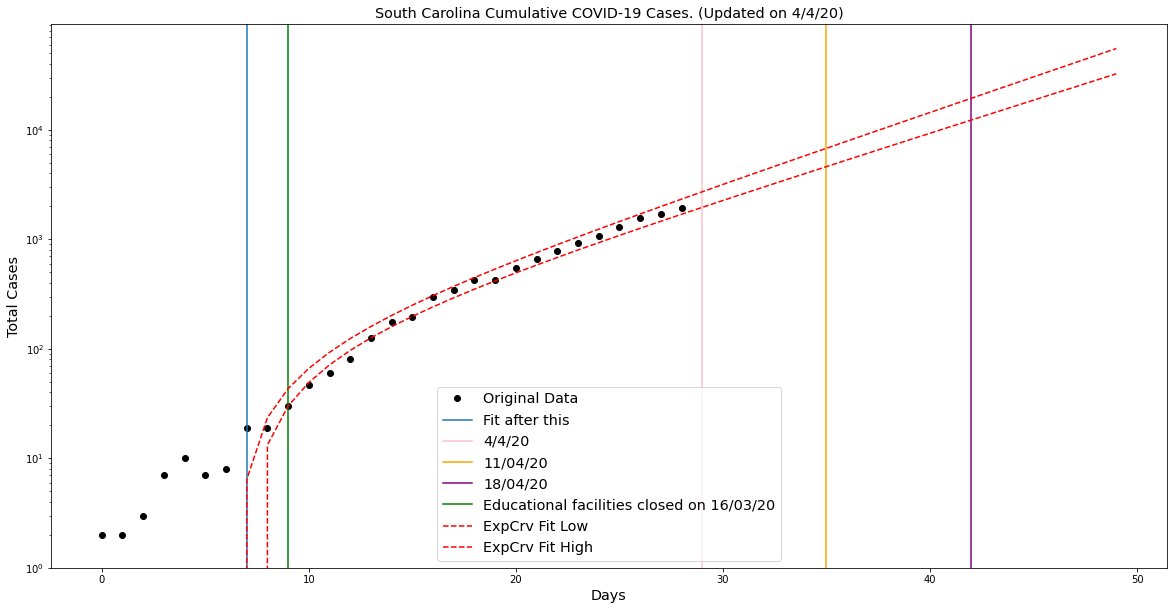

US state deaths:  South Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 40
	Confirmed cases on 3/28/20 	 15
	Ratio: 2.67
	Weekly increase: 166.7 %
	Daily increase: 15.0 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Exponential Fit **

	R^2: 0.960068033831909
	Skipping 11 days
	Doubling Time (represents overall growth):  4.31 (± 1.54 ) days


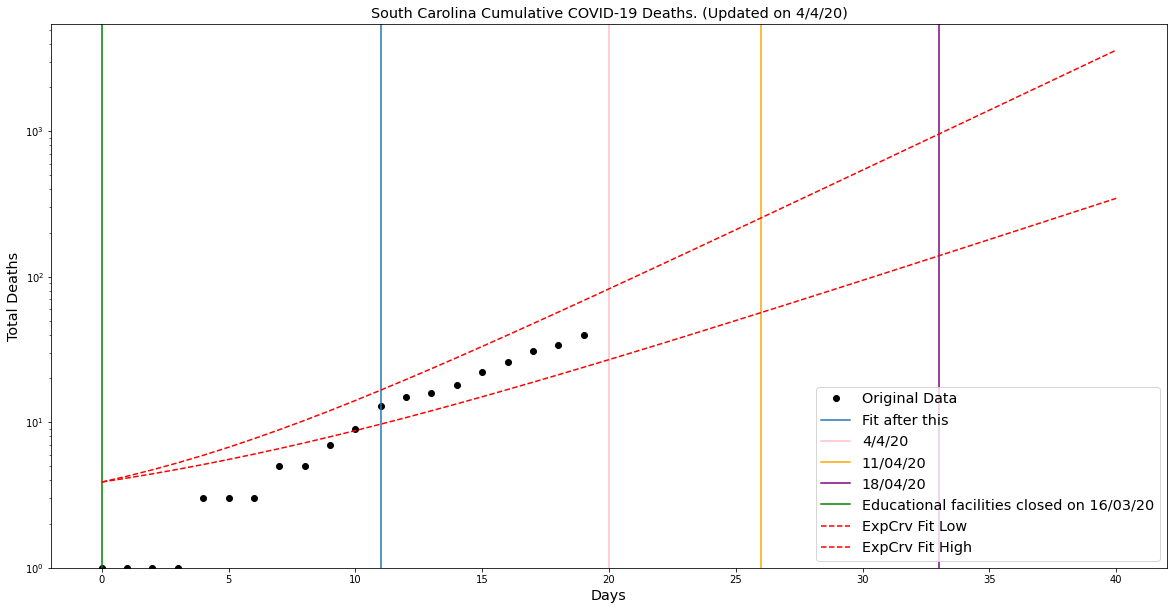



US state:  Nevada

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 1742
	Confirmed cases on 3/28/20 	 626
	Ratio: 2.78
	Weekly increase: 178.3 %
	Daily increase: 15.7 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Exponential Fit **

	R^2: 0.9860500257492729
	Skipping 8 days
	Doubling Time (represents overall growth):  5.14 (± 0.85 ) days


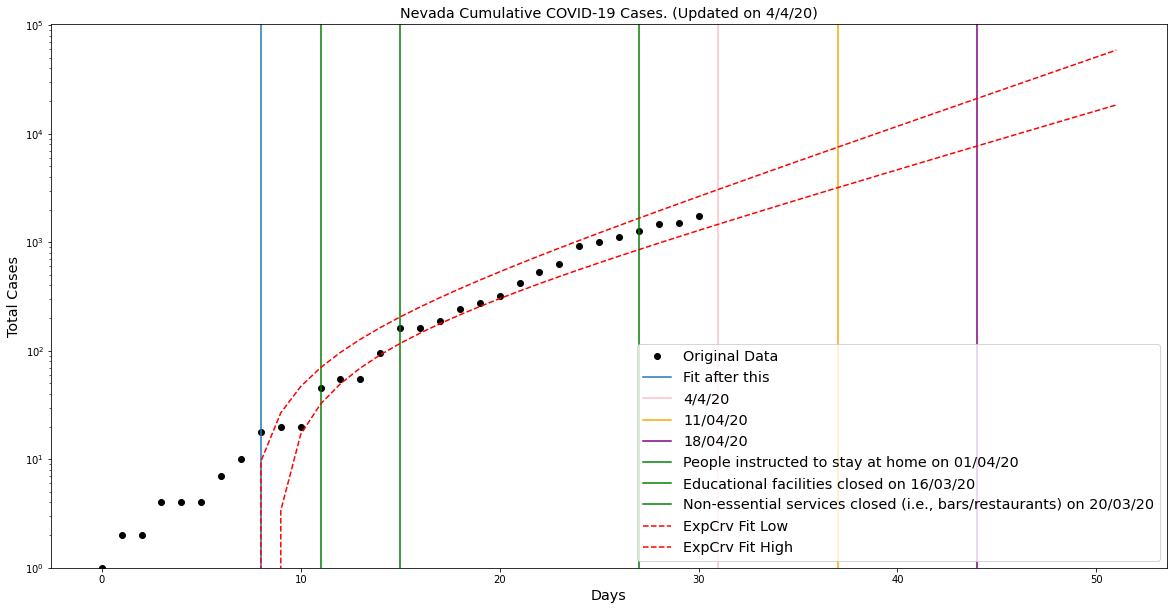

US state deaths:  Nevada

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 46
	Confirmed cases on 3/28/20 	 10
	Ratio: 4.6
	Weekly increase: 360.0 %
	Daily increase: 24.4 % per day
	Doubling Time (represents recent growth): 3.2 days


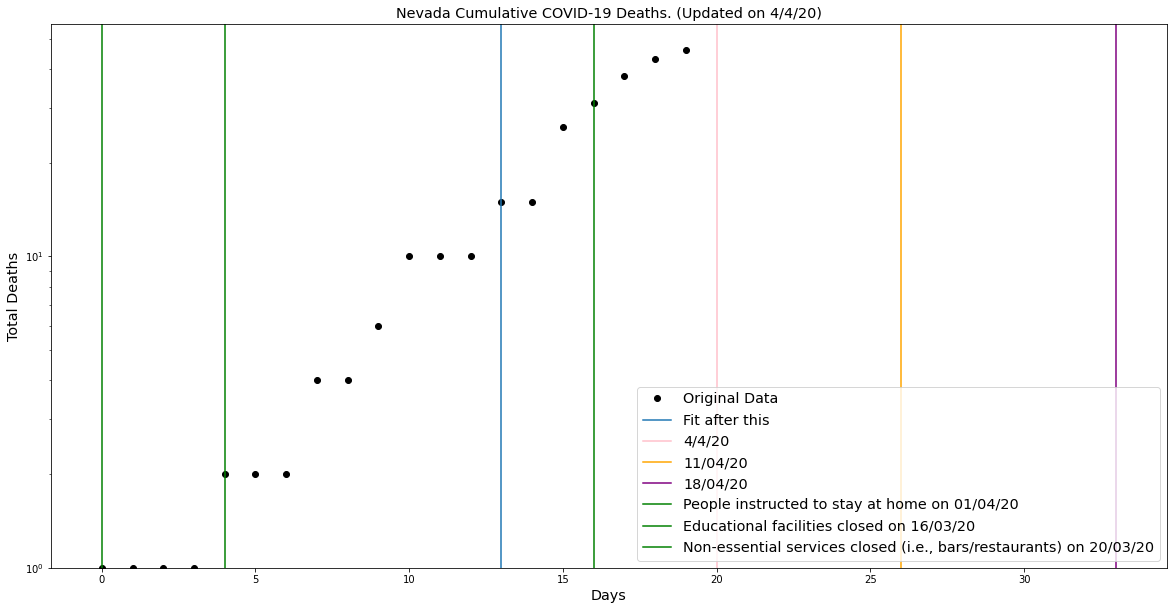



US state:  Alabama

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 1614
	Confirmed cases on 3/28/20 	 694
	Ratio: 2.33
	Weekly increase: 132.6 %
	Daily increase: 12.8 % per day
	Doubling Time (represents recent growth): 5.7 days

** Based on Logistic Fit**

	R^2: 0.9930366408141742
	Skipping 2 days
	Doubling Time (during middle of growth):  7.54 (± 2.97 ) days

** Based on Exponential Fit **

	R^2: 0.9878966993484105
	Skipping 2 days
	Doubling Time (represents overall growth):  5.29 (± 0.96 ) days


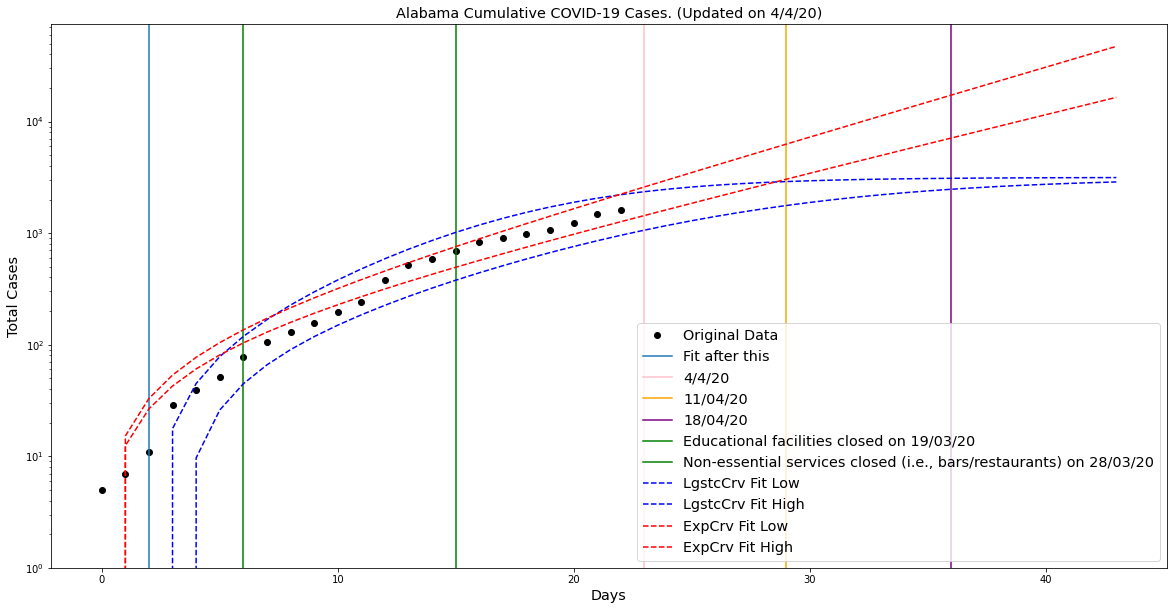

US state deaths:  Alabama

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 44
	Confirmed cases on 3/28/20 	 4
	Ratio: 11.0
	Weekly increase: 1000.0 %
	Daily increase: 40.9 % per day
	Doubling Time (represents recent growth): 2.0 days


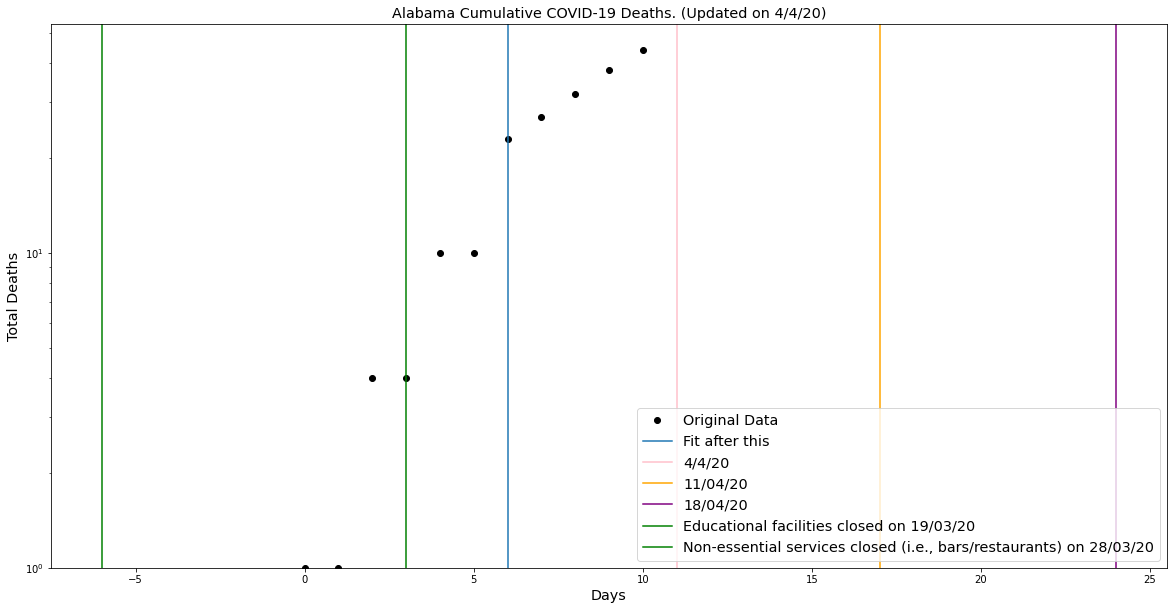



US state:  Mississippi

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 1455
	Confirmed cases on 3/28/20 	 663
	Ratio: 2.19
	Weekly increase: 119.5 %
	Daily increase: 11.9 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.9948726822639882
	Skipping 4 days
	Doubling Time (during middle of growth):  8.6 (± 2.08 ) days

** Based on Exponential Fit **

	R^2: 0.9886948938699215
	Skipping 4 days
	Doubling Time (represents overall growth):  5.61 (± 1.16 ) days


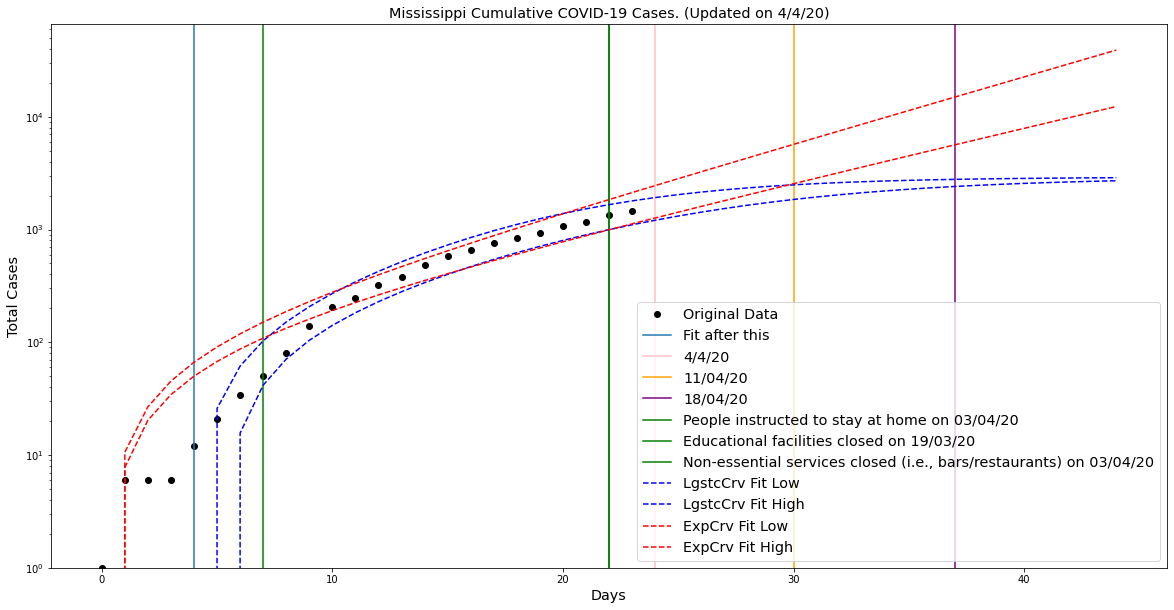

US state deaths:  Mississippi

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 35
	Confirmed cases on 3/28/20 	 13
	Ratio: 2.69
	Weekly increase: 169.2 %
	Daily increase: 15.2 % per day
	Doubling Time (represents recent growth): 4.9 days


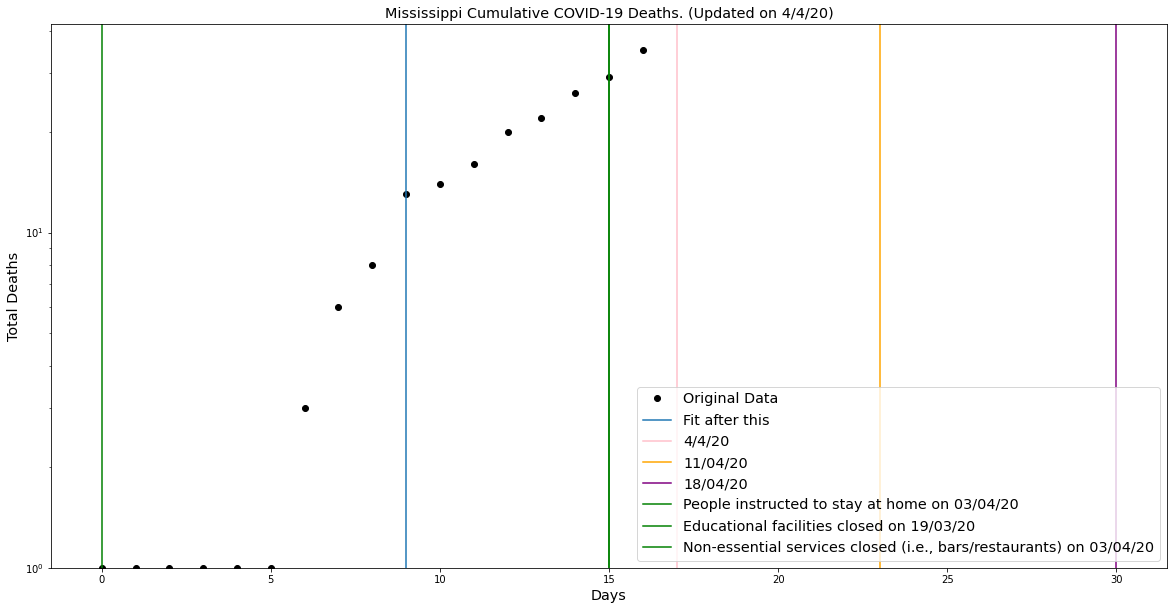



US state:  Utah

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 1432
	Confirmed cases on 3/28/20 	 602
	Ratio: 2.38
	Weekly increase: 137.9 %
	Daily increase: 13.2 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Exponential Fit **

	R^2: 0.9910670686502276
	Skipping 8 days
	Doubling Time (represents overall growth):  5.52 (± 0.87 ) days


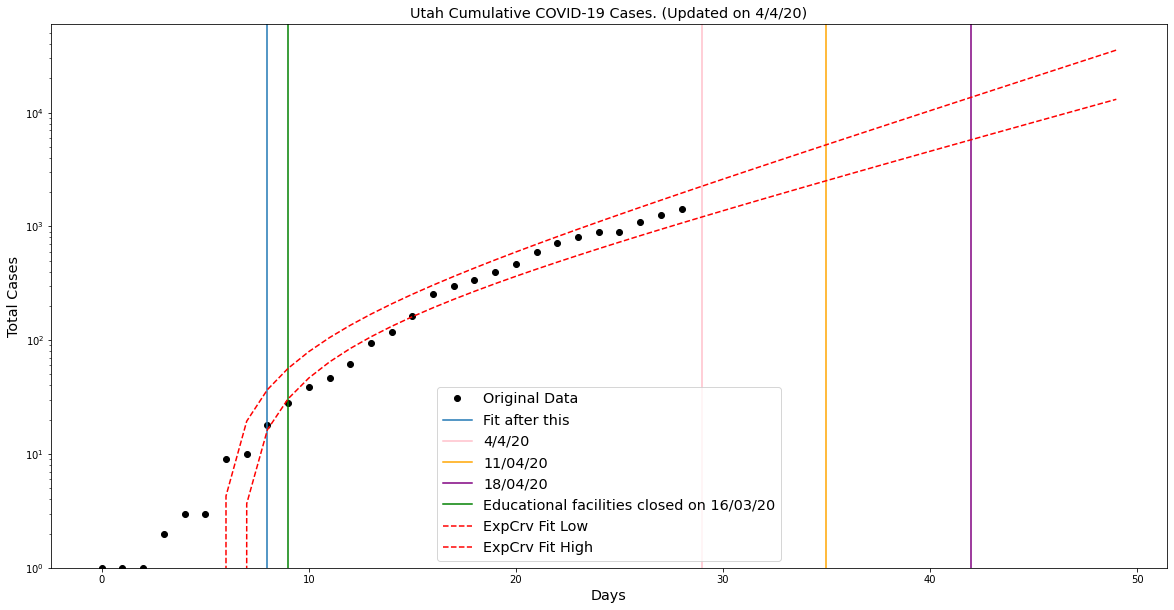

US state deaths:  Utah

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 8
	Confirmed cases on 3/28/20 	 1
	Ratio: 8.0
	Weekly increase: 700.0 %
	Daily increase: 34.6 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.9769279006529472
	Skipping 0 days
	Doubling Time (during middle of growth):  1.85 (± 0.82 ) days


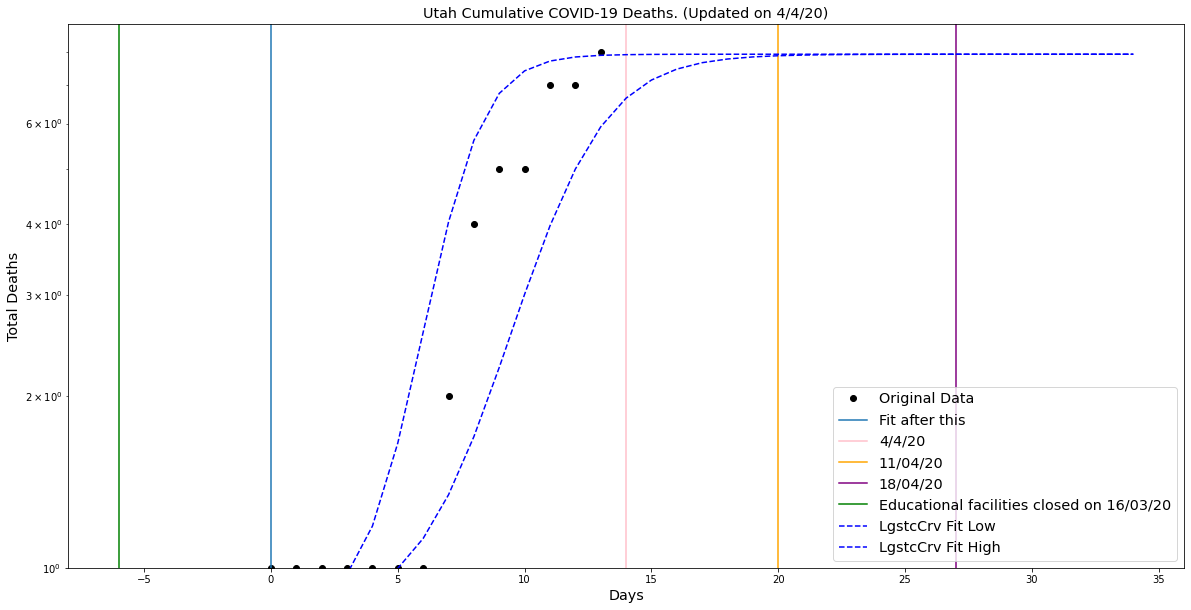



US state:  Oklahoma

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 1161
	Confirmed cases on 3/28/20 	 377
	Ratio: 3.08
	Weekly increase: 208.0 %
	Daily increase: 17.4 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Exponential Fit **

	R^2: 0.9876303812129847
	Skipping 10 days
	Doubling Time (represents overall growth):  4.53 (± 0.49 ) days


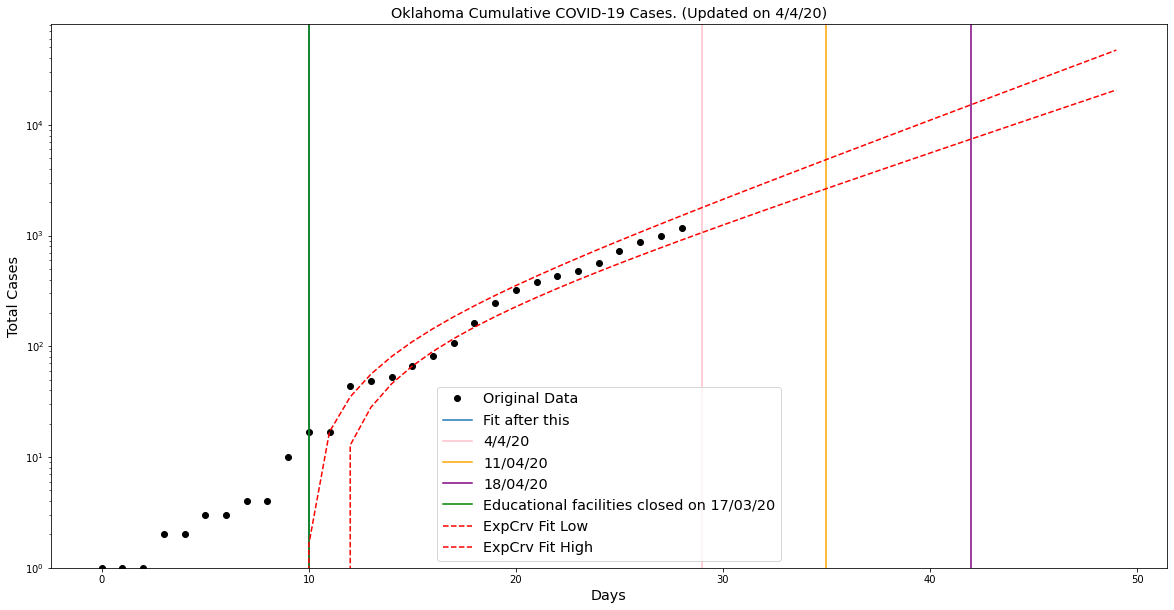

US state deaths:  Oklahoma

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 42
	Confirmed cases on 3/28/20 	 15
	Ratio: 2.8
	Weekly increase: 180.0 %
	Daily increase: 15.8 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Exponential Fit **

	R^2: 0.9532765265351681
	Skipping 9 days
	Doubling Time (represents overall growth):  7.81 (± 14.51 ) days


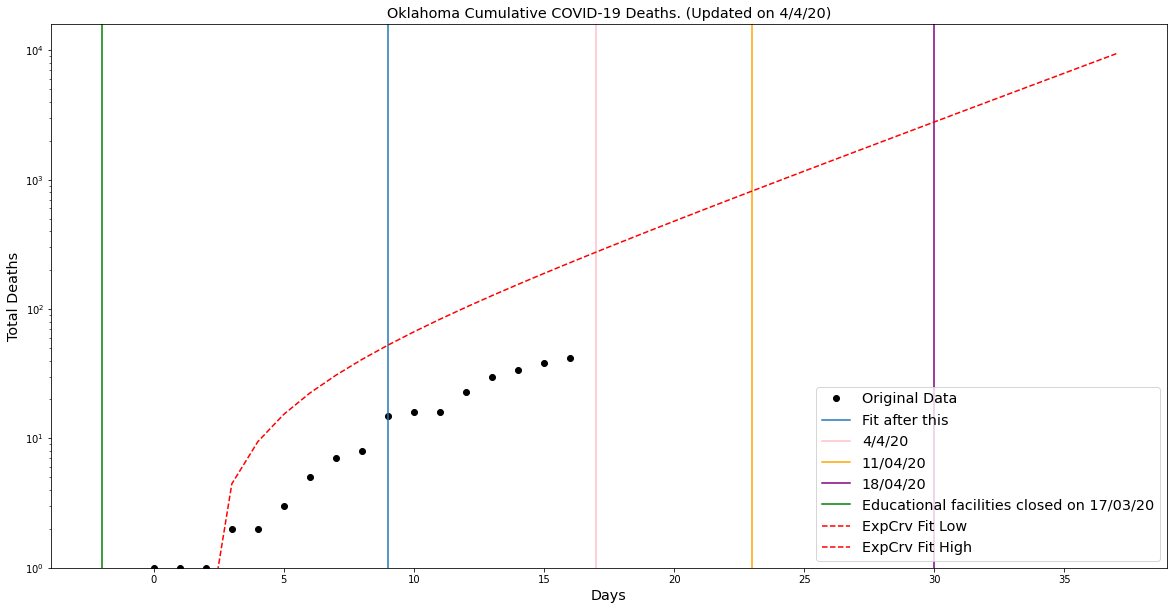



US state:  Idaho

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 1022
	Confirmed cases on 3/28/20 	 234
	Ratio: 4.37
	Weekly increase: 336.8 %
	Daily increase: 23.4 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Exponential Fit **

	R^2: 0.9924948276068082
	Skipping 6 days
	Doubling Time (represents overall growth):  3.62 (± 0.5 ) days


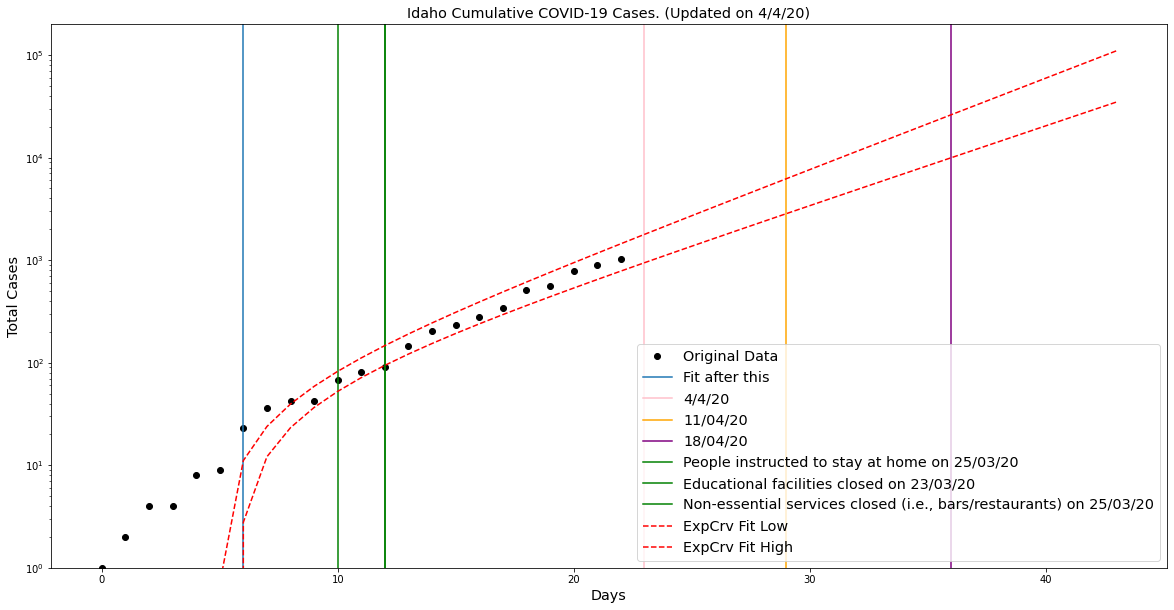

US state deaths:  Idaho

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 10
	Confirmed cases on 3/28/20 	 4
	Ratio: 2.5
	Weekly increase: 150.0 %
	Daily increase: 14.0 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.987732258459299
	Skipping 0 days
	Doubling Time (during middle of growth):  1.54 (± 0.64 ) days


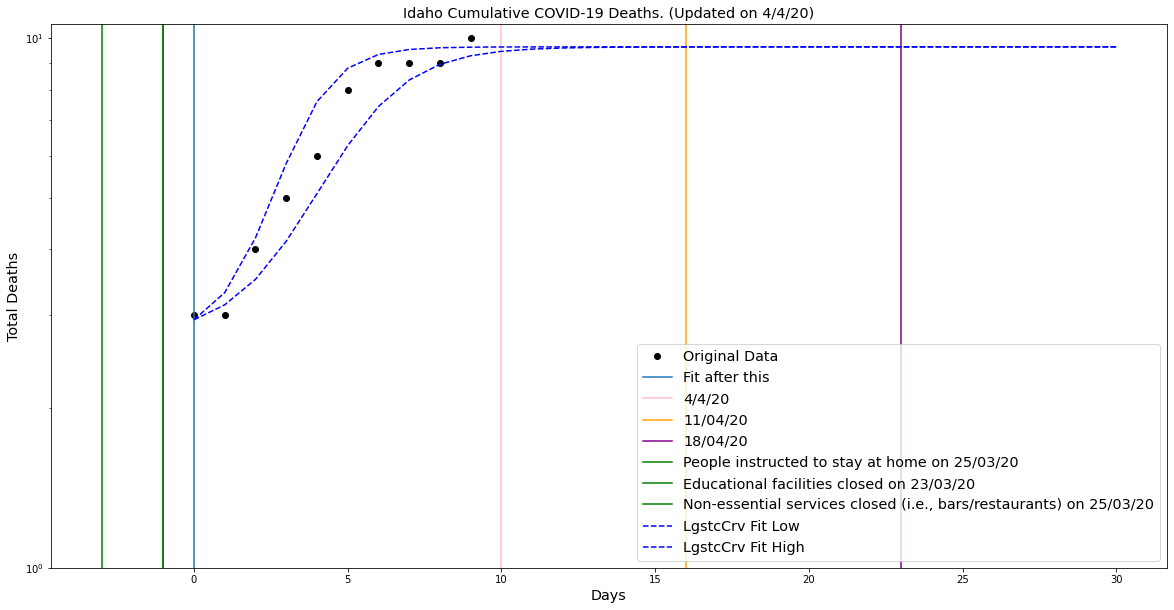



US state:  Kentucky

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 917
	Confirmed cases on 3/28/20 	 393
	Ratio: 2.33
	Weekly increase: 133.3 %
	Daily increase: 12.9 % per day
	Doubling Time (represents recent growth): 5.7 days

** Based on Exponential Fit **

	R^2: 0.9821691838994853
	Skipping 7 days
	Doubling Time (represents overall growth):  5.93 (± 0.92 ) days


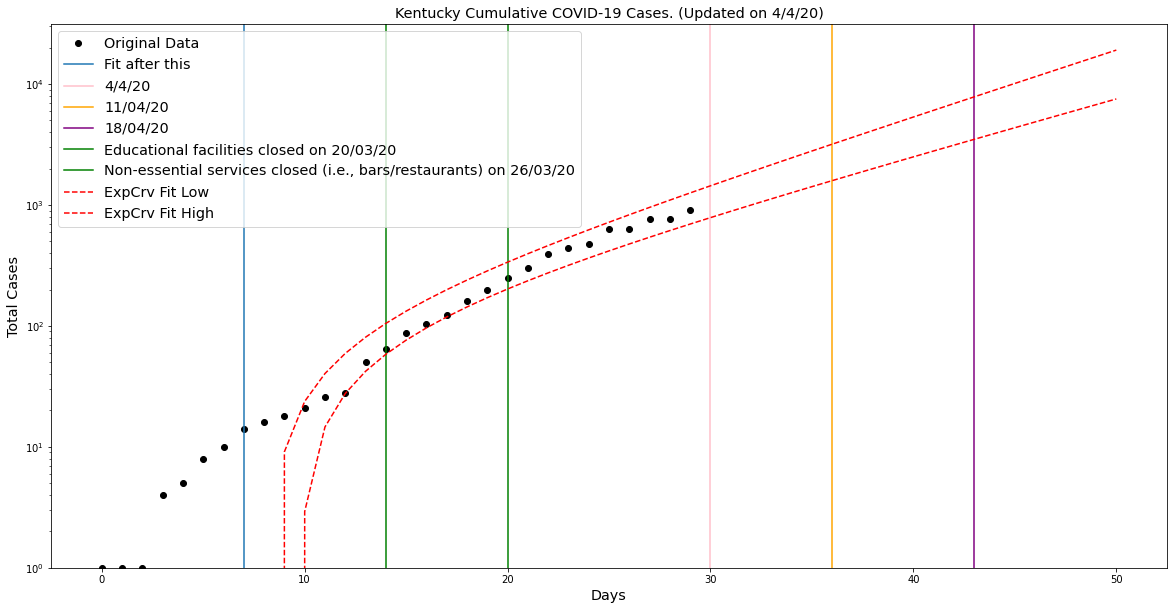

US state deaths:  Kentucky

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 40
	Confirmed cases on 3/28/20 	 9
	Ratio: 4.44
	Weekly increase: 344.4 %
	Daily increase: 23.8 % per day
	Doubling Time (represents recent growth): 3.3 days


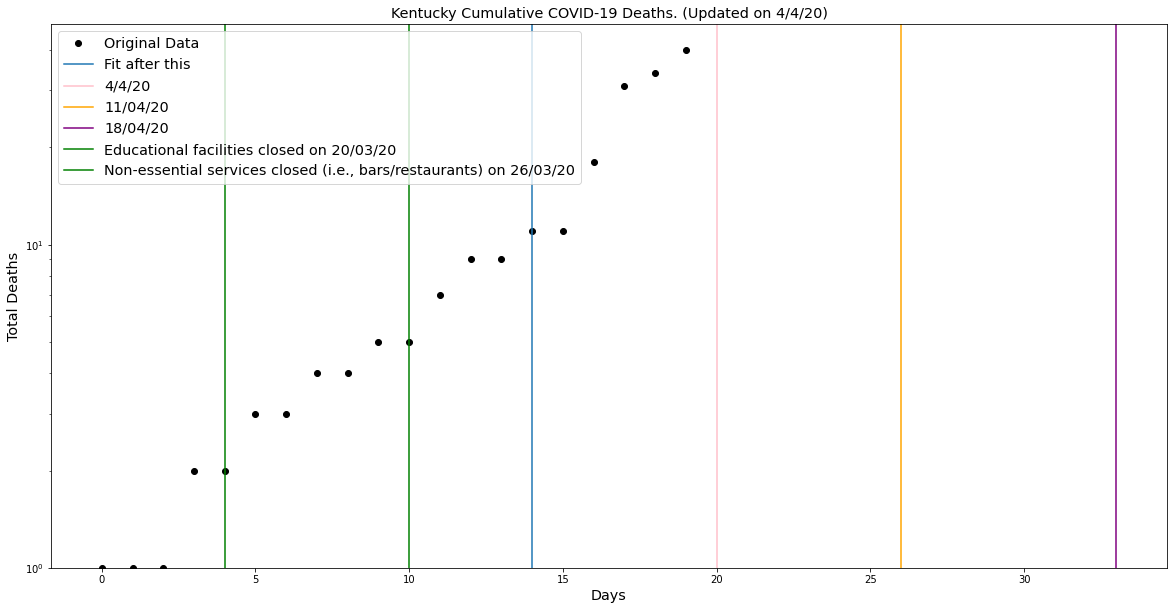



US state:  District of Columbia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 902
	Confirmed cases on 3/28/20 	 304
	Ratio: 2.97
	Weekly increase: 196.7 %
	Daily increase: 16.8 % per day
	Doubling Time (represents recent growth): 4.5 days

** Based on Logistic Fit**

	R^2: 0.9983182061379801
	Skipping 0 days
	Doubling Time (during middle of growth):  10.17 (± 0.66 ) days

** Based on Exponential Fit **

	R^2: 0.9983182062321847
	Skipping 0 days
	Doubling Time (represents overall growth):  5.08 (± 0.36 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in sqrt


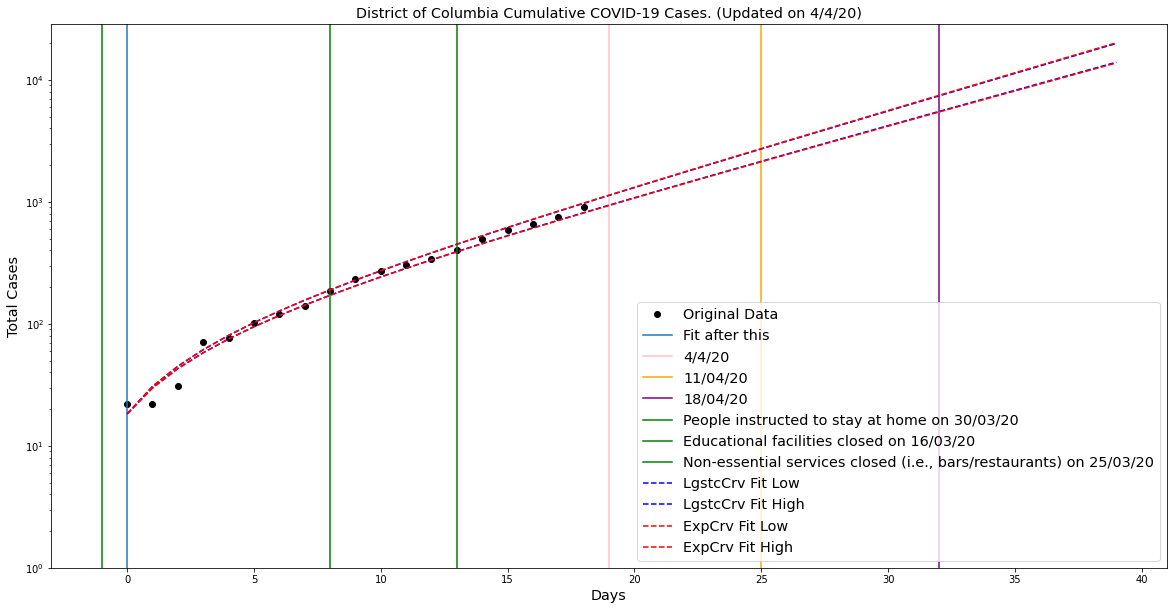

US state deaths:  District of Columbia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 21
	Confirmed cases on 3/28/20 	 4
	Ratio: 5.25
	Weekly increase: 425.0 %
	Daily increase: 26.7 % per day
	Doubling Time (represents recent growth): 2.9 days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


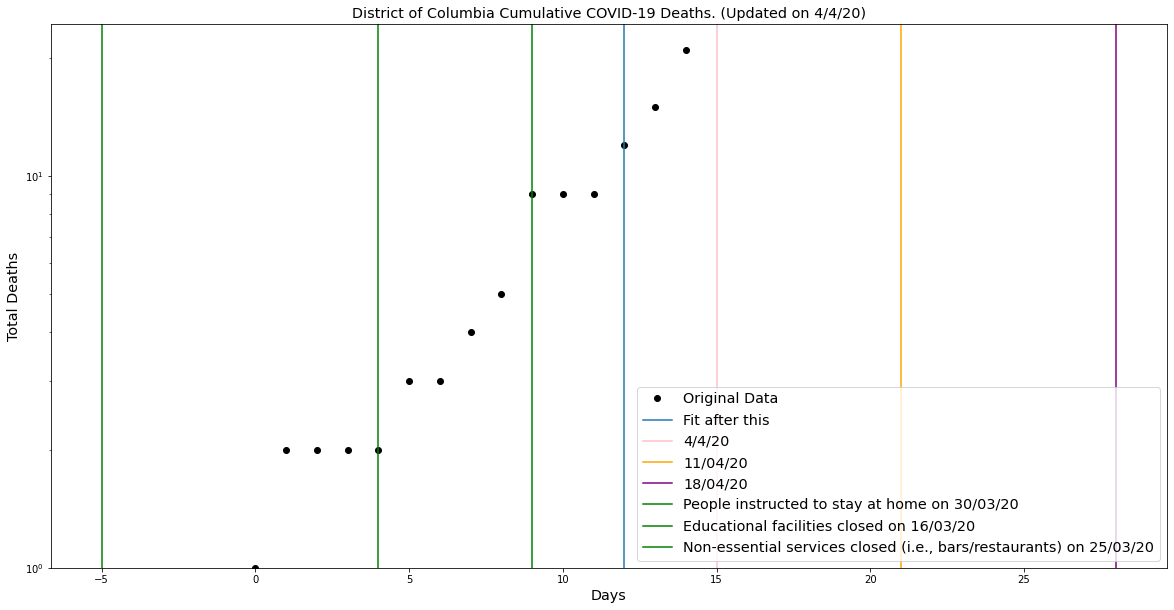



US state:  Oregon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 899
	Confirmed cases on 3/28/20 	 479
	Ratio: 1.88
	Weekly increase: 87.7 %
	Daily increase: 9.4 % per day
	Doubling Time (represents recent growth): 7.7 days

** Based on Exponential Fit **

	R^2: 0.9801088836921487
	Skipping 8 days
	Doubling Time (represents overall growth):  6.75 (± 1.04 ) days


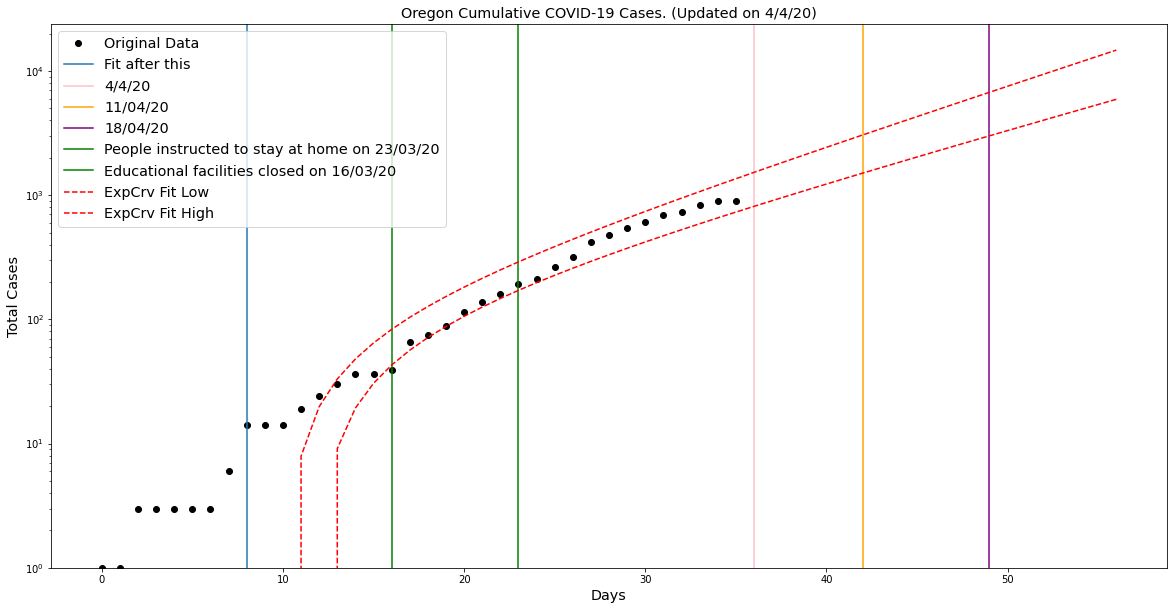

US state deaths:  Oregon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 22
	Confirmed cases on 3/28/20 	 13
	Ratio: 1.69
	Weekly increase: 69.2 %
	Daily increase: 7.8 % per day
	Doubling Time (represents recent growth): 9.2 days

** Based on Exponential Fit **

	R^2: 0.9603122684506392
	Skipping 11 days
	Doubling Time (represents overall growth):  58.3 (± 521.4 ) days


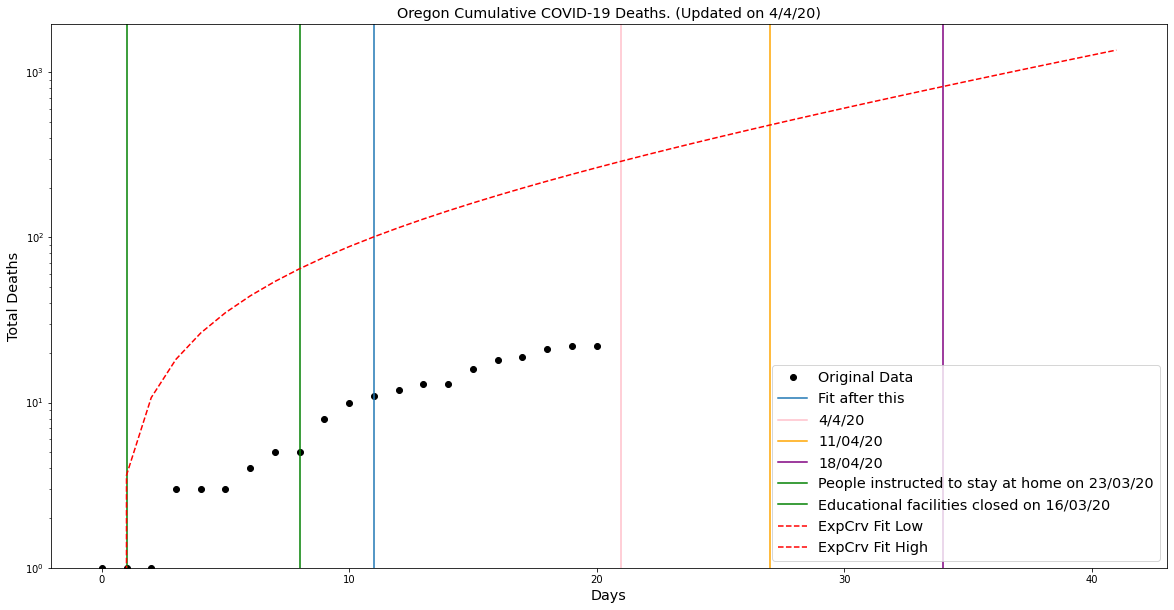



US state:  Minnesota

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 865
	Confirmed cases on 3/28/20 	 441
	Ratio: 1.96
	Weekly increase: 96.1 %
	Daily increase: 10.1 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9985328302741374
	Skipping 7 days
	Doubling Time (during middle of growth):  7.39 (± 0.87 ) days

** Based on Exponential Fit **

	R^2: 0.9911671601398924
	Skipping 7 days
	Doubling Time (represents overall growth):  7.19 (± 1.23 ) days


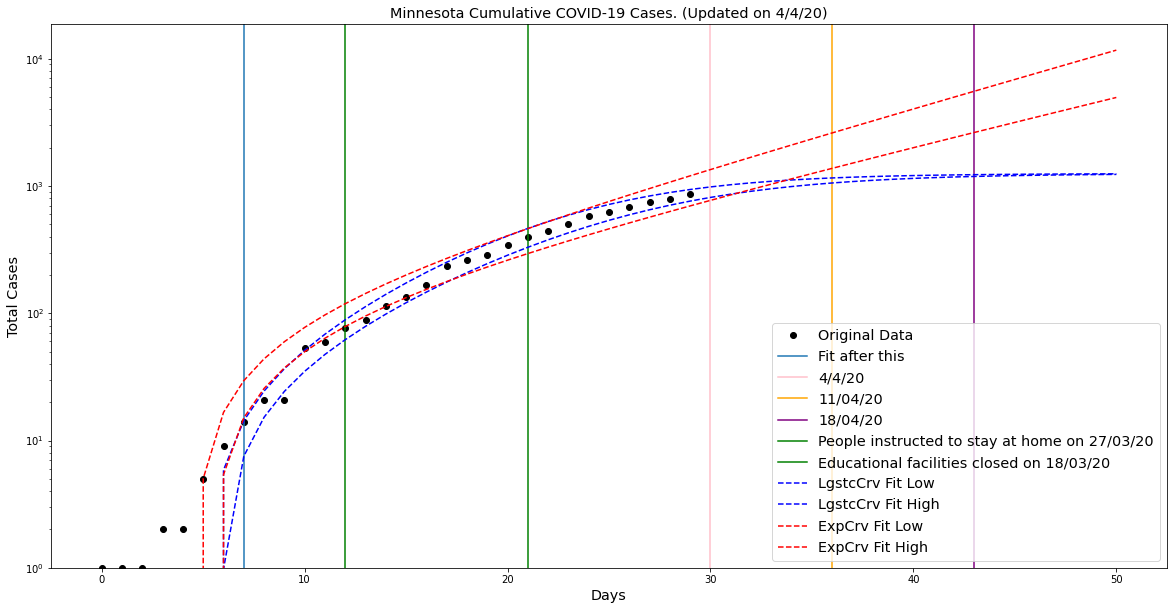

US state deaths:  Minnesota

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 24
	Confirmed cases on 3/28/20 	 5
	Ratio: 4.8
	Weekly increase: 380.0 %
	Daily increase: 25.1 % per day
	Doubling Time (represents recent growth): 3.1 days


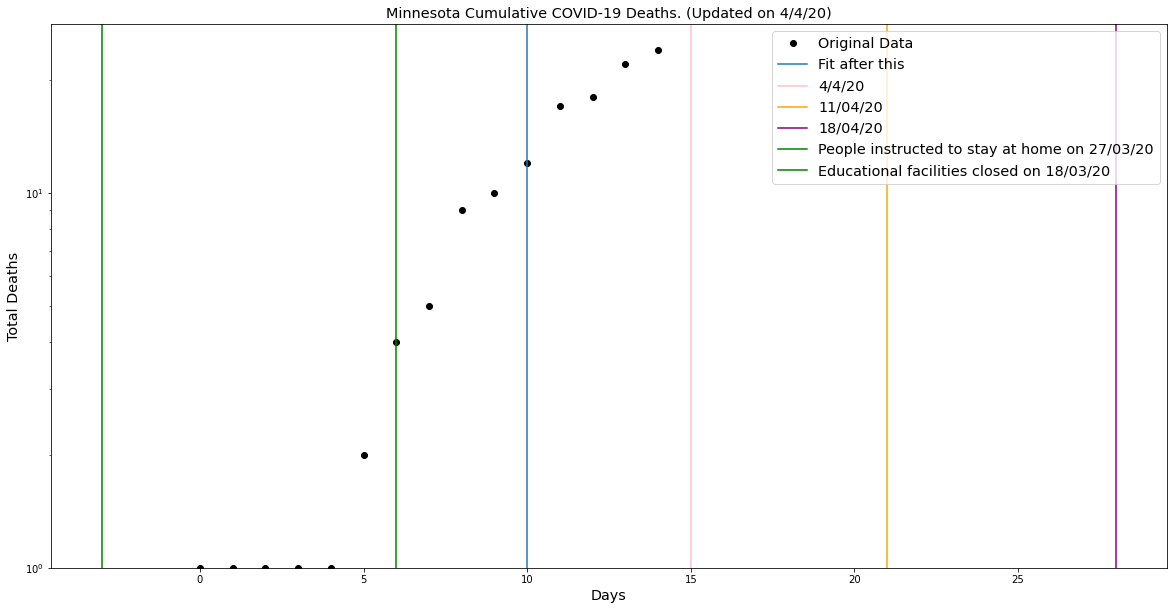



US state:  Rhode Island

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 806
	Confirmed cases on 3/28/20 	 239
	Ratio: 3.37
	Weekly increase: 237.2 %
	Daily increase: 19.0 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Exponential Fit **

	R^2: 0.9895339375459028
	Skipping 12 days
	Doubling Time (represents overall growth):  4.52 (± 0.53 ) days


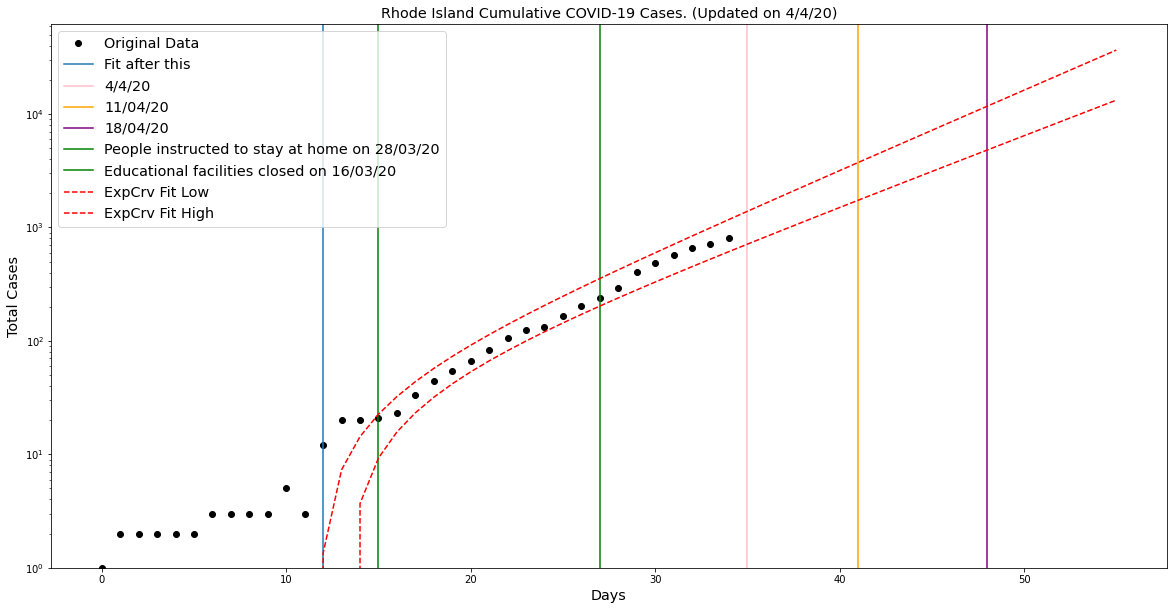

US state deaths:  Rhode Island

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 17
	Confirmed cases on 3/28/20 	 2
	Ratio: 8.5
	Weekly increase: 750.0 %
	Daily increase: 35.8 % per day
	Doubling Time (represents recent growth): 2.3 days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


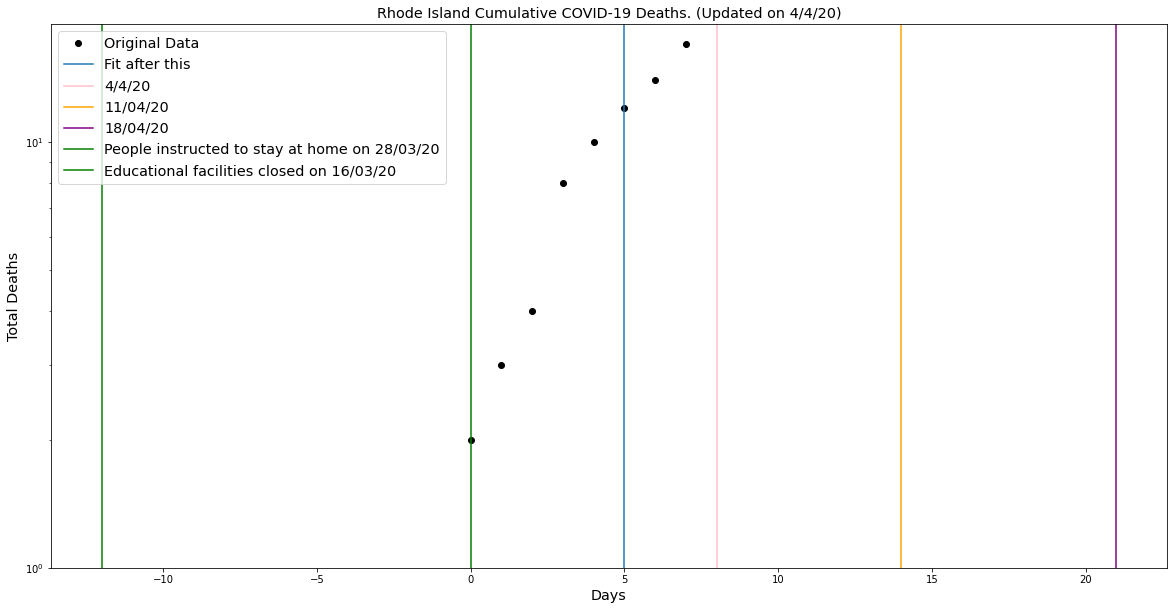



US state:  Iowa

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 787
	Confirmed cases on 3/28/20 	 298
	Ratio: 2.64
	Weekly increase: 164.1 %
	Daily increase: 14.9 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.9988528088131347
	Skipping 2 days
	Doubling Time (during middle of growth):  5.41 (± 0.49 ) days

** Based on Exponential Fit **

	R^2: 0.9930250038733673
	Skipping 2 days
	Doubling Time (represents overall growth):  4.97 (± 0.49 ) days


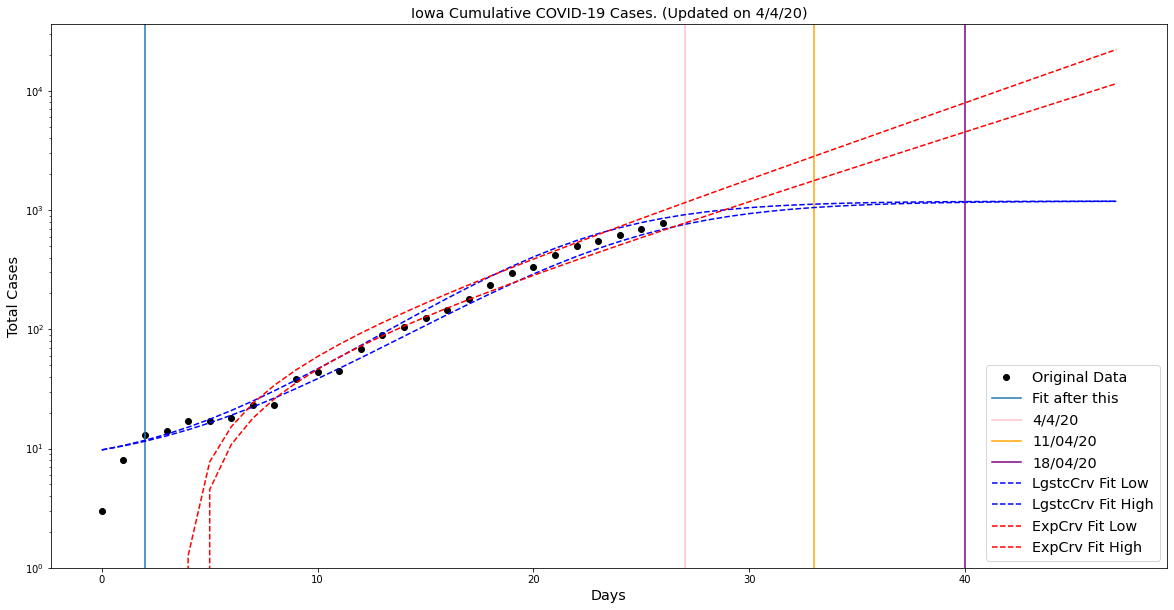

US state deaths:  Iowa

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 14
	Confirmed cases on 3/28/20 	 3
	Ratio: 4.67
	Weekly increase: 366.7 %
	Daily increase: 24.6 % per day
	Doubling Time (represents recent growth): 3.1 days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


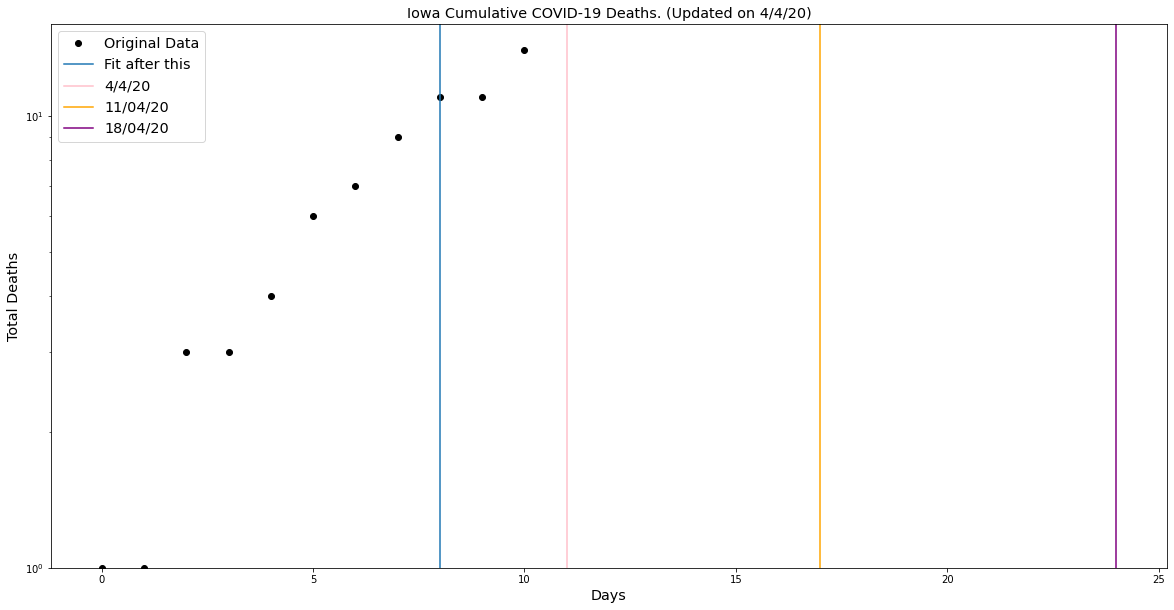



US state:  Arkansas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 743
	Confirmed cases on 3/28/20 	 409
	Ratio: 1.82
	Weekly increase: 81.7 %
	Daily increase: 8.9 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Logistic Fit**

	R^2: 0.9928124934127539
	Skipping 1 days
	Doubling Time (during middle of growth):  9.59 (± 4.22 ) days

** Based on Exponential Fit **

	R^2: 0.9777972489404255
	Skipping 1 days
	Doubling Time (represents overall growth):  6.93 (± 1.93 ) days


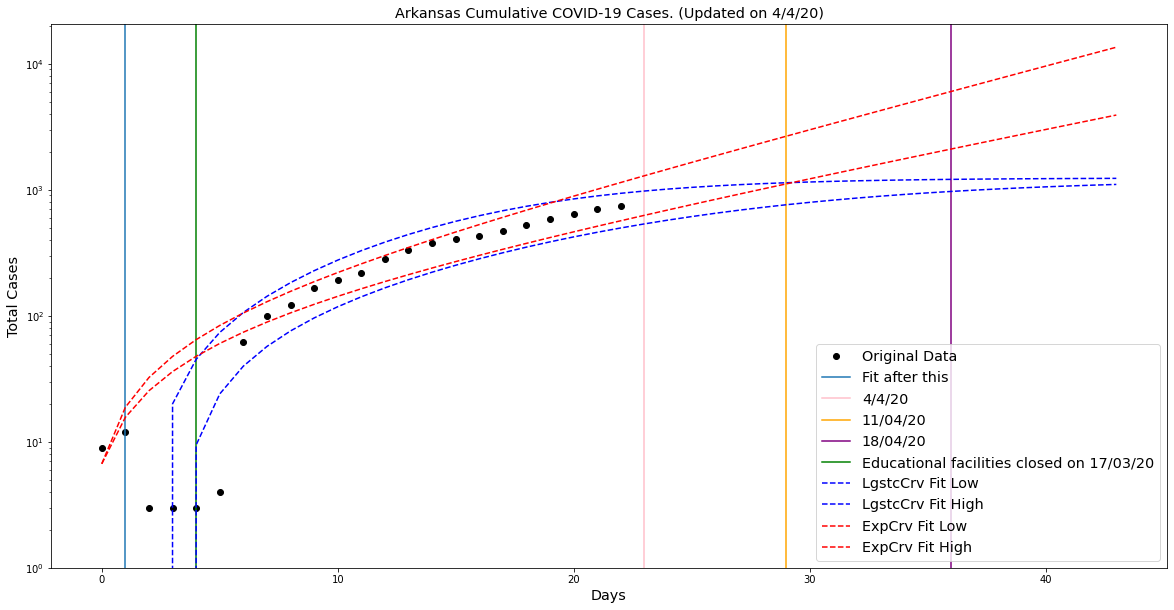

US state deaths:  Arkansas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 14
	Confirmed cases on 3/28/20 	 5
	Ratio: 2.8
	Weekly increase: 180.0 %
	Daily increase: 15.8 % per day
	Doubling Time (represents recent growth): 4.7 days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


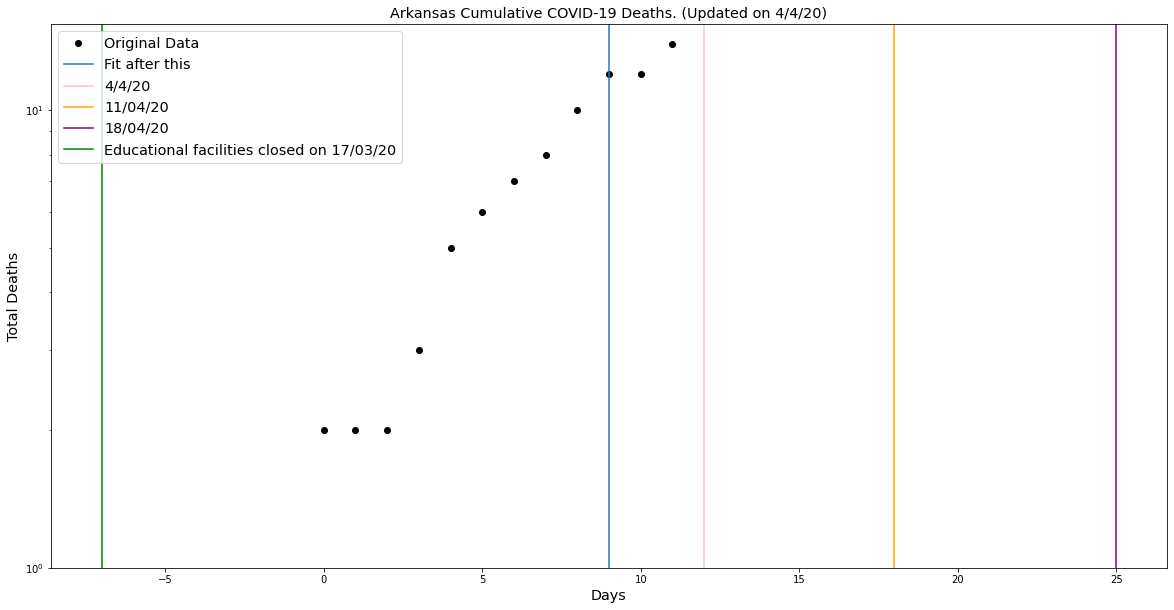



US state:  Kansas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 698
	Confirmed cases on 3/28/20 	 266
	Ratio: 2.62
	Weekly increase: 162.4 %
	Daily increase: 14.8 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Exponential Fit **

	R^2: 0.9831194577110898
	Skipping 8 days
	Doubling Time (represents overall growth):  5.77 (± 0.73 ) days


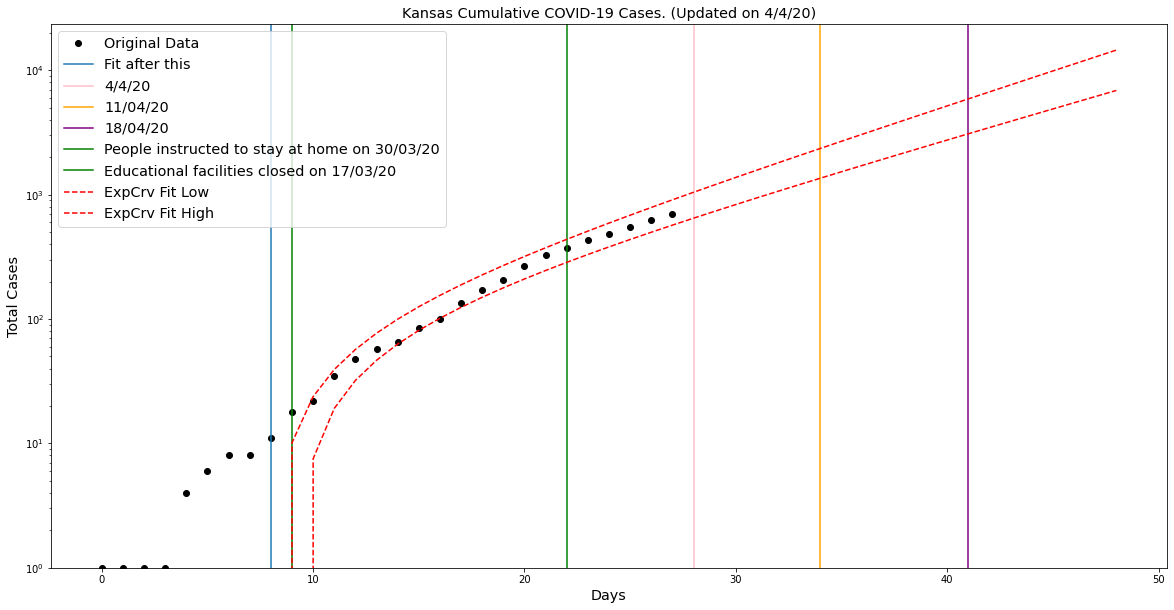

US state deaths:  Kansas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 21
	Confirmed cases on 3/28/20 	 4
	Ratio: 5.25
	Weekly increase: 425.0 %
	Daily increase: 26.7 % per day
	Doubling Time (represents recent growth): 2.9 days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


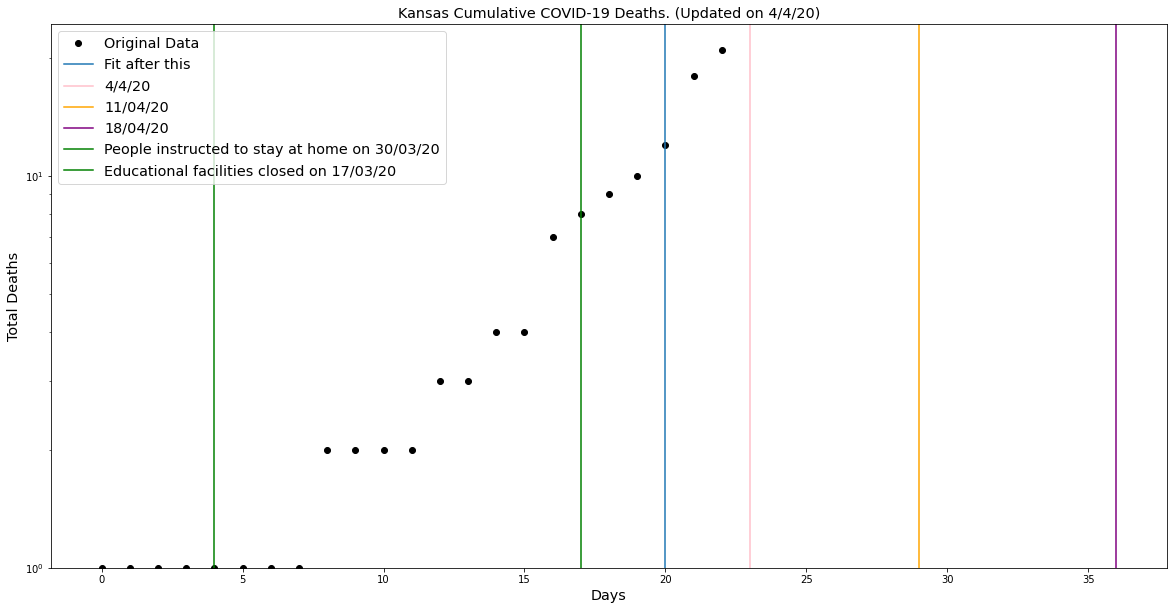



US state:  Delaware

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 593
	Confirmed cases on 3/28/20 	 214
	Ratio: 2.77
	Weekly increase: 177.1 %
	Daily increase: 15.7 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Exponential Fit **

	R^2: 0.9928254368027356
	Skipping 6 days
	Doubling Time (represents overall growth):  5.13 (± 0.77 ) days


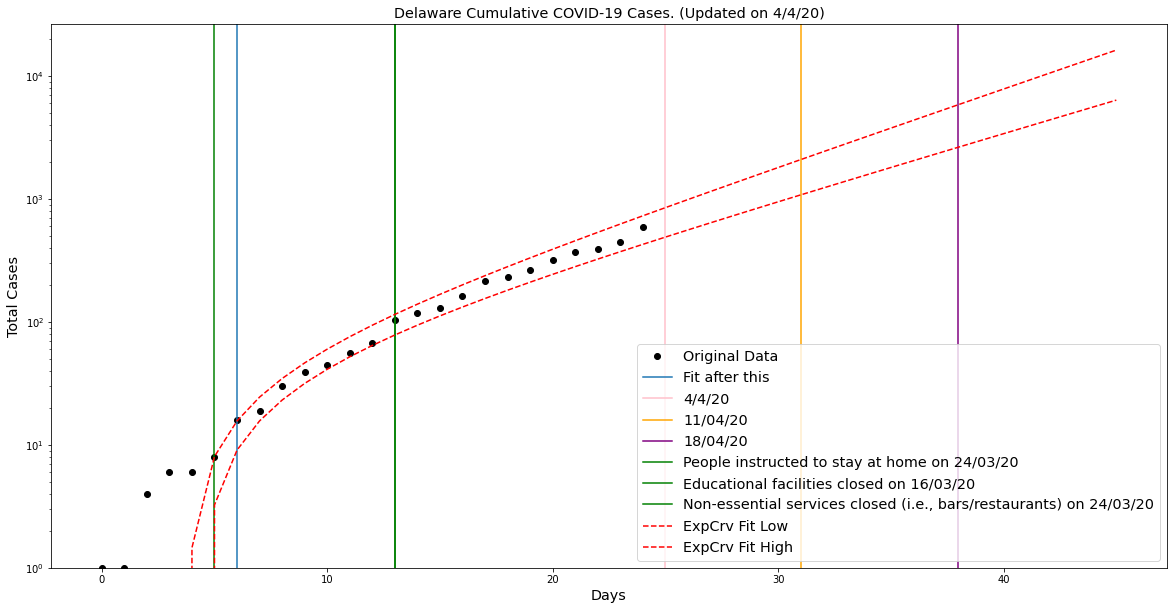

US state deaths:  Delaware

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 14
	Confirmed cases on 3/28/20 	 5
	Ratio: 2.8
	Weekly increase: 180.0 %
	Daily increase: 15.8 % per day
	Doubling Time (represents recent growth): 4.7 days


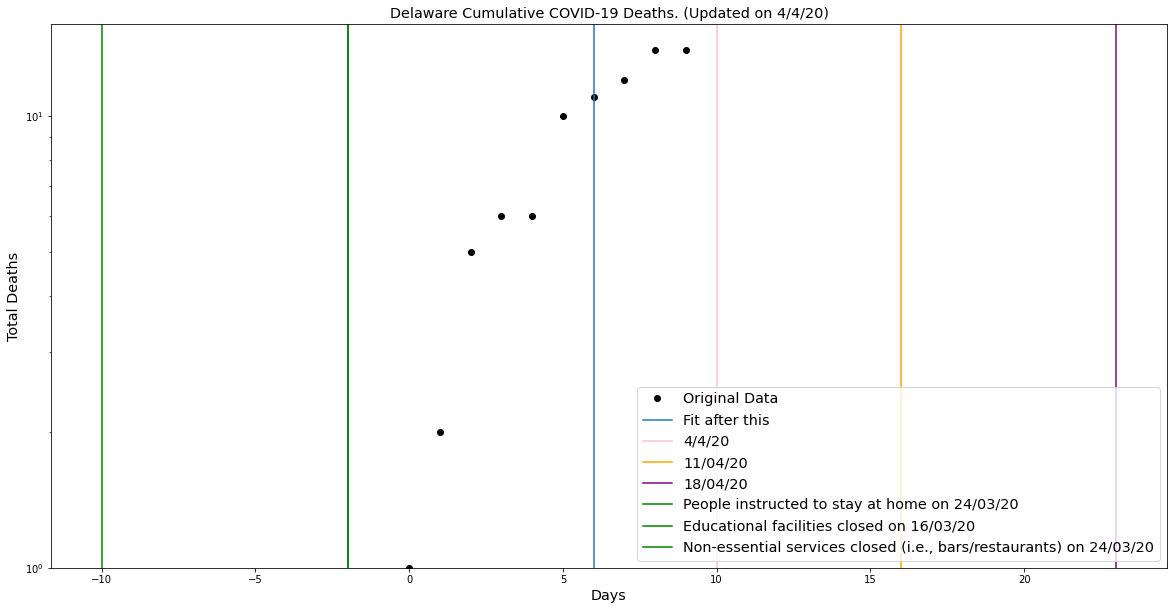



US state:  New Hampshire

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 540
	Confirmed cases on 3/28/20 	 187
	Ratio: 2.89
	Weekly increase: 188.8 %
	Daily increase: 16.4 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Exponential Fit **

	R^2: 0.9753429334798753
	Skipping 14 days
	Doubling Time (represents overall growth):  5.44 (± 1.61 ) days


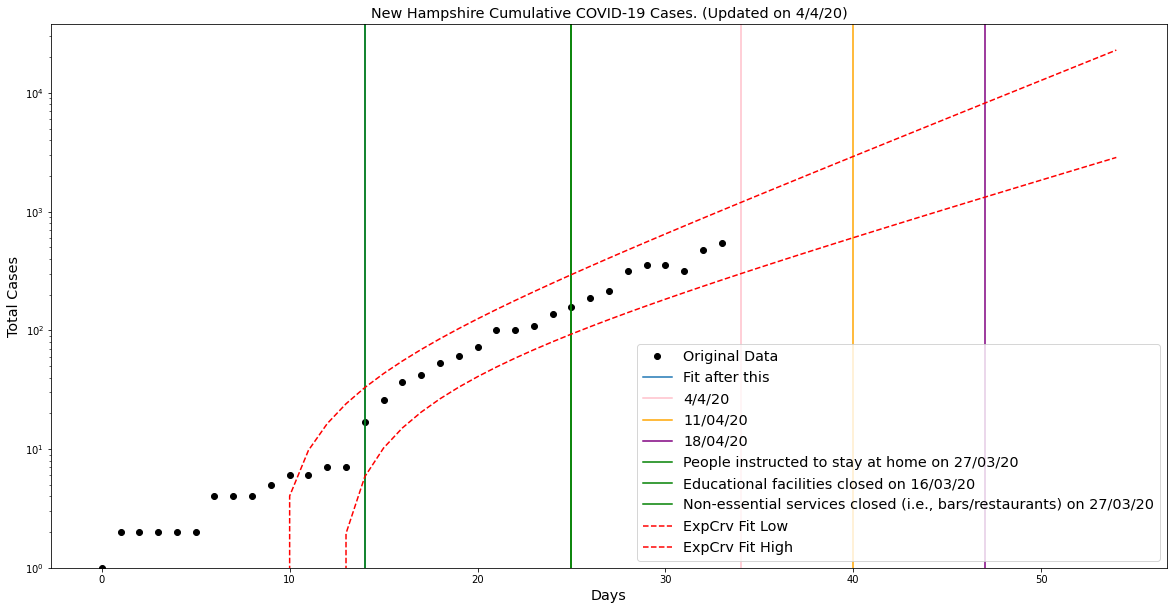

US state deaths:  New Hampshire

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 7
	Confirmed cases on 3/28/20 	 2
	Ratio: 3.5
	Weekly increase: 250.0 %
	Daily increase: 19.6 % per day
	Doubling Time (represents recent growth): 3.9 days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in sqrt


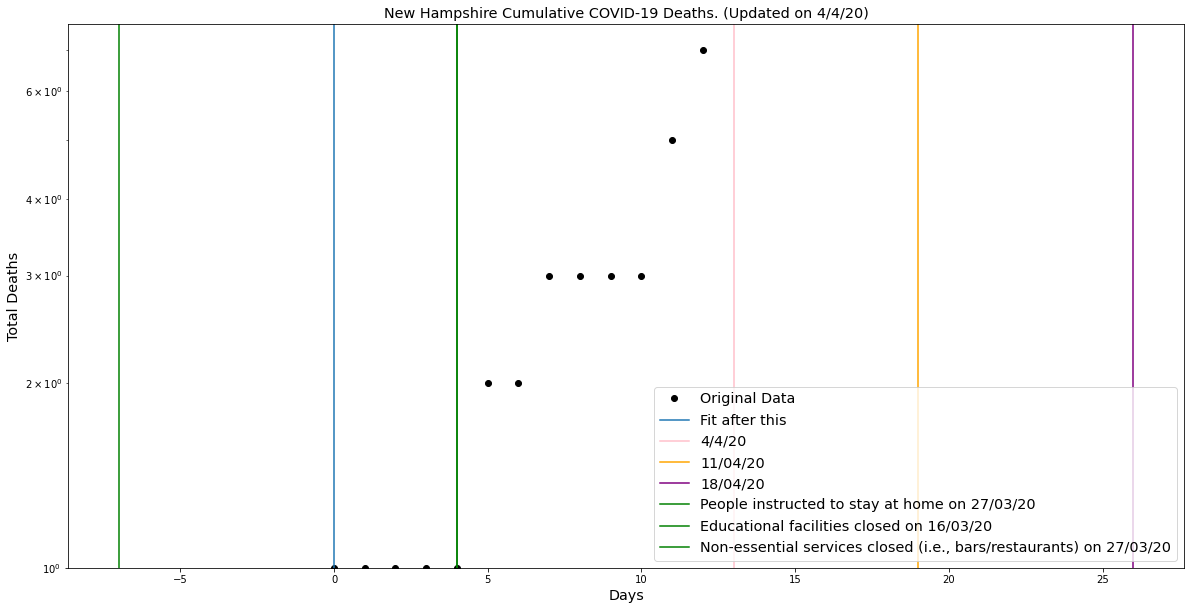



US state:  New Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 534
	Confirmed cases on 3/28/20 	 208
	Ratio: 2.57
	Weekly increase: 156.7 %
	Daily increase: 14.4 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.9896430222341068
	Skipping 3 days
	Doubling Time (during middle of growth):  7.49 (± 3.68 ) days

** Based on Exponential Fit **

	R^2: 0.9892819385918042
	Skipping 3 days
	Doubling Time (represents overall growth):  4.6 (± 0.67 ) days


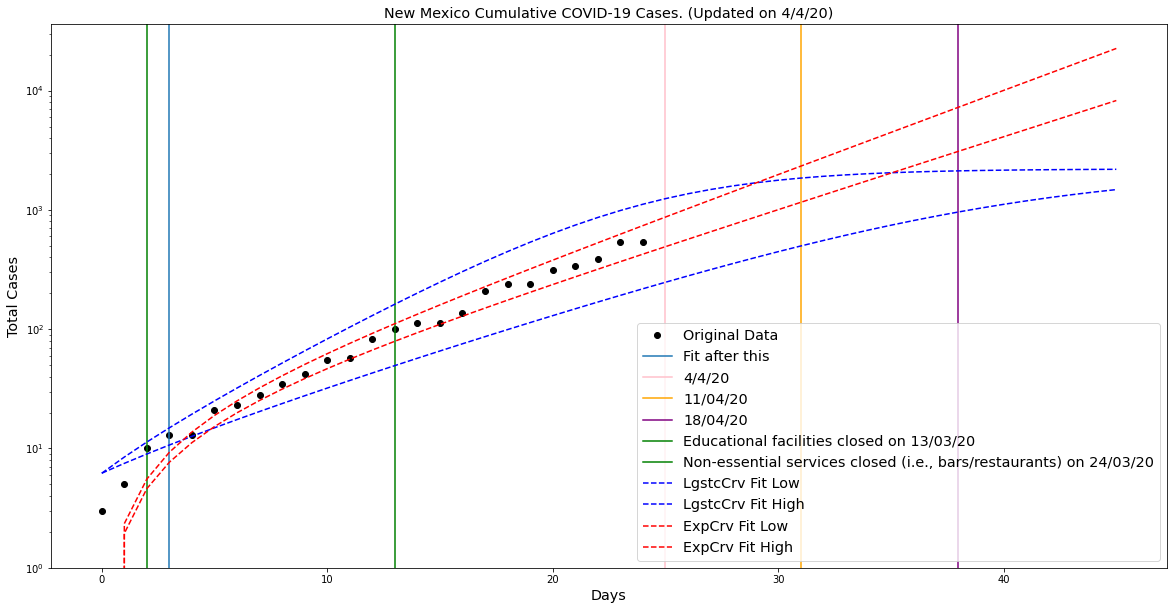

US state deaths:  New Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 10
	Confirmed cases on 3/28/20 	 1
	Ratio: 10.0
	Weekly increase: 900.0 %
	Daily increase: 38.9 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.9751673714259819
	Skipping 0 days
	Doubling Time (during middle of growth):  2.06 (± 1.33 ) days

** Based on Exponential Fit **

	R^2: 0.9591605837987249
	Skipping 0 days
	Doubling Time (represents overall growth):  2.78 (± 1.35 ) days


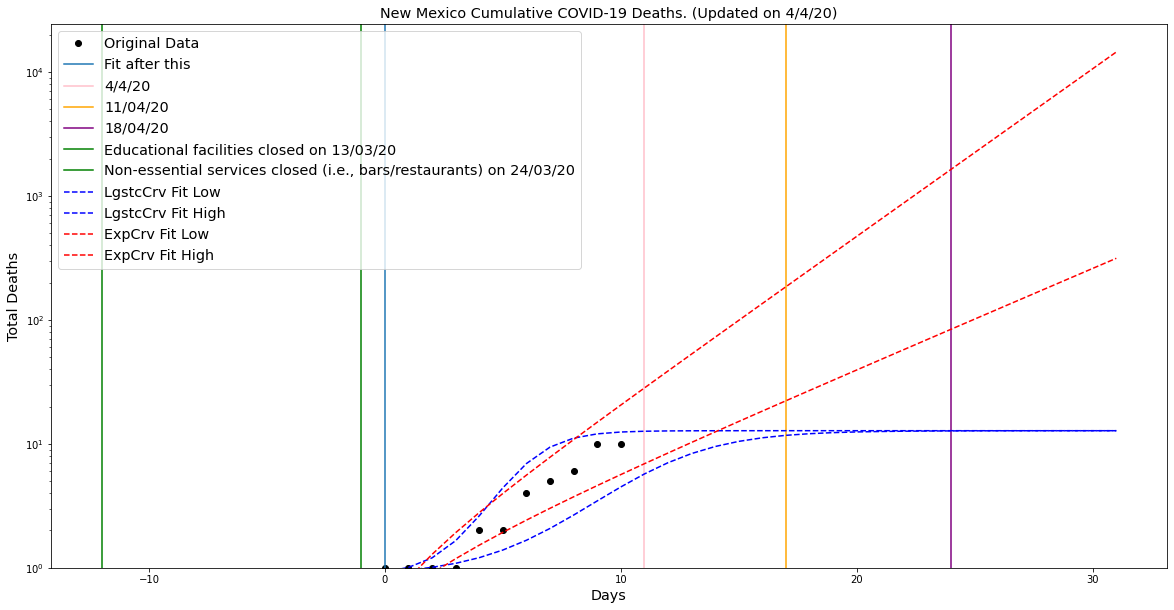



US state:  Vermont

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 461
	Confirmed cases on 3/28/20 	 211
	Ratio: 2.18
	Weekly increase: 118.5 %
	Daily increase: 11.8 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Exponential Fit **

	R^2: 0.9736531950951808
	Skipping 8 days
	Doubling Time (represents overall growth):  7.67 (± 1.51 ) days


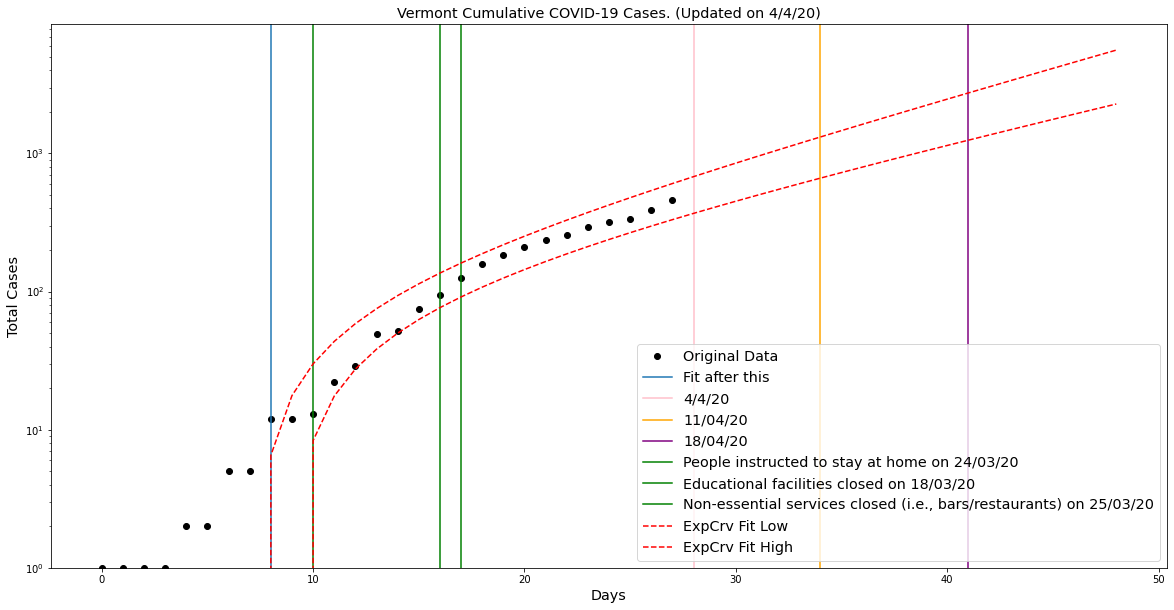

US state deaths:  Vermont

** Based on Most Recent Week of Data **

	Confirmed cases on 4/4/20 	 20
	Confirmed cases on 3/28/20 	 12
	Ratio: 1.67
	Weekly increase: 66.7 %
	Daily increase: 7.6 % per day
	Doubling Time (represents recent growth): 9.5 days


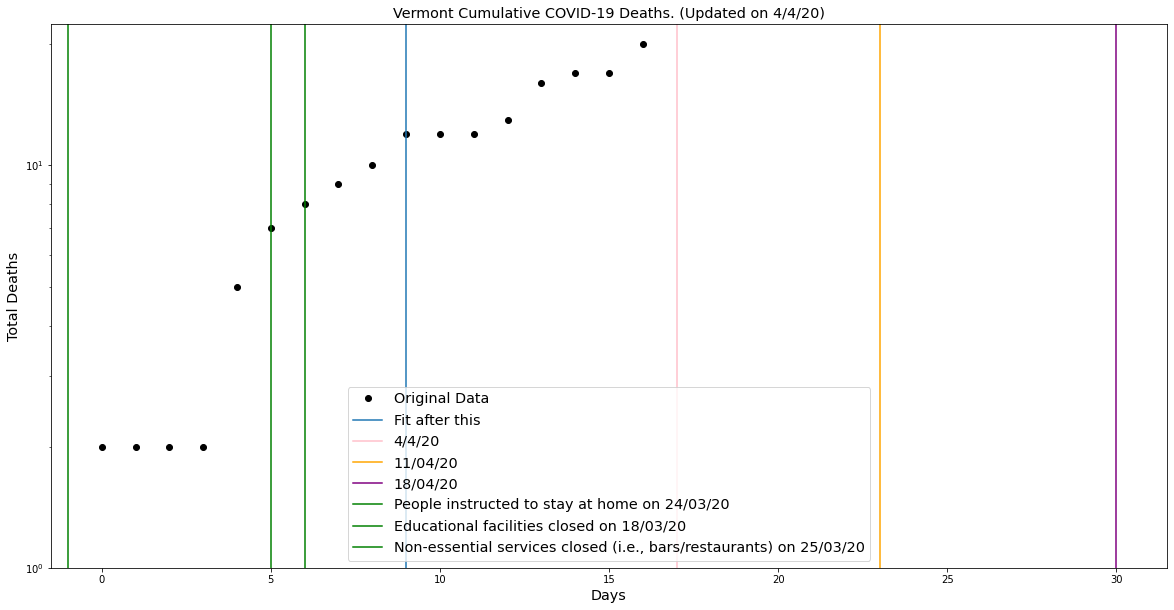

In [ ]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    
    if state == "Recovered":
        continue
    
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    
    print('US state deaths: ', state)
    a = plotCases(usdeaths,'Province/State', state, True)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


                  States  Inferred Doubling Time  95%CI  Recent Doubling Time
0               New York                     6.0    0.5                   6.3
1             New Jersey                     5.2    0.5                   4.3
2               Michigan                     6.0    0.5                   4.3
3             California                     4.8    0.3                   5.3
4              Louisiana                     3.4    0.3                   3.7
5          Massachusetts                     4.0    0.4                   4.8
6                Florida                     5.7    0.7                   4.3
7           Pennsylvania                     3.6    0.2                   3.7
8               Illinois                     4.3    0.4                   4.5
9           

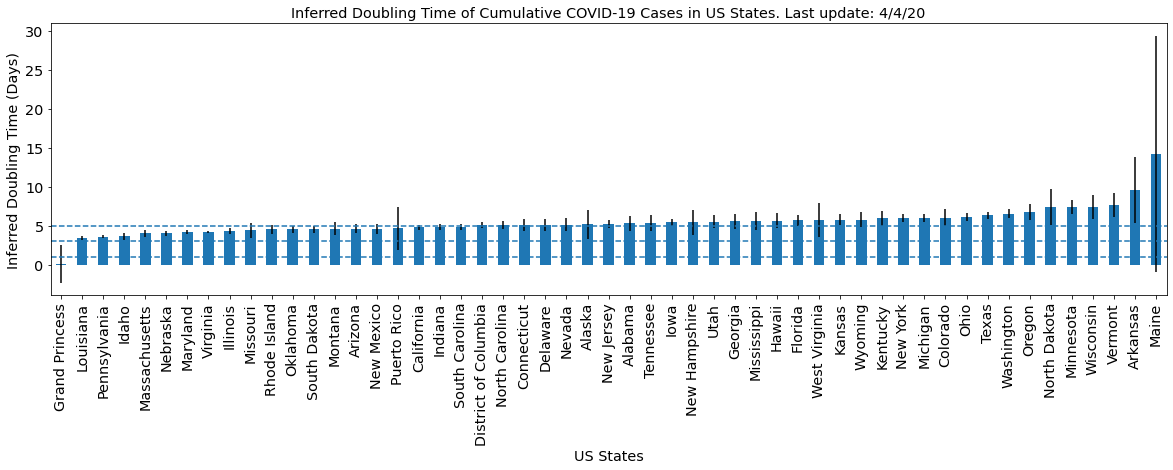

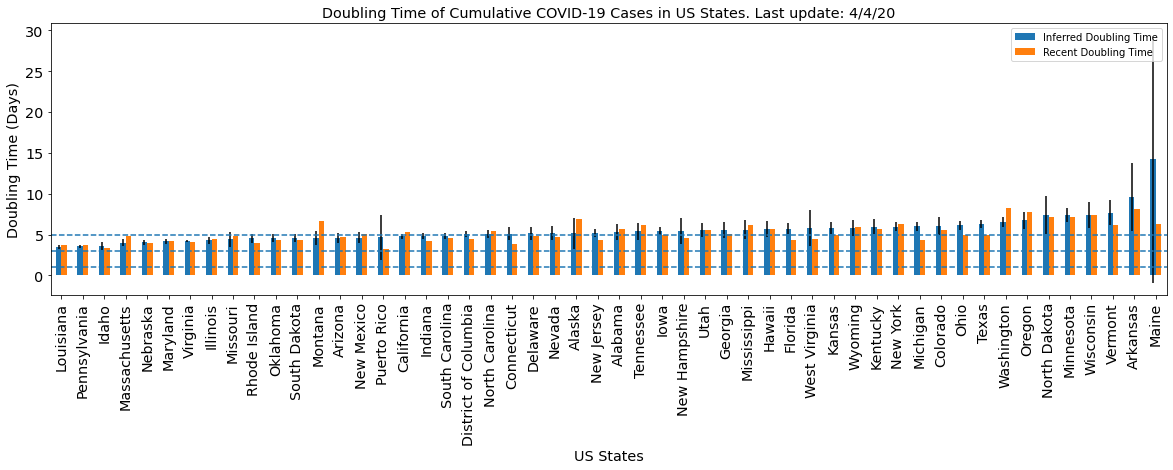

In [10]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).round(1))    

print('\n')
dt = pd.DataFrame(data = d).sort_values(by=['Inferred Doubling Time'])
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(20,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt.sort_values(by=['Inferred Doubling Time'])
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(20,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()